In [1]:
# import libraries
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import datetime as dt

# data visualization libraries
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import seaborn as sns
import plotly.graph_objects as go

# digunakan untuk cohort analysis untuk menhitung angka periode berjalan (bulan berjalan setelah akuisis new customer atau hasil dari order month - cohort month)
from operator import attrgetter

# machine learning libraries
from sklearn.preprocessing import StandardScaler

# forecasting libraries
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from prophet import Prophet

import warnings

In [2]:
df_sales = pd.read_csv('SalesTransactionv4a-230918-164139.csv')

In [3]:
df_sales

TransactionNo       Date ProductNo  \
0             581482  12/9/2019     22485   
1             581475  12/9/2019     22596   
2             581475  12/9/2019     23235   
3             581475  12/9/2019     23272   
4             581475  12/9/2019     23239   
...              ...        ...       ...   
536345       C536548  12/1/2018     22168   
536346       C536548  12/1/2018     21218   
536347       C536548  12/1/2018     20957   
536348       C536548  12/1/2018     22580   
536349       C536548  12/1/2018     22767   

                                ProductName  Price  Quantity  CustomerNo  \
0             Set Of 2 Wooden Market Crates  21.47        12     17490.0   
1       Christmas Star Wish List Chalkboard  10.65        36     13069.0   
2                  Storage Tin Vintage Leaf  11.53        12     13069.0   
3         Tree T-Light Holder Willie Winkie  10.65        12     13069.0   
4         Set Of 4 Knick Knack Tins Poppies  11.94         6     13069.0   
...                                     ...    ...       ...         ...   
536345         Organiser Wood Antique White  18.96        -2     12472.0   
536346               Red Spotty Biscuit Tin  14.09        -3     12472.0   
536347         Porcelain Hanging Bell Small  11.74        -1     12472.0   
536348         Advent Calendar Gingham Sack  16.35        -4     12472.0   
536349           Triple Photo Frame Cornice  20.45        -2     12472.0   

               Country  
0       United Kingdom  
1       United Kingdom  
2       United Kingdom  
3       United Kingdom  
4       United Kingdom  
...                ...  
536345         Germany  
536346         Germany  
536347         Germany  
536348         Germany  
536349         Germany  

[536350 rows x 8 columns]

# Data Cleansing
Eksekusi 2 code dibawah ini

In [5]:
# 1. Ubah kolom Date menjadi tipe datetime
df_sales['Date']= pd.to_datetime(df_sales['Date'])

# 2. Buang semua transaksi yang memiliki quantity negative atau yang TransactionNo diawali dengan C
df_sales = df_sales[df_sales['TransactionNo'].str[0]!='C']

df_sales = df_sales[(df_sales['Quantity'] > 0) & (df_sales['Price'] > 0)]

In [6]:
df_sales.isnull().sum()

TransactionNo    0
Date             0
ProductNo        0
ProductName      0
Price            0
Quantity         0
CustomerNo       1
Country          0
dtype: int64

# Top Contributing products

Pada retail store, ada banyak jenis barang yang dijual.
Memahami karakteristik penjualan di setiap barang sangatlah penting.  
Barang-barang dengan minat tinggi dari customer menjadi kunci bisnis untuk meraih untung.
Barang-barang dengan minat rendah dari masyarakat akan menjadi beban dari usaha apabila bisnis menyetok terlalu banyak.

Salah satu metode segmentasi yang digunakan adalah menggunakan segmentasi berdasarkan :
- Volume transaksi : Berapa banyak transaksi yang melibatkan suatu produk (Tidak mempedulikan banyaknya barang dalam 1 transaksi)
- Revenue total : Berapa dolar revenue yang dihasilkan dari penjualan produk ini.

Buatlah segmentasi produk berdasarkan volume dan revenue total dengan aturan sebagai berikut :

1. total_revenue didefinisikan sebagai perkalian harga barang dengan banyaknya pembelian
2. 20% produk dengan volume transaksi transaksi tertinggi masuk kategori "Popular". 20 - 80% Masuk kategori "Normal" dan sisanya masuk ke kategori "Low"
3. 20% produk dengan total revenue tertinggi masuk kategori "Popular". 20 - 80% Masuk kategori "Normal" dan sisanya masuk ke kategori "Low"
4. Berdasarkan penggabungan segmentasi no.2 dan no.3, apabila suatu produk Popular dari segi volume transaksi dan total revenue, maka segmentasi final dari produk tersebut adalah "Super Popular". Apabila salah satu atribut populer sementara atribut lainnya normal, maka segmentasi finalnya adalah "Popular". Apabila kedua atributnya "Low", maka segmentasi finalnya adalah "Low". Semua kombinasi lain selain yang disebutkan masuk ke kategori "Normal"

## Pertanyaan
1. Barang tipe apa yang masuk ke kategori super populer pada bulan November 2019?
2. Apakah barang yang populer di November 2019 sama dengan barang yang populer di 
3. Apakah barang yang masuk kategori super populer di november sama dengan barang super populer di July ?

### 1. Menambahkan kolom total_revenue

In [9]:
df_sales['total_revenue'] = df_sales['Price'] * df_sales['Quantity']
df_sales

TransactionNo       Date ProductNo  \
0             581482 2019-12-09     22485   
1             581475 2019-12-09     22596   
2             581475 2019-12-09     23235   
3             581475 2019-12-09     23272   
4             581475 2019-12-09     23239   
...              ...        ...       ...   
536320        536585 2018-12-01     37449   
536321        536590 2018-12-01     22776   
536322        536590 2018-12-01     22622   
536323        536591 2018-12-01     37449   
536324        536597 2018-12-01     22220   

                                ProductName  Price  Quantity  CustomerNo  \
0             Set Of 2 Wooden Market Crates  21.47        12     17490.0   
1       Christmas Star Wish List Chalkboard  10.65        36     13069.0   
2                  Storage Tin Vintage Leaf  11.53        12     13069.0   
3         Tree T-Light Holder Willie Winkie  10.65        12     13069.0   
4         Set Of 4 Knick Knack Tins Poppies  11.94         6     13069.0   
...                                     ...    ...       ...         ...   
536320   Ceramic Cake Stand + Hanging Cakes  20.45         2     17460.0   
536321         Sweetheart 3 Tier Cake Stand  20.45         1     13065.0   
536322       Box Of Vintage Alphabet Blocks  20.45         2     13065.0   
536323   Ceramic Cake Stand + Hanging Cakes  20.45         1     14606.0   
536324     Cake Stand Lovebird 2 Tier White  20.45         1     18011.0   

               Country  total_revenue  
0       United Kingdom         257.64  
1       United Kingdom         383.40  
2       United Kingdom         138.36  
3       United Kingdom         127.80  
4       United Kingdom          71.64  
...                ...            ...  
536320  United Kingdom          40.90  
536321  United Kingdom          20.45  
536322  United Kingdom          40.90  
536323  United Kingdom          20.45  
536324  United Kingdom          20.45  

[527765 rows x 9 columns]

In [10]:
# df_sales.to_csv('df_sales.csv', index=False)

### 2. 20% produk dengan volume transaksi transaksi tertinggi masuk kategori "Popular". 20 - 80% Masuk kategori "Normal" dan sisanya masuk ke kategori "Low"

In [12]:
# Step 1: Groupby ProductName dan kalkulasi sum Quantity per ProductName
product_quantity = df_sales.groupby('ProductName')['Quantity'].sum().reset_index()

# Step 2: Urutkan sum quantity dari besar ke kecil
product_quantity = product_quantity.sort_values('Quantity', ascending=False).reset_index()

# Step 3: Tentukan batasan untuk kategori volume transaksi
total_products = len(product_quantity) # Menghitung jumlah total baris produk dalam dataset product_quantity
popular_limit = int(total_products * 0.2)  # Menentukan batas indeks untuk kategori "Popular" (20% produk teratas)
normal_limit = int(total_products * 0.8)  # Menentukan batas indeks untuk kategori "Normal" (21% - 80% produk teratas)

# Step 4: Define function untuk mengkategorikan volume transaksi dengan batasan yang sudah dibuat sebelumnya
def assign_category_by_index(index):
    if index < popular_limit:
        return "Popular"
    elif index < normal_limit:
        return "Normal"
    else:
        return "Low"

# Step 5: Terapkan function assign_category_by_index ke tabel product_quantity kolom Category 
product_quantity['Category'] = product_quantity.index.map(assign_category_by_index)

product_quantity = product_quantity.drop(columns = ['index'])

product_quantity

ProductName  Quantity Category
0              Paper Craft Little Birdie     80995  Popular
1         Medium Ceramic Top Storage Jar     78033  Popular
2                         Popcorn Holder     56921  Popular
3      World War 2 Gliders Asstd Designs     55047  Popular
4                Jumbo Bag Red Retrospot     48478  Popular
...                                  ...       ...      ...
3748      Orange/Fuschia Stones Necklace         1      Low
3749  Blue New Baroque Flock Candlestick         1      Low
3750        Green Pendant Shell Necklace         1      Low
3751       Vintage Bead Pink Jewel Stand         1      Low
3752           Tiny Crystal Bracelet Red         1      Low

[3753 rows x 3 columns]

In [13]:
# product_quantity.to_csv('product_quantity.csv', index=False)

### 3. 20% produk dengan total revenue tertinggi masuk kategori "Popular". 20 - 80% Masuk kategori "Normal" dan sisanya masuk ke kategori "Low"

In [15]:
# Step 1: Groupby ProductName dan kalkulasi sum total_revenue per ProductName
product_revenue = df_sales.groupby('ProductName')['total_revenue'].sum().reset_index()

# Step 2: Urutkan sum total_revenue dari besar ke kecil
product_revenue = product_revenue.sort_values('total_revenue', ascending=False).reset_index()

# Step 3: Tentukan batasan untuk kategori total revenue
total_products = len(product_quantity) # Menghitung jumlah total baris produk dalam dataset product_quantity
popular_limit = int(total_products * 0.2)  # Menentukan batas indeks untuk kategori "Popular" (20% produk teratas)
normal_limit = int(total_products * 0.8)  # Menentukan batas indeks untuk kategori "Normal" (80% produk teratas)

# Step 4: Define function untuk mengkategorikan total revenue
def assign_revenue_category_by_index(index):
    if index < popular_limit:
        return "Popular"
    elif index < normal_limit:
        return "Normal"
    else:
        return "Low"

# Step 5: Terapkan function assign_revenue_category_by_index ke tabel product_revenue kolom Category 
product_revenue['Category'] = product_revenue.index.map(assign_revenue_category_by_index)

product_revenue = product_revenue.drop(columns = ['index'])

product_revenue

ProductName  total_revenue Category
0              Paper Craft Little Birdie     1002718.10  Popular
1         Medium Ceramic Top Storage Jar      881990.18  Popular
2                         Popcorn Holder      587433.94  Popular
3      World War 2 Gliders Asstd Designs      569735.39  Popular
4     Cream Hanging Heart T-Light Holder      484592.69  Popular
...                                  ...            ...      ...
3748      Dusty Pink Christmas Tree 30cm          11.53      Low
3749     Pink Crystal Guitar Phone Charm          11.12      Low
3750           Hen House W Chick In Nest          10.68      Low
3751      Set 10 Cards Snowy Robin 17099           6.19      Low
3752      Crochet Lilac/Red Bear Keyring           6.19      Low

[3753 rows x 3 columns]

In [16]:
# product_revenue.to_csv('product_revenue.csv', index=False)

### 4. Berdasarkan penggabungan segmentasi no.2 dan no.3, apabila suatu produk Popular dari segi volume transaksi dan total revenue, maka segmentasi final dari produk tersebut adalah "Super Popular". Apabila salah satu atribut populer sementara atribut lainnya normal, maka segmentasi finalnya adalah "Popular". Apabila kedua atributnya "Low", maka segmentasi finalnya adalah "Low". Semua kombinasi lain selain yang disebutkan masuk ke kategori "Normal"

In [18]:
# Merge product_quantity dan product_revenue dengan kolom ProductName sebagai acuan merge
merged_segmentation = pd.merge(product_quantity, product_revenue, on='ProductName', suffixes=('_quantity', '_revenue'))

# Define function untuk segmentasi produk setelah dimerge
def final_segmentation(row):
    if row['Category_quantity'] == 'Popular' and row['Category_revenue'] == 'Popular':
        return 'Super Popular'
    elif (row['Category_quantity'] == 'Popular' and row['Category_revenue'] == 'Normal') or \
         (row['Category_quantity'] == 'Normal' and row['Category_revenue'] == 'Popular'):
        return 'Popular'
    elif row['Category_quantity'] == 'Low' and row['Category_revenue'] == 'Low':
        return 'Low'
    else:
        return 'Normal'

# Step 5: Terapkan function final_segmentation ke tabel merged_segmentation
merged_segmentation['final_product_segmentation'] = merged_segmentation.apply(final_segmentation, axis=1)

merged_segmentation

ProductName  Quantity Category_quantity  \
0              Paper Craft Little Birdie     80995           Popular   
1         Medium Ceramic Top Storage Jar     78033           Popular   
2                         Popcorn Holder     56921           Popular   
3      World War 2 Gliders Asstd Designs     55047           Popular   
4                Jumbo Bag Red Retrospot     48478           Popular   
...                                  ...       ...               ...   
3748      Orange/Fuschia Stones Necklace         1               Low   
3749  Blue New Baroque Flock Candlestick         1               Low   
3750        Green Pendant Shell Necklace         1               Low   
3751       Vintage Bead Pink Jewel Stand         1               Low   
3752           Tiny Crystal Bracelet Red         1               Low   

      total_revenue Category_revenue final_product_segmentation  
0        1002718.10          Popular              Super Popular  
1         881990.18          Popular              Super Popular  
2         587433.94          Popular              Super Popular  
3         569735.39          Popular              Super Popular  
4         297205.04          Popular              Super Popular  
...             ...              ...                        ...  
3748          15.35              Low                        Low  
3749          15.02              Low                        Low  
3750          15.47              Low                        Low  
3751          15.32              Low                        Low  
3752          12.79              Low                        Low  

[3753 rows x 6 columns]

In [19]:
# merged_segmentation.to_csv('merged_segmentation.csv', index=False)

C:\Users\benny\AppData\Local\Temp\ipykernel_17412\2935488735.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=merged_segmentation, x='final_product_segmentation', palette="cividis")


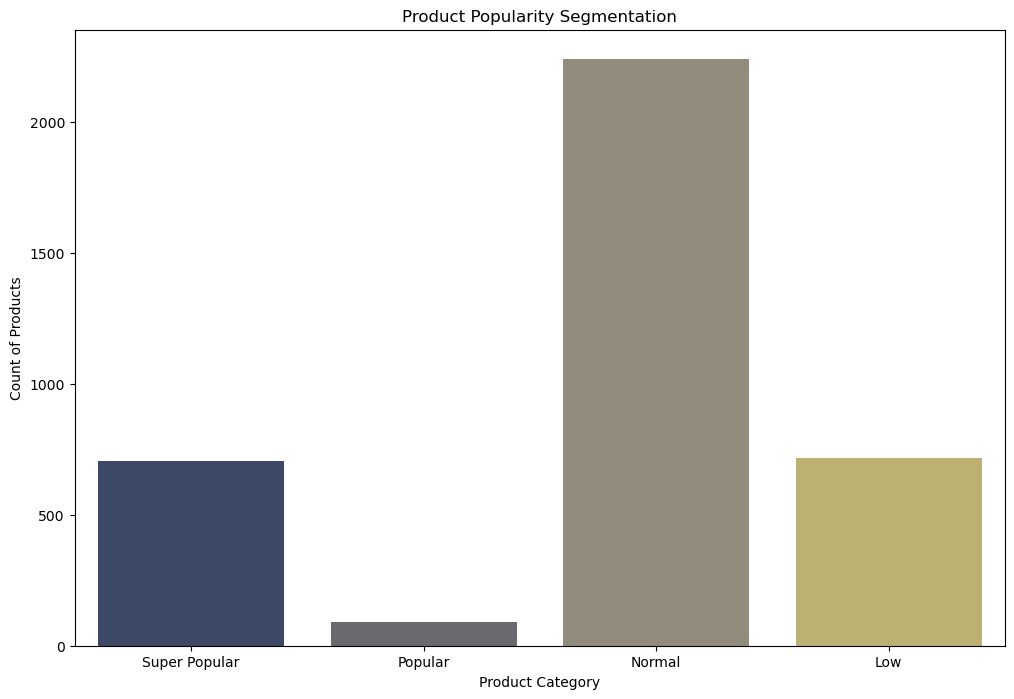

In [20]:
# Visualization
plt.figure(figsize=(12, 8))
sns.countplot(data=merged_segmentation, x='final_product_segmentation', palette="cividis")
plt.title("Product Popularity Segmentation")
plt.xlabel("Product Category")
plt.ylabel("Count of Products")
plt.show()

In [21]:
merged_segmentation['final_product_segmentation'].value_counts()

final_product_segmentation
Normal           2241
Low               717
Super Popular     705
Popular            90
Name: count, dtype: int64

# Retention Cohort Analysis

Analisis kohort adalah metode analisis yang digunakan untuk mempelajari perilaku konsumen atau pengguna dari kelompok yang sama dalam periode waktu tertentu.   
Contoh Kohort : Kohort kustomer yang bergabung pada bulan mei

Analisis retensi adalah analisis untuk melihat seberapa besar persentase pengguna atau pelanggan yang kembali menggunakan produk atau layanan dalam periode waktu tertentu.

Dengan menganalisis kohort dan retensi, perusahaan atau organisasi dapat mengidentifikasi tren dan pola dalam perilaku pengguna atau pelanggan.

Berikut cuplikan matriks retensi yang akan kalian hasilkan pada bagian ini : 

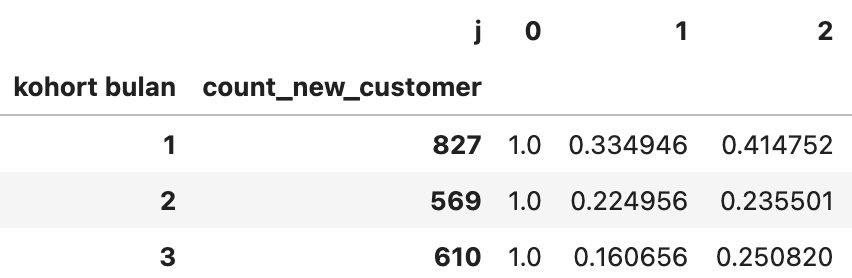

Cara baca :  
Pada bulan januari, ada 827 customer baru.  
33% dari 827 customer melakukan transaksi 1 bulan kemudian.  
41.4% dari 827 customer melakukan transasksi 2 bulan kemduain.  

Hal ini menunjukkan bahwa sekitar sepertiga customer yang melanjutkan transaksi setelah mendaftar pada bulan januari.  

Sedangkan pada kohort bulan februari, ada 569 customer baru dan hanya 22% customer yang kembali bertransaksi sebulan setelahnya  

## Buatlah matriks kohort retensi per bulan menggunakan data dari 1 januari 2019 hingga 30 november 2019
Petunjuk : 
1. Hitung tanggal berapa transaksi pertama customer. Disini kita menggunakna asumsi bahwa transaksi pertama pada tahun 2019 adalah transaksi pertama customer.
2. Lakukan iterasi untuk setiap bulan. Ambil berapa banyak customer yang mendaftar dan berapa banyak customer yang sama yang melakukan transaksi di bulan bulan berikutnya.

In [25]:
first_date = df_sales['Date'].min()
latest_date = df_sales['Date'].max()

print(f"First date: {first_date}")
print(f"Latest date: {latest_date}")

First date: 2018-12-01 00:00:00
Latest date: 2019-12-09 00:00:00


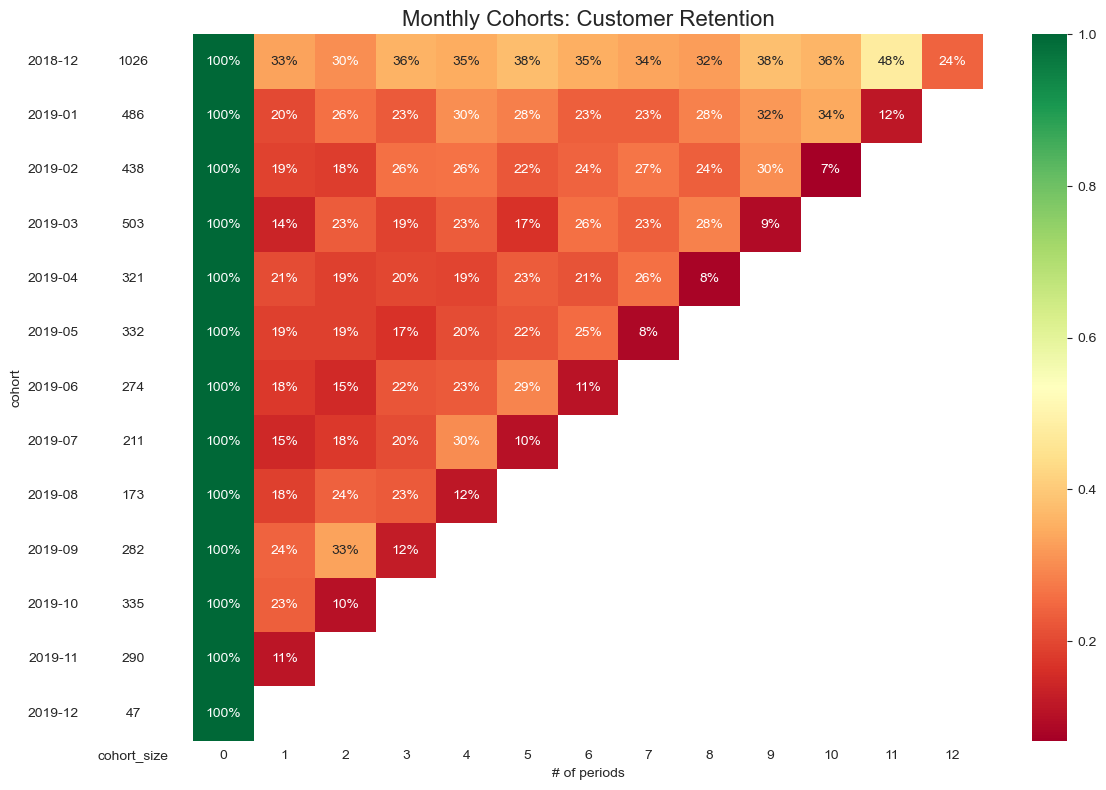

In [26]:
# Membuat variabel order_month dan cohort. 
# Variabel pertama menunjukkan cohort bulanan berdasarkan tanggal pembelian pertama 
df_sales['order_month'] = df_sales['Date'].dt.to_period('M')

# Variabel kedua adalah bulan terpotong dari tanggal pembelian.
df_sales['cohort'] = df_sales.groupby('CustomerNo')['Date'] \
                             .transform('min') \
                             .dt.to_period('M')

# Group by cohort and order_month to count unique customers
df_cohort = df_sales.groupby(['cohort', 'order_month']) \
                    .agg(n_customers=('CustomerNo', 'nunique')) \
                    .reset_index(drop=False)

# Mengkalkulasi jumlah periode beserta jumlah pelanggan unik di tiap periode
# Menggabungkan data per kelompok dan order_month dan menghitung jumlah pelanggan unik dalam setiap kelompok.
df_cohort['period_number'] = (df_cohort.order_month - df_cohort.cohort).apply(attrgetter('n'))

# Membuat pivot table untuk cohort analysisnya
cohort_pivot = df_cohort.pivot_table(index='cohort',
                                     columns='period_number',
                                     values='n_customers')

# Menghitung customer retention per periode cohort 
cohort_size = cohort_pivot.iloc[:, 0]
retention_matrix = cohort_pivot.divide(cohort_size, axis=0)

# Merotasi label sumbu y untuk bulan cohort, dirotasi menjadi horizontal 
with sns.axes_style("white"):
    fig, ax = plt.subplots(1, 2, figsize=(12, 8), sharey=True, gridspec_kw={'width_ratios': [1, 11]})

    # Visualisasi hasil kalkulasi customer retention ke dalam heatmap
    sns.heatmap(retention_matrix, 
                mask=retention_matrix.isnull(), 
                annot=True, 
                fmt='.0%', 
                cmap='RdYlGn', 
                ax=ax[1])

    ax[1].set_title('Monthly Cohorts: Customer Retention', fontsize=16)
    ax[1].set(xlabel='# of periods', ylabel='')
    ax[1].tick_params(axis='y', rotation=0)  # Rotasi y-axis labels menjadi horizontal

    # Cohort size heatmap
    cohort_size_df = pd.DataFrame(cohort_size).rename(columns={0: 'cohort_size'})
    white_cmap = mcolors.ListedColormap(['white'])
    sns.heatmap(cohort_size_df, 
                annot=True, 
                cbar=False, 
                fmt='g', 
                cmap=white_cmap, 
                ax=ax[0])

    ax[0].tick_params(axis='y', rotation=0)  # Rotasi y-axis labels menjadi horizontal

    fig.tight_layout()
    plt.show()

## Cohort Analysis untuk Januari 2019 - November 2019

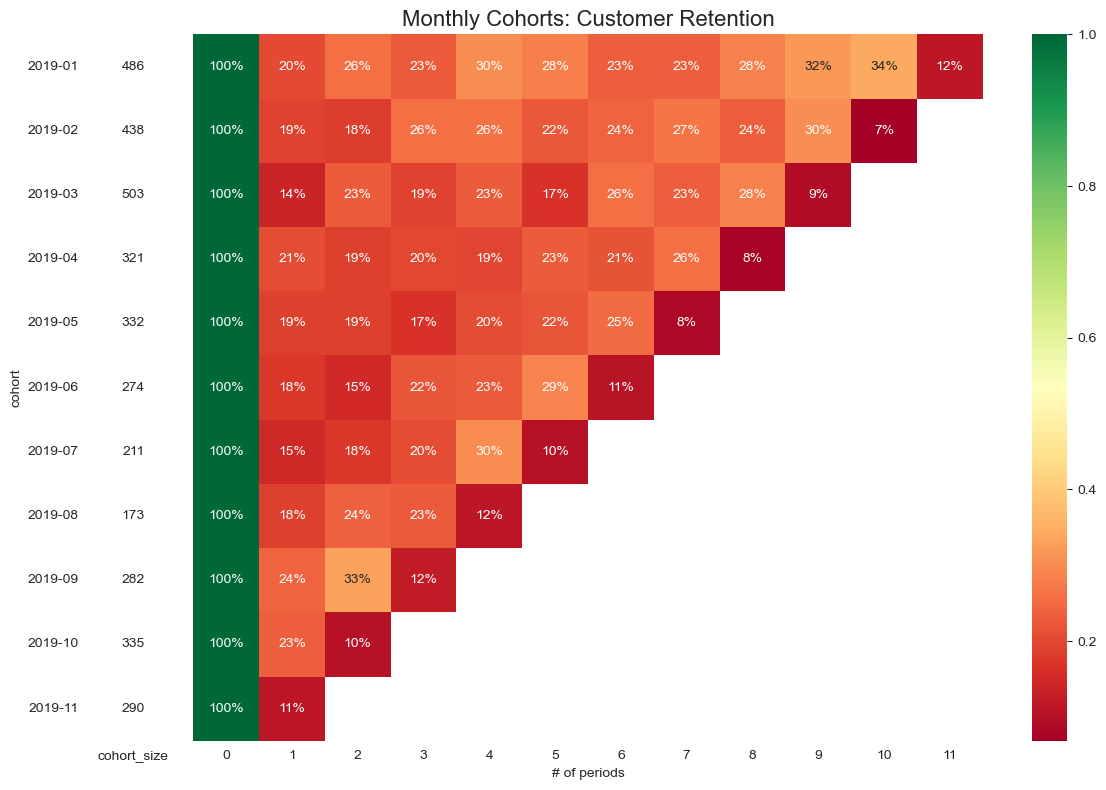

In [28]:
# Membuat variabel order_month dan cohort.
df_sales['order_month'] = df_sales['Date'].dt.to_period('M')
df_sales['cohort'] = df_sales.groupby('CustomerNo')['Date'].transform('min').dt.to_period('M')

# Menyaring data hanya untuk cohort bulan 2019-01 sampai 2019-11
df_sales_filtered = df_sales[(df_sales['cohort'] >= '2019-01') & (df_sales['cohort'] <= '2019-11')]

# Group by cohort dan order_month untuk menghitung jumlah pelanggan unik
df_cohort = df_sales_filtered.groupby(['cohort', 'order_month']) \
                             .agg(n_customers=('CustomerNo', 'nunique')) \
                             .reset_index(drop=False)

# Mengkalkulasi jumlah periode beserta jumlah pelanggan unik di tiap periode
df_cohort['period_number'] = (df_cohort.order_month - df_cohort.cohort).apply(attrgetter('n'))

# Membuat pivot table untuk cohort analysisnya
cohort_pivot = df_cohort.pivot_table(index='cohort',
                                     columns='period_number',
                                     values='n_customers')

# Menghitung customer retention per periode cohort 
cohort_size = cohort_pivot.iloc[:, 0]
retention_matrix = cohort_pivot.divide(cohort_size, axis=0)

# Visualisasi hasil kalkulasi customer retention ke dalam heatmap
with sns.axes_style("white"):
    fig, ax = plt.subplots(1, 2, figsize=(12, 8), sharey=True, gridspec_kw={'width_ratios': [1, 11]})

    # Visualisasi heatmap customer retention
    sns.heatmap(retention_matrix, 
                mask=retention_matrix.isnull(), 
                annot=True, 
                fmt='.0%', 
                cmap='RdYlGn', 
                ax=ax[1])

    ax[1].set_title('Monthly Cohorts: Customer Retention', fontsize=16)
    ax[1].set(xlabel='# of periods', ylabel='')
    ax[1].tick_params(axis='y', rotation=0)  # Rotasi y-axis labels menjadi horizontal

    # Visualisasi cohort size heatmap
    cohort_size_df = pd.DataFrame(cohort_size).rename(columns={0: 'cohort_size'})
    white_cmap = mcolors.ListedColormap(['white'])
    sns.heatmap(cohort_size_df, 
                annot=True, 
                cbar=False, 
                fmt='g', 
                cmap=white_cmap, 
                ax=ax[0])

    ax[0].tick_params(axis='y', rotation=0)  # Rotasi y-axis labels menjadi horizontal

    fig.tight_layout()
    plt.show()

## Pertanyaan
1. Bagaimana karakteristik pertumbuhan customer baru? Apakah pertumbuhan terus meningkat atau melambat?  

Jawab: Pertumbuhan customer baru terus melambat mulai tahun 2019 dengan jumlah customer baru paling sedikit terjadi di bulan Juli dan Agustus.

2. Setiap bulannya tim marketing menggunakan metode promosi campaign yang berbeda-beda. Bulan mana yang menghasilkan retention paling tinggi?  

Jawab: Di tahun 2019 metode promosi campaign yang menghasilkan retention rates paling tinggi adalah bulan November 2019

Conclusion:  
- Dalam konteks retention rates, strategi promosi campaign yang November 2019 adalah yang paling baik untuk membuat customer di bulan-bulan sebelumnya berbelanja kembali.
- Strategi promosi campaign yang dijalankan di November 2019 berhasil membuat customer retention rates meningkat kembali di angka sekitar 30%. Dimana 30% cukup baik dibandingkan bulan-bulan sebelumnya yang hanya sekitar 20%
- Metode promosi campaign di bulan Juli dan Agustus harus dihindari karena 2 bulan tersebut adalah metode campaign yang mendatangkan new customer paling rendah dan memiliki retention rate yang paling rendah juga, terutama metode promosi campaign bulan Agustus 2019.

# Time Series Analysis

Time series analysis adalah analisis untuk melihat trend suatu fenomena berdasarkan waktu.

## Pertanyaan 

Pertanyaan 1 :  
Coba totalkan penjualan setiap barang per hari.   
Bagaimana trend penjualan? Apakah ada mengalami kenaikan, penurunan, atau stagnant.

Pertanyaan 2 :  
Lakukan analisis seasonality dengan melihat total order per harinya dari Senin hingga Minggu.  


In [31]:
# Mengelompokkan data berdasarkan hari dan menghitung total order value
daily_sales = df_sales.groupby('Date').agg(total_sales=('total_revenue', 'sum')).reset_index()
daily_sales

Date  total_sales
0   2018-12-01    326820.08
1   2018-12-02    367316.62
2   2018-12-03    206313.62
3   2018-12-05    197565.27
4   2018-12-06    273420.10
..         ...          ...
300 2019-12-05    289050.50
301 2019-12-06    197440.51
302 2019-12-07    264266.66
303 2019-12-08    223265.49
304 2019-12-09   1106069.97

[305 rows x 2 columns]

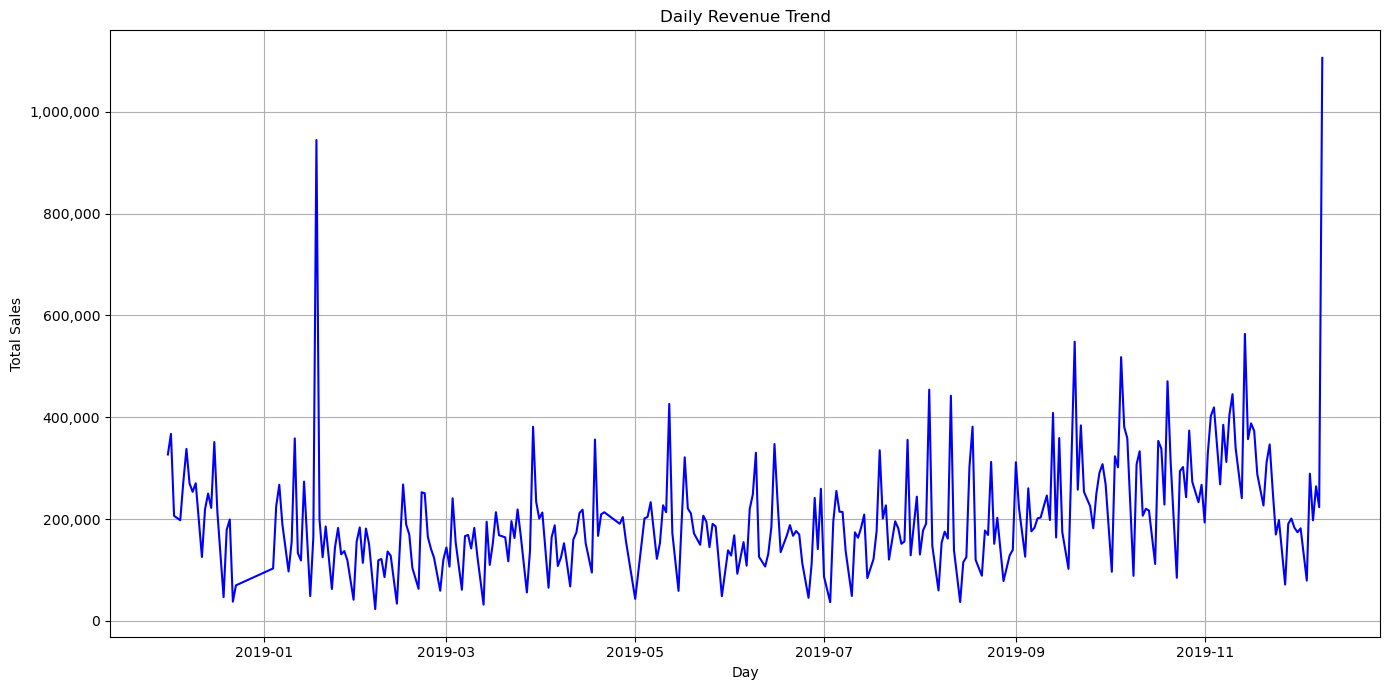

In [32]:
# Visualisasi tabel daily_sales
import matplotlib.ticker as mticker # library untuk mengubah format y-axis dari 1e6 jadi ratusan ribu atau jutaan 

plt.figure(figsize=(14, 7))
plt.plot(daily_sales['Date'], daily_sales['total_sales'], linestyle='-', color='b')
plt.title('Daily Revenue Trend')
plt.xlabel('Day')
plt.ylabel('Total Sales')
plt.grid()
plt.gca().yaxis.set_major_formatter(mticker.FuncFormatter(lambda x, _: f'{int(x):,}')) # mengubah format y-axis dari 1e6 jadi ratusan ribu atau jutaan 
plt.tight_layout()
plt.show()

### Karena dari visualisasi penjualan per hari di atas fluktuasinya terlalu tajam, maka sulit untuk menentukan trend dari time series analysis.

### Maka untuk mempermudah melihat trend dari time series analysis, akan digunakan 2 cara:
- Menggunakan smoothing data dengan rolling average untuk mengurangi noise di line chart sekaligus dijadikan trend line agar mempermudah membaca visualisasi line chart dari time series analysis
- Menghitung garis tren menggunakan linear regression yang akan menunjukkan rata-rata perubahan total pendapatan per hari lewat slope (kemiringan garis)
    - Jika slope > 0, tren meningkat.
    - Jika slope < 0, tren menurun.
    - Jika slope ≈ 0, tren stagnan.

In [35]:
daily_revenue = df_sales.groupby('Date')['total_revenue'].sum()
daily_revenue

Date
2018-12-01     326820.08
2018-12-02     367316.62
2018-12-03     206313.62
2018-12-05     197565.27
2018-12-06     273420.10
                 ...    
2019-12-05     289050.50
2019-12-06     197440.51
2019-12-07     264266.66
2019-12-08     223265.49
2019-12-09    1106069.97
Name: total_revenue, Length: 305, dtype: float64

### 1. Rolling Average, atau disebut juga Moving Average 
Adalah teknik yang sering digunakan dalam time series analysis untuk menghaluskan fluktuasi data dan mengidentifikasi tren jangka panjang. Caranya menghitung rata-rata per window/jendela waktu yang telah ditentukan. Contoh: rata-rata sales dihitung per hari diubah windownya menjadi per 7 hari dihitung rata-ratanya.

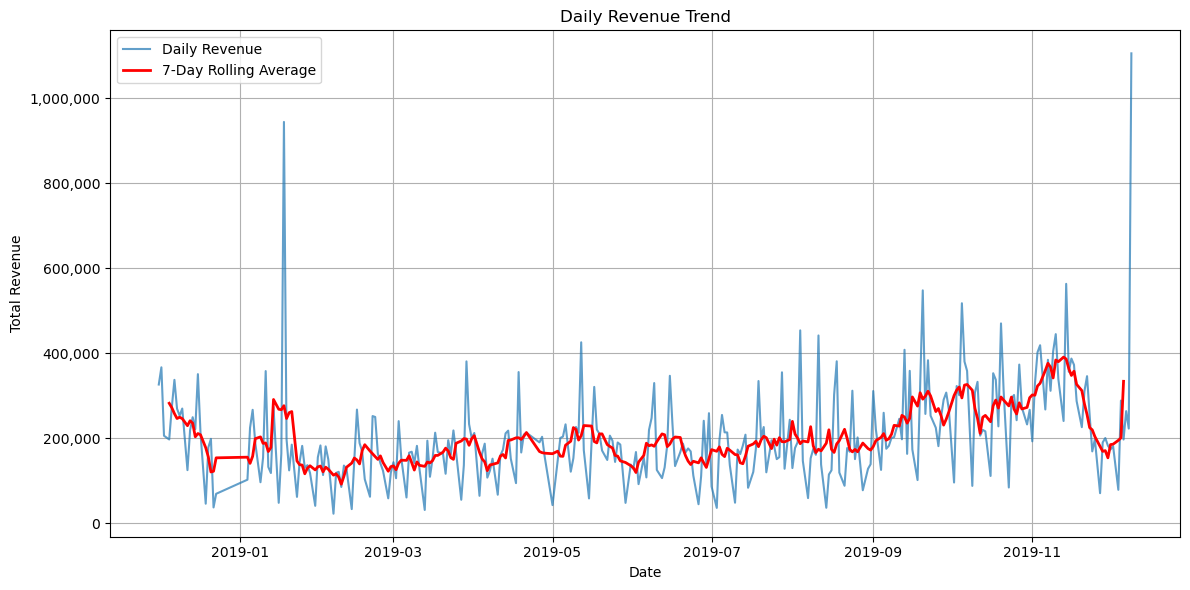

In [37]:
# Melakukan rolling average untuk mendapatkan line chart yang lebih halus dengan less noise agar informasi dari visualisasi lebih mudah dibaca
import matplotlib.ticker as mticker # library untuk mengubah format y-axis dari 1e6 jadi ratusan ribu atau jutaan

# Perform a rolling average to smooth the trend (optional for better visualization)
daily_revenue_smoothed = daily_revenue.rolling(window=7, center=True).mean()
# daily_revenue_smoothed menghitung rata-rata pendapatan selama 7 hari di tanggal terjadinya penjualan 
# Fungsinya menunjukkan grafik yang lebih stabil dibandingkan menggunakan data harian. Bisa dilihat dari garis '7-Day Rolling Average'
# Contoh: terjadi penjualan tanggal 1 sampai 7 Dec. Maka rata-rata pendapatan tgl 4 Dec dihitung dari total 3 hari ke belakang & 3 hari kedepan

# Membuat plot daily revenue trend
plt.figure(figsize=(12, 6))
plt.plot(daily_revenue.index, daily_revenue, label='Daily Revenue', alpha=0.7)
plt.plot(daily_revenue_smoothed.index, daily_revenue_smoothed, label='7-Day Rolling Average', color='red', linewidth=2)
plt.xlabel('Date')
plt.ylabel('Total Revenue')
plt.title('Daily Revenue Trend')
plt.legend()
plt.grid()
plt.gca().yaxis.set_major_formatter(mticker.FuncFormatter(lambda x, _: f'{int(x):,}')) # mengubah format y-axis dari 1e6 jadi ratusan ribu atau jutaan 
plt.tight_layout()
plt.show()

### Conclusion dari trend line rolling average:  
- Ada peningkatan trend rata-rata penjualan di Desember 2019 bila dibandingkan dengan tren rata-rata penjualan di awal data Desember 2018  
- Terjadi penurunan rata-rata penjualan di sekitar akhir Januari 2019 sampai mendekati awal Februari 2019
- Mulai dari Februari 2019 sampai akhir September 2019 trend penjualannya stabil dan termasuk bulan-bulan di mana terjadi titik penjualan terendah
- Trend rata-rata penjualan mulai meningkat lagi di bulan Oktober 2019 hingga Desember 2019
- Dilihat dari trend penjualan di Desember 2018 dan peningkatan trend penjualan mulai Oktober 2019 sampai Desember 2019, ada indikasi terjadi peningkatan karena mendekati libur akhir tahun

### 2. Selanjutnya menentukan trend penjualan lewat linear regression   
Linear Regression akan menunjukkan rata-rata perubahan total pendapatan tiap harinya yang akan ditunjukkan lewat Slope (kemiringan garis). Kemiringan garis ini akan diukur apakah meningkat (hasil slope positif), menurun (hasil slope negatif) atau stagnant (hasil slope = 0).

In [40]:
# Import linregress dari library scipy.stats
from scipy.stats import linregress
# Fungsi ini digunakan untuk menghitung regresi linear, yang memberikan hubungan linier antara dua variabel (jumlah hari penjualan dan daily_revenue). 

# Konversi tanggal menjadi urut angka (numerik) karena regresi linear memerlukan variabel numerik.
time_numeric = range(len(daily_revenue))
# len(daily_revenue): Menghitung jumlah total hari dalam data daily_revenue
# range(len(daily_revenue)): Membuat urutan angka dari 0 hingga jumlah hari (misalnya, 0, 1, 2, ..., n)

# Melakukan regresi linear antara variabel waktu (time_numeric) dan total revenue harian (daily_revenue)
slope, intercept, r_value, p_value, std_err = linregress(time_numeric, daily_revenue)
# slope: Kemiringan garis regresi. Nilai ini menunjukkan tingkat perubahan rata-rata pendapatan harian
# intercept: Nilai titik potong garis regresi dengan sumbu y (pendapatan harian saat waktu = 0)
# r_value: Koefisien korelasi (r), menunjukkan kekuatan hubungan linier antara waktu dan pendapatan
# p_value: Nilai probabilitas untuk menguji signifikansi hubungan. Nilai rendah (< 0.05) menunjukkan hubungan yang signifikan 
# std_err: Error standar dari kemiringan garis (seberapa pasti estimasi slope)

# Interpretasi hasil
trend = "increasing" if slope > 0 else "decreasing" if slope < 0 else "stagnant"

print(f"Trend: {trend}")
print(f"Slope: {slope}")

Trend: increasing
Slope: 418.2913716988953


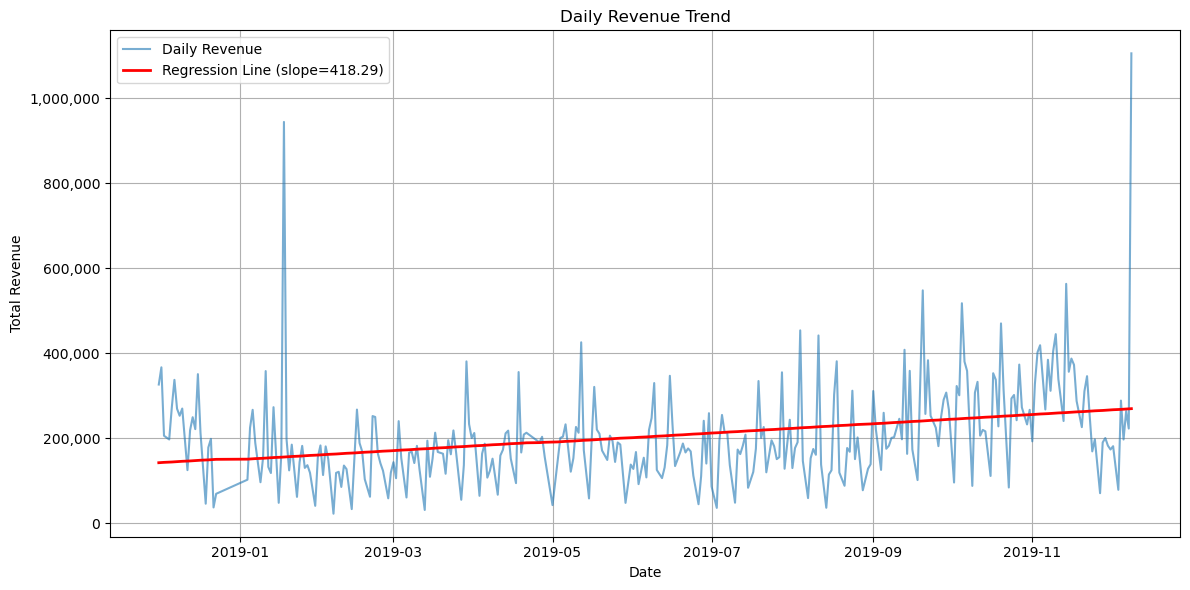

Trend: increasing
Slope: 418.2913716988953


In [41]:
# Visualisasi untuk linear regression untuk menjelaskan trend slope 

# Menghitung garis regresi
regression_line = [slope * x + intercept for x in time_numeric]

# Plot the daily revenue and the regression line
plt.figure(figsize=(12, 6))
plt.plot(daily_revenue.index, daily_revenue, label='Daily Revenue', alpha=0.6)
plt.plot(daily_revenue.index, regression_line, label=f'Regression Line (slope={slope:.2f})', color='red', linewidth=2)
plt.xlabel('Date')
plt.ylabel('Total Revenue')
plt.title('Daily Revenue Trend')
plt.legend()
plt.grid()
plt.gca().yaxis.set_major_formatter(mticker.FuncFormatter(lambda x, _: f'{int(x):,}')) # mengubah format y-axis dari 1e6 jadi ratusan ribu atau jutaan 
plt.tight_layout()
plt.show()

print(f"Trend: {trend}")
print(f"Slope: {slope}")

### Conclusion Linear Regression:
Daily revenue mengalami trend peningkatan dengan kemiringan 418.29 per hari atau revenuenya meningkat sebesar 418.29 per hari 

### Seasonality analysis untuk menghitung total transaksi di hari Senin - Minggu

In [44]:
# Extract hari dari tanggal (0 = Monday, 6 = Sunday)
df_sales['DayOfWeek'] = df_sales['Date'].dt.dayofweek

# Mapping hasil extract tadi dengan nama hari
day_mapping = {0: 'Monday', 1: 'Tuesday', 2: 'Wednesday', 3: 'Thursday', 4: 'Friday', 5: 'Saturday', 6: 'Sunday'}
df_sales['DayName'] = df_sales['DayOfWeek'].map(day_mapping)

# Count total orders per hari
total_orders_per_day = df_sales.groupby('DayName')['TransactionNo'].nunique()
total_orders_per_day

DayName
Friday       3516
Monday       3112
Saturday     3667
Sunday       4212
Thursday     3080
Wednesday    2203
Name: TransactionNo, dtype: int64

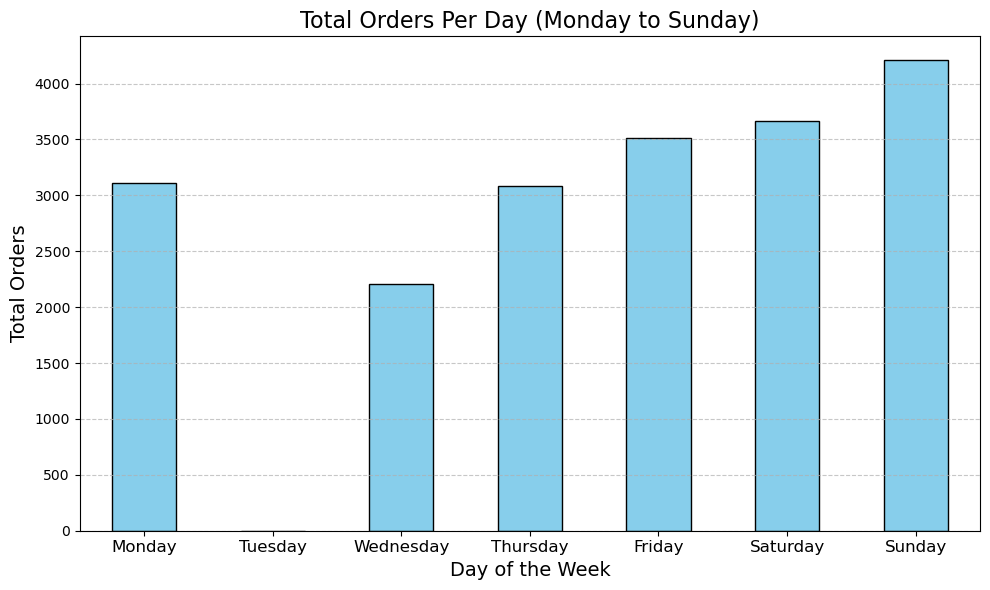

Total orders per day of the week:
DayName
Monday       3112.0
Tuesday         NaN
Wednesday    2203.0
Thursday     3080.0
Friday       3516.0
Saturday     3667.0
Sunday       4212.0
Name: TransactionNo, dtype: float64


In [45]:
# Untuk mengurutkan hari dari Senin ke Minggu
total_orders_per_day = total_orders_per_day.reindex(['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])

# Visualization
plt.figure(figsize=(10, 6))
total_orders_per_day.plot(kind='bar', color='skyblue', edgecolor='black')
plt.title('Total Orders Per Day (Monday to Sunday)', fontsize=16)
plt.xlabel('Day of the Week', fontsize=14)
plt.ylabel('Total Orders', fontsize=14)
plt.xticks(rotation=0, fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# Print results
print("Total orders per day of the week:")
print(total_orders_per_day)

### Dari chart Total Orders Per Day (Monday to Sunday), bisa diambil insight:
- Customer's transaction behaviour -> semakin mendekati weekend, jumlah transaksi makin meningkat dan puncaknya terjadi di hari Minggu
- Ada anomali data yang digunakan untuk analisis, yaitu sama sekali tidak ada data transaksi yang terjadi di hari Selasa

Untuk mengecek anomali di atas, saya coba memfilter df_sales untuk mengambil baris data yang DayOfWeek nya hari Selasa/Tuesday. Hasilnya adalah benar, tidak ada transaksi di hari Selasa.

In [47]:
# Mengecek apakah benar tidak ada transaksi di hari selasa 
tuesday_transactions = df_sales[df_sales['DayOfWeek'] == 'Tuesday'] # Filter transaksi yang terjadi pada hari Selasa

tuesday_transactions.head()

Empty DataFrame
Columns: [TransactionNo, Date, ProductNo, ProductName, Price, Quantity, CustomerNo, Country, total_revenue, order_month, cohort, DayOfWeek, DayName]
Index: []

# Price Elasticity

Price sensitivity atau sensitifitas harga mengacu pada perubahan permintaan pelanggan akibat naik atau turunya harga suatu produk.

Pada bagian ini anda akan diminta untuk melakukan analisis terhadap suatu produk yang penjualannya sangat dipengaruhi oleh harga.

## Pertanyaan

Pertanyaan 1 :   
Produk apa yang paling sering mengalami perubahan harga?   
Hitunglah banyaknya harga unik di setiap produk dan ambil daftar produk yang pernah terjual dengan setidaknya 10 variasi harga yang berbeda.

Price Elasticity akan semakin baik dianalisis ketika lebih banyak variasi harga yang muncul.

Pertanyaan 2 :   
Dari semua produk yang terambil dari step 1, hitung lah korelasi antara harga dengan quantity untuk setiap barang.  
Barang manakah yang memiliki korelasi paling negatif?  

Pertanyaan 3 : 
Buatlah scatter plot antara harga dan quantity untuk barang dari soal sebelumnya.  
Apabila produk tersebut mengalami kenaikan harga, kira-kira apa yang akan terjadi dengan penjualan ?

### (Price Elasticity) Pertanyaan 1 :  
Produk apa yang paling sering mengalami perubahan harga?   
Hitunglah banyaknya harga unik di setiap produk dan ambil daftar produk yang pernah terjual dengan setidaknya 10 variasi harga yang berbeda.

Price Elasticity akan semakin baik dianalisis ketika lebih banyak variasi harga yang muncul.

In [50]:
# Step 1: Menghitung produk yang paling banyak berganti harga
# Caranya menghitung unique Price untuk tiap ProductName
price_changes = df_sales.groupby('ProductName').agg(Unique_Prices=('Price', 'nunique'))

# Mencari produk yang paling banyak berganti harga dengan sort_values descending dan ambil produk yang paling atas / yang paling banyak ganti harga 
most_frequent_price_change = price_changes.sort_values('Unique_Prices', ascending=False).head(1)

# Step 2: Mengidentifikasi produk mana saja yang pernah berganti harga 10 kali atau lebih 
products_with_10_price_variations = price_changes[price_changes['Unique_Prices'] >= 10]

In [51]:
most_frequent_price_change

Unique_Prices
ProductName                 
Chilli Lights             23

In [52]:
# Memfilter untuk mengambil 10 produk yang paling sering berganti harga
top_10_most_frequent_price_change = price_changes.sort_values('Unique_Prices', ascending=False).head(10)
top_10_most_frequent_price_change

Unique_Prices
ProductName                                     
Chilli Lights                                 23
Hot Water Bottle Tea And Sympathy             20
Cook With Wine Metal Sign                     20
Doormat Red Retrospot                         19
Fawn Blue Hot Water Bottle                    19
Gin And Tonic Diet Metal Sign                 19
Pack Of 12 London Tissues                     19
Party Bunting                                 19
Scottie Dog Hot Water Bottle                  19
Doormat New England                           19

In [53]:
total_unique_products = df_sales['ProductName'].nunique()
total_unique_products

3753

In [54]:
products_with_10_price_variations['Unique_Prices'].value_counts()

Unique_Prices
10    231
11    186
12    105
14     52
13     50
15     24
16     22
17     12
18      8
19      7
20      2
23      1
Name: count, dtype: int64

### Jawaban pertanyaan 1:
- Produk yang paling sering mengalami perubahan harga adalah Chilli Lights sebanyak 23 kali berganti harga
- Ada 700 produk yang pernah berganti harga 10 kali atau lebih  

Price Elasticity akan semakin baik dianalisis ketika lebih banyak variasi harga yang muncul.
Kesimpulan: Banyak produk yang Price Elasicitynya baik karena memiliki 10 atau lebih variasi harga  

### (Price Elasticity) Pertanyaan 2 :   
Dari semua produk yang terambil dari step 1, hitung lah korelasi antara harga dengan quantity untuk setiap barang.  
Barang manakah yang memiliki korelasi paling negatif? 

In [57]:
# Memfilter df_sales untuk hanya mencakup produk dengan setidaknya 10 variasi harga
filtered_df_sales = df_sales[df_sales['ProductName'].isin(products_with_10_price_variations.index)]

# Dictionary kosong untuk menyimpan korelasi
correlations = {}

# Loop melalui setiap produk dalam daftar products_with_10_price_variations
for product in products_with_10_price_variations.index:
    # Filter data untuk produk tertentu
    # Memfilter data agar variabel product_data akan berisi data penjualan produk yg ada di dalam filtered_df_sales 
    product_data = filtered_df_sales[filtered_df_sales['ProductName'] == product] 
    
    # Pastikan ada lebih dari satu transaksi agar korelasi dapat dihitung
    if product_data.shape[0] > 1:
        # Hitung korelasi antara Price dan Quantity
        corr = product_data['Price'].corr(product_data['Quantity'])
        # Simpan hasilnya ke dalam dictionary correlation
        correlations[product] = corr

# Pastikan dictionary correlations tidak kosong
if correlations:
    # Cari produk dengan korelasi negatif paling tinggi
    most_negative_corr_product = min(correlations, key=correlations.get)
    result = (most_negative_corr_product, correlations[most_negative_corr_product])
else:
    result = "Tidak ada korelasi yang dapat dihitung."

result

('Set Of 2 Tea Towels Ping Microwave', -0.47773782743109444)

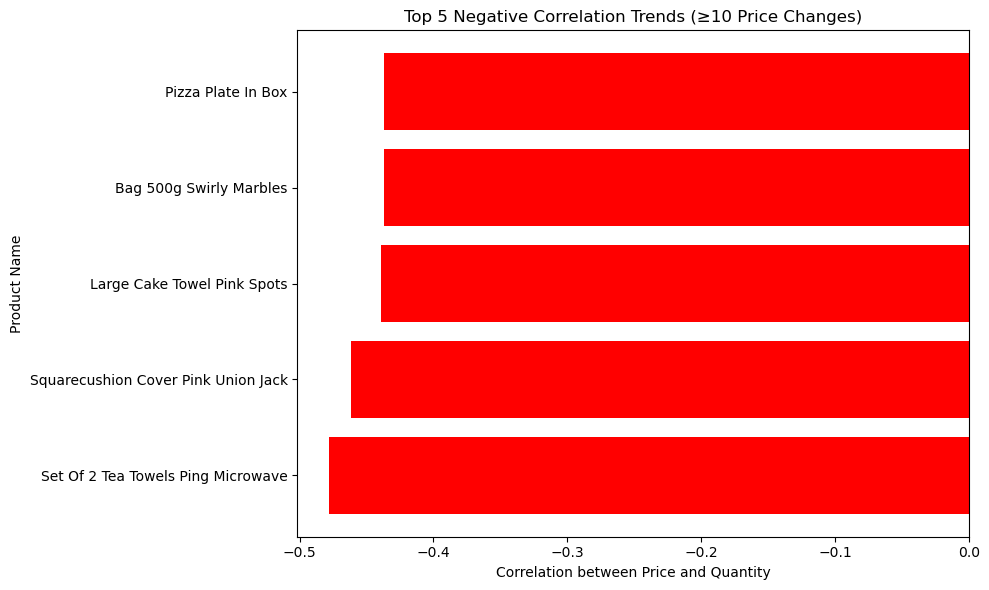

In [58]:
# Memfilter produk dengan negative correlations
negative_correlations = {product: corr for product, corr in correlations.items() if corr < 0}

# Mengurutkan negative correlations dari yang paling besar negativenya 
sorted_negative_correlations = dict(sorted(negative_correlations.items(), key=lambda item: item[1]))

# Filter top 5 product dengan negative correlation 
top_5_negative_correlations = dict(list(sorted_negative_correlations.items())[:5])

# Plot untuk top 10 product dengan negative correlation
plt.figure(figsize=(10, 6))
plt.barh(list(top_5_negative_correlations.keys()), list(top_5_negative_correlations.values()), color='red')
plt.xlabel('Correlation between Price and Quantity')
plt.ylabel('Product Name')
plt.title('Top 5 Negative Correlation Trends (≥10 Price Changes)')
plt.tight_layout()
plt.show()

In [59]:
# Menghitung berapa banyak customer yang memiliki negative correlation
count_negative_correlations = len(sorted_negative_correlations) 
count_negative_correlations

552

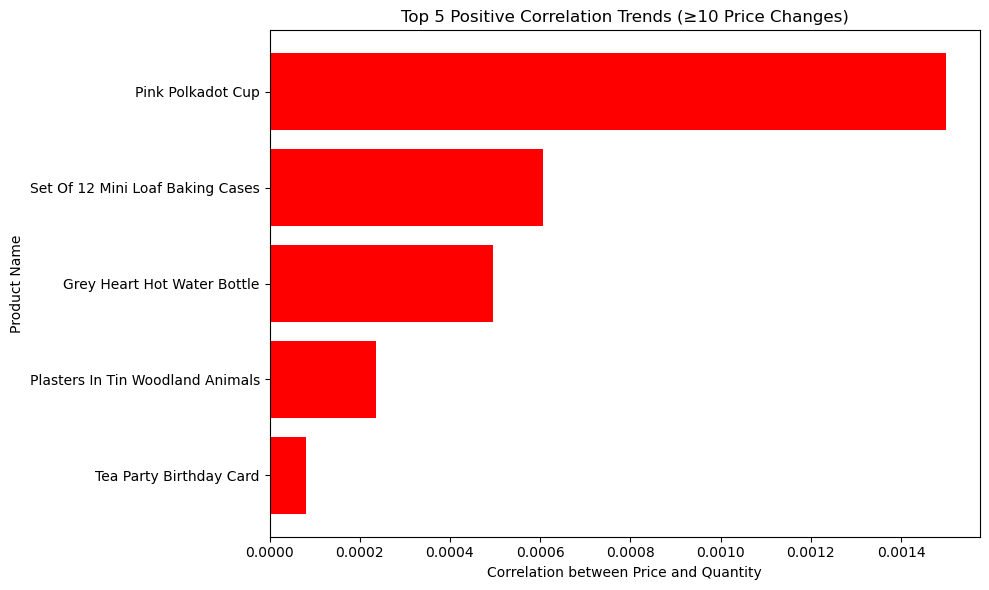

In [60]:
# Memfilter produk dengan positive correlations
positive_correlations = {product: corr for product, corr in correlations.items() if corr > 0}

# Mengurutkan negative correlations dari yang paling besar nilai positivenya
sorted_positive_correlations = dict(sorted(positive_correlations.items(), key=lambda item: item[1]))

# Filter top 5 product dengan positive correlation 
top_5_positive_correlations = dict(list(sorted_positive_correlations.items())[:5])

# Plot untuk top 10 product dengan negative correlation
plt.figure(figsize=(10, 6))
plt.barh(list(top_5_positive_correlations.keys()), list(top_5_positive_correlations.values()), color='red')
plt.xlabel('Correlation between Price and Quantity')
plt.ylabel('Product Name')
plt.title('Top 5 Positive Correlation Trends (≥10 Price Changes)')
plt.tight_layout()
plt.show()

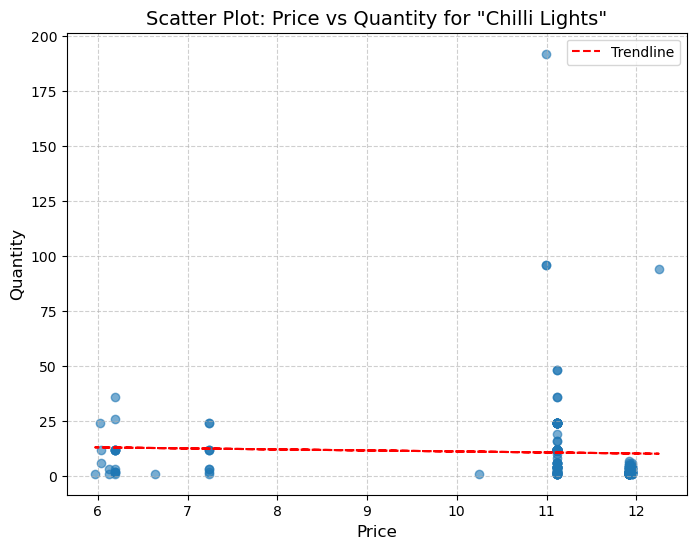

In [61]:
# Filter produk Chilli Lights untuk melihat korelasi Price vs Qty untuk produk yang paling sering berganti harga
top_1_most_frequent_price_change = filtered_df_sales[filtered_df_sales['ProductName'] == 'Chilli Lights']

# Scatter plot untuk produk Chilli Lights
plt.figure(figsize=(8, 6))
plt.scatter(product_data['Price'], product_data['Quantity'], alpha=0.6)

# Menambahkan trendline
z = np.polyfit(product_data['Price'], product_data['Quantity'], 1)
p = np.poly1d(z)
plt.plot(product_data['Price'], p(product_data['Price']), "r--", label="Trendline")
plt.legend()

plt.title(f'Scatter Plot: Price vs Quantity for "Chilli Lights"', fontsize=14)
plt.xlabel('Price', fontsize=12)
plt.ylabel('Quantity', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

In [62]:
# Menghitung berapa banyak customer yang memiliki positive correlation
count_positive_correlations = len(sorted_positive_correlations) 
count_positive_correlations

148

In [63]:
# Mengubah data series correlations menjadi dataframe
df_correlations = pd.DataFrame([correlations]) 
df_correlations = df_correlations.T 
df_correlations.reset_index(inplace=True)
df_correlations.columns = ['ProductName', 'price_quantity_correlation']
df_correlations

ProductName  price_quantity_correlation
0        12 Message Cards With Envelopes                   -0.080832
1          12 Pencil Small Tube Woodland                   -0.040362
2    12 Pencils Small Tube Red Retrospot                    0.008916
3    15cm Christmas Glass Ball 20 Lights                   -0.191617
4                20 Dolly Pegs Retrospot                   -0.015136
..                                   ...                         ...
695    World War 2 Gliders Asstd Designs                    0.023541
696            Zinc Folkart Sleigh Bells                   -0.123422
697    Zinc Heart Lattice T-Light Holder                   -0.132540
698          Zinc Metal Heart Decoration                    0.038028
699      Zinc Willie Winkie Candle Stick                   -0.043880

[700 rows x 2 columns]

### Jawaban pertanyaan 2: 
'Set Of 2 Tea Towels Ping Microwave' memiliki korelasi paling negatif sebesar -0.47773782743109444. Artinya untuk produk 'Set Of 2 Tea Towels Ping Microwave' memiliki hubungan negatif antara harga dan quantity penjualan dalam kata lain penjualan produk sensitif terhadap perubahan harga.

### Pertanyaan 3 : 
Buatlah scatter plot antara harga dan quantity untuk barang dari soal sebelumnya.  
Apabila produk tersebut mengalami kenaikan harga, kira-kira apa yang akan terjadi dengan penjualan ?

Jawaban: Bila produk Set Of 2 Tea Towels Ping Microwave mengalami kenaikan harga, maka kuantitas penjualan akan menurun. Bisa dilihat dari jumlah penjualan yang makin sedikit Quantitynya saat titik scatter plot semakin ke kanan atau dalam kata lain harganya semakin mahal. Bisa juga dilihat dari trend line yang menunjukkan semakin ke kanan atau semakin mahal harganya, maka semakin menurun posisi trend line yang berarti semakin sedikit Quantity penjualan.

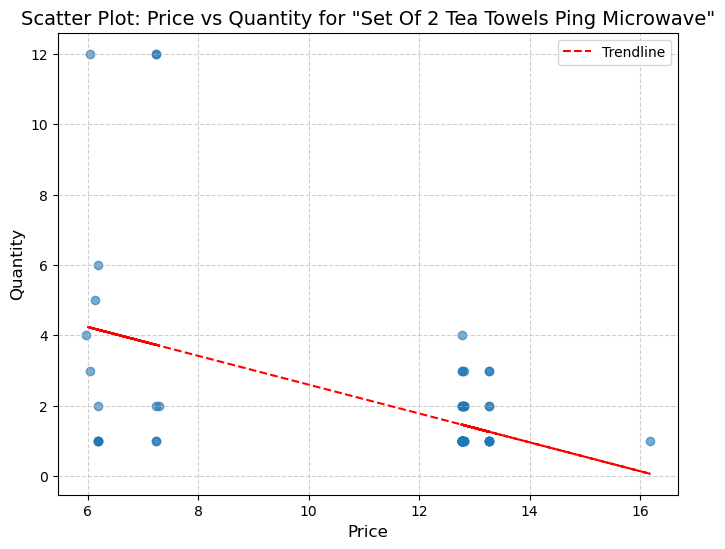

In [66]:
# Filter data df_sales untuk menunjukkan produk yang memiliki korelasi negative Price vs Qty paling tinggi sesuai variabel most_negative_corr_product
product_data = filtered_df_sales[filtered_df_sales['ProductName'] == most_negative_corr_product]

# Scatter plot antara Price dan Quantity
plt.figure(figsize=(8, 6))
plt.scatter(product_data['Price'], product_data['Quantity'], alpha=0.6)

# Add trendline
z = np.polyfit(product_data['Price'], product_data['Quantity'], 1)
p = np.poly1d(z)
plt.plot(product_data['Price'], p(product_data['Price']), "r--", label="Trendline")
plt.legend()

plt.title(f'Scatter Plot: Price vs Quantity for "{most_negative_corr_product}"', fontsize=14)
plt.xlabel('Price', fontsize=12)
plt.ylabel('Quantity', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

# Basket Size Analysis

Ketika seorang pelanggan e-commerce menekan "add to cart", maka barang tersebut akan disimpan dalam sebuah "basket".  
Ketika melakukan checkout, maka semua barang dalam basket tersebut akan diproses dan dikirimkan.  
Ukuran dari basket dapat diukur melalui nilai GMV (Gross merchandise volume) yang merupakan total harga barang yang dibeli.  
Contoh : 
Pada tanggal 1 januari 2012
Tuan A membeli 1 shampoo seharga 15ribu dan 2 sabun seharga 20ribu masing-masing. Maka basket size tuan A adalah 55ribu rupiah.
Nyonya B hanya membeli 1 cemilan seharga 20 ribu, maka basket size dari nyonya B adalah 20 ribu rupiah.
Berarti total GMV ecommerce pada 1 januari 2012 adalah 75ribu rupiah, dengan rata-rata basket size sebesar 37.5 ribu rupiah per basket.

## Pertanyaan
1. Hitung rata-rata basket size dari seluruh transaksi per harinya, apakah konsisten atau ada perubahan ?
2. Apakah ada perbedaan ukuran basket dari negara yang berbeda ?

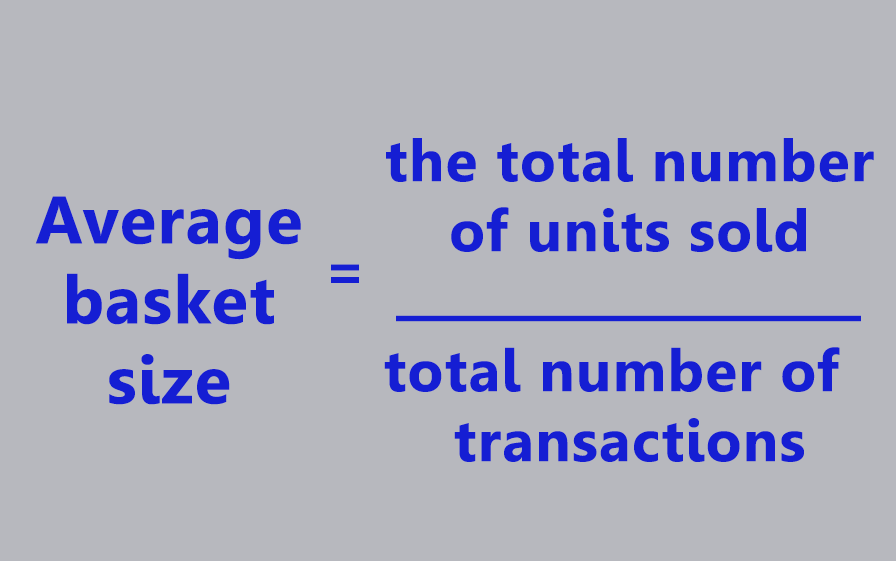

### (Basket Size Analysis) Pertanyaan 1: Hitung rata-rata basket size dari seluruh transaksi per harinya, apakah konsisten atau ada perubahan ?
Jawaban:  
Ada perubahan tapi tidak terlalu signifikan. Bisa dilihat dari kemiringan trend slopenya hanya 0,21. 

In [69]:
# Sesuai rumus Average Basket Size, maka perlu dicari dulu daily total number of units sold & total number of transactions

# Step 1: menghitung kuantitas penjualan per hari 
quantity_per_day = df_sales.groupby('Date').agg(daily_quantity=('Quantity', 'sum'))

# Step 2: menghitung jumlah transaksi terjadi tiap harinya dilihat dari dari nomor transaksi unik per harinya
trx_per_day = df_sales.groupby('Date').agg(daily_trx_number=('TransactionNo', 'nunique'))

# Step 3: membagi total number of units sold dengan total number of transactions
abs_per_day = quantity_per_day['daily_quantity'] / trx_per_day['daily_trx_number']

In [70]:
# Konversi tanggal menjadi urut angka (numerik) karena regresi linear memerlukan variabel numerik.
time_numeric = range(len(abs_per_day))

slope, intercept, r_value, p_value, std_err = linregress(time_numeric, abs_per_day)

# Interpretasi hasil
trend = "increasing" if slope > 0 else "decreasing" if slope < 0 else "stagnant"

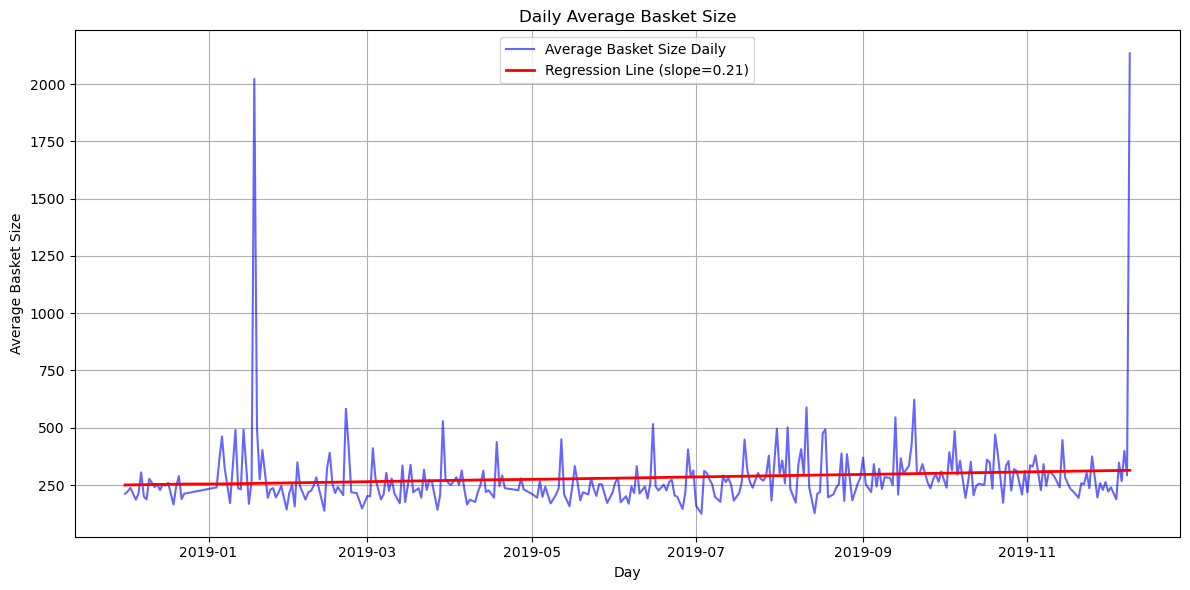

Trend: increasing
Slope: 0.2105827411559216


In [71]:
# Visualisasi disertai linear regression untuk menjelaskan trend Average Basket Size

# Menghitung garis regresi
regression_line = [slope * x + intercept for x in time_numeric]

plt.figure(figsize=(12, 6))
plt.plot(abs_per_day.index, abs_per_day, label='Average Basket Size Daily', alpha=0.6, color='b')
plt.plot(abs_per_day.index, regression_line, label=f'Regression Line (slope={slope:.2f})', color='red', linewidth=2)
plt.title('Daily Average Basket Size')
plt.xlabel('Day')
plt.ylabel('Average Basket Size')
plt.grid()
plt.legend()
plt.tight_layout()
plt.show()

print(f"Trend: {trend}")
print(f"Slope: {slope}")

### (Basket Size Analysis) Pertanyaan 2: Apakah ada perbedaan ukuran basket dari negara yang berbeda ?  
Jawaban:  
Ya. Ada perbedaan ukuran basket size di tiap negara berbeda dengan perbedaan paling mencolok dari ABS milik Netherland yang paling tinggi nilainya melebihi 2000 rata-rata basket size.

In [73]:
# Step 1: mencari total unit sold dari tiap negara
total_unit_sold = df_sales.groupby('Country').agg(units_sold=('Quantity', 'sum'))
total_unit_sold = total_unit_sold.sort_values('units_sold', ascending=False)

# Step 2: mencari total number of transactions dari tiap negara
total_number_transaction = df_sales.groupby('Country').agg(total_transaction=('TransactionNo', 'count'))
total_number_transaction = total_number_transaction.sort_values('total_transaction', ascending=False)

In [74]:
# Mencari ABS dengan rumus total unit sold per country / total number of transaction per country
country_average_basket_size = total_unit_sold['units_sold'] / total_number_transaction['total_transaction']

country_average_basket_size = country_average_basket_size.sort_values(ascending=False)

country_average_basket_size

Country
Sweden                  87.860294
Netherlands             86.343078
Japan                   77.308605
Australia               52.577560
Czech Republic          27.916667
Singapore               24.344186
Denmark                 21.004902
Lithuania               18.823529
EIRE                    18.795184
Norway                  18.640777
Canada                  18.413333
Finland                 15.583090
Bahrain                 15.294118
Hong Kong               14.973856
United Arab Emirates    14.641791
Channel Islands         13.529032
Switzerland             13.385150
Israel                  12.773743
Germany                 11.759375
France                  11.411431
USA                     11.389513
Brazil                  11.387097
Greece                  11.328358
Italy                   11.057692
Spain                    9.849120
United Kingdom           9.770141
Poland                   9.473988
Belgium                  9.465497
Portugal                 9.101197
Saudi 

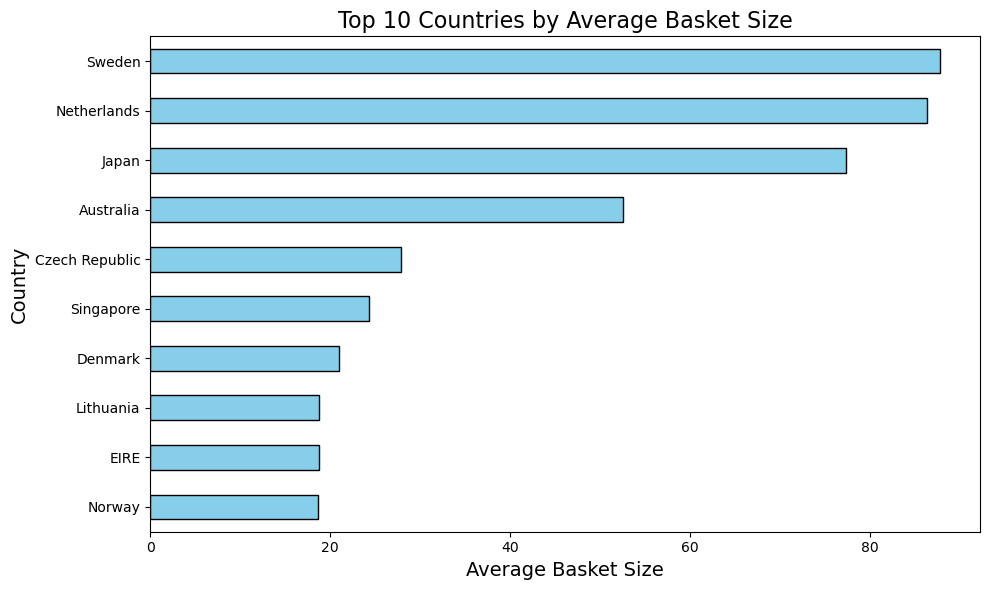

In [75]:
# Visualization: Top 10 Countries by Average Basket Size
top_countries = country_average_basket_size.head(10)
plt.figure(figsize=(10, 6))
top_countries.plot(kind='barh', color='skyblue', edgecolor='black')
plt.title('Top 10 Countries by Average Basket Size', fontsize=16)
plt.xlabel('Average Basket Size', fontsize=14)
plt.ylabel('Country', fontsize=14)
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

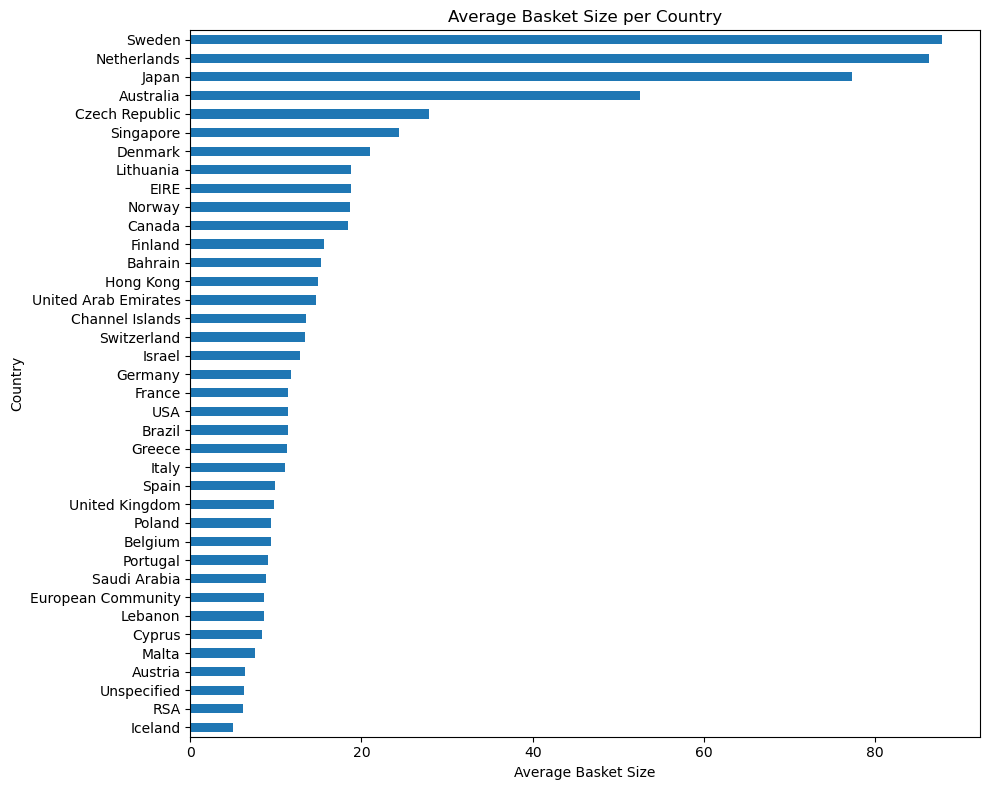

In [76]:
# Visualisasi data
country_average_basket_size.plot(kind='barh', figsize=(10, 8), legend=False)

plt.title('Average Basket Size per Country')
plt.xlabel('Average Basket Size')
plt.ylabel('Country')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

In [77]:
df_sales.head()

TransactionNo       Date ProductNo                          ProductName  \
0        581482 2019-12-09     22485        Set Of 2 Wooden Market Crates   
1        581475 2019-12-09     22596  Christmas Star Wish List Chalkboard   
2        581475 2019-12-09     23235             Storage Tin Vintage Leaf   
3        581475 2019-12-09     23272    Tree T-Light Holder Willie Winkie   
4        581475 2019-12-09     23239    Set Of 4 Knick Knack Tins Poppies   

   Price  Quantity  CustomerNo         Country  total_revenue order_month  \
0  21.47        12     17490.0  United Kingdom         257.64     2019-12   
1  10.65        36     13069.0  United Kingdom         383.40     2019-12   
2  11.53        12     13069.0  United Kingdom         138.36     2019-12   
3  10.65        12     13069.0  United Kingdom         127.80     2019-12   
4  11.94         6     13069.0  United Kingdom          71.64     2019-12   

    cohort  DayOfWeek DayName  
0  2019-06          0  Monday  
1  2018-12          0  Monday  
2  2018-12          0  Monday  
3  2018-12          0  Monday  
4  2018-12          0  Monday

In [78]:
sum_cust = df_sales['CustomerNo'].nunique()
sum_cust

4718

In [79]:
sum_trx = df_sales['TransactionNo'].nunique()
sum_trx

19790

In [80]:
sum_qty = df_sales['Quantity'].sum()
sum_qty

5591498

In [81]:
sum_total_revenue = df_sales['total_revenue'].sum()
sum_total_revenue

62965974.33999998

# Crucial Question

Ini adalah 5 pertanyaan utama yang ditanyakan oleh pembuat dataset sales ini.  
Anda dapat menggunakan analisis yang sudah dikerjakan pada bagian sebelumnya, ataupun melakukan analisis baru untuk menjawab pertanyaan dibawah.

1. How was the sales trend over the months?
2. What are the most frequently purchased products?
3. How many products does the customer purchase in each transaction?
4. What are the most profitable segment customers?
5. Based on your findings, what strategy could you recommend to the business to gain more profit?

### (Crucial Question) Pertanyaan 1: How was the sales trend over the months?

Jawaban:  
- Sales trend selama periode Desember 2018 - Agustus 2019 stabil dengan revenue total sekitar 4.3jt sampai 4.7jt terkecuali bulan February 2019 dan April 2019 yang total revenuenya menurun menjadi sekitar 3.3jt - 3.5jt
- Sales trend mendekati akhir tahun 2019, lebih tepatnya mulai September 2019, menunjukkan adanya peningkatan sales trend dengan total penjualan paling tinggi terjadi di bulan November 2019
- Penurunan sales trend bulan Desember 2019 diakibatkan data sales hanya memuat penjualan Desember 2019 dari tanggal 1 sampai 10 saja.

Penurunan bulan February 2019 dan April 2019 perlu diteliti lagi penyebabnya  
Kenaikan September 2019 - November 2019 perlu diteliti lagi penyebabnya

In [85]:
# Menambahkan kolom bulan menggunakan order_purchase_timestamp sebagai acuan 
df_sales['month_year'] = df_sales['Date'].dt.to_period('M')
df_sales

TransactionNo       Date ProductNo  \
0             581482 2019-12-09     22485   
1             581475 2019-12-09     22596   
2             581475 2019-12-09     23235   
3             581475 2019-12-09     23272   
4             581475 2019-12-09     23239   
...              ...        ...       ...   
536320        536585 2018-12-01     37449   
536321        536590 2018-12-01     22776   
536322        536590 2018-12-01     22622   
536323        536591 2018-12-01     37449   
536324        536597 2018-12-01     22220   

                                ProductName  Price  Quantity  CustomerNo  \
0             Set Of 2 Wooden Market Crates  21.47        12     17490.0   
1       Christmas Star Wish List Chalkboard  10.65        36     13069.0   
2                  Storage Tin Vintage Leaf  11.53        12     13069.0   
3         Tree T-Light Holder Willie Winkie  10.65        12     13069.0   
4         Set Of 4 Knick Knack Tins Poppies  11.94         6     13069.0   
...                                     ...    ...       ...         ...   
536320   Ceramic Cake Stand + Hanging Cakes  20.45         2     17460.0   
536321         Sweetheart 3 Tier Cake Stand  20.45         1     13065.0   
536322       Box Of Vintage Alphabet Blocks  20.45         2     13065.0   
536323   Ceramic Cake Stand + Hanging Cakes  20.45         1     14606.0   
536324     Cake Stand Lovebird 2 Tier White  20.45         1     18011.0   

               Country  total_revenue order_month   cohort  DayOfWeek  \
0       United Kingdom         257.64     2019-12  2019-06          0   
1       United Kingdom         383.40     2019-12  2018-12          0   
2       United Kingdom         138.36     2019-12  2018-12          0   
3       United Kingdom         127.80     2019-12  2018-12          0   
4       United Kingdom          71.64     2019-12  2018-12          0   
...                ...            ...         ...      ...        ...   
536320  United Kingdom          40.90     2018-12  2018-12          5   
536321  United Kingdom          20.45     2018-12  2018-12          5   
536322  United Kingdom          40.90     2018-12  2018-12          5   
536323  United Kingdom          20.45     2018-12  2018-12          5   
536324  United Kingdom          20.45     2018-12  2018-12          5   

         DayName month_year  
0         Monday    2019-12  
1         Monday    2019-12  
2         Monday    2019-12  
3         Monday    2019-12  
4         Monday    2019-12  
...          ...        ...  
536320  Saturday    2018-12  
536321  Saturday    2018-12  
536322  Saturday    2018-12  
536323  Saturday    2018-12  
536324  Saturday    2018-12  

[527765 rows x 14 columns]

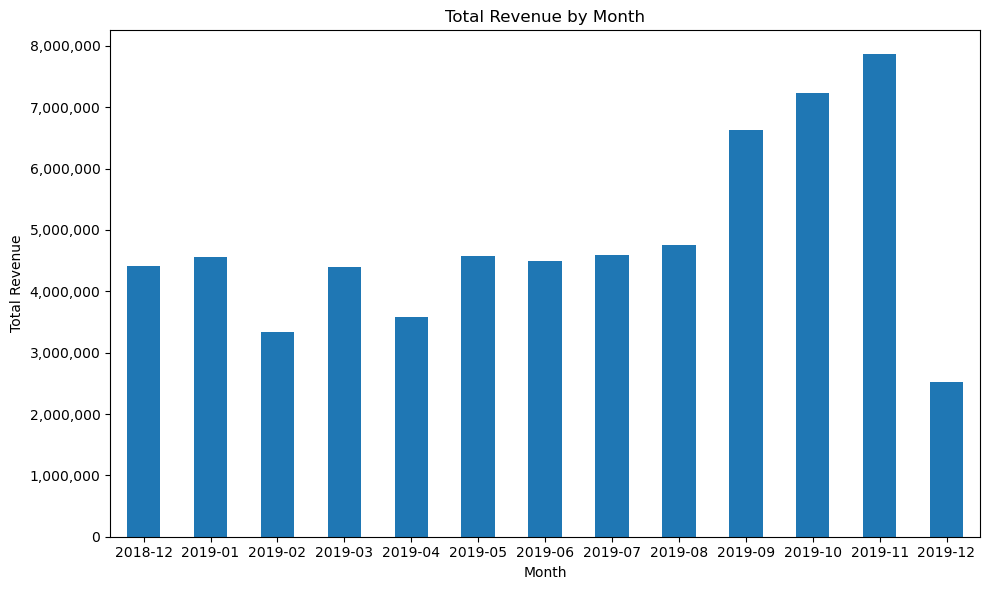

In [86]:
# Grouping data by month_year untuk mengkalkulasi total_revenue per bulan
monthly_revenue = df_sales.groupby('month_year')['total_revenue'].sum()

plt.figure(figsize=(10, 6))
monthly_revenue.plot(kind='bar')
plt.title('Total Revenue by Month')
plt.xlabel('Month')
plt.ylabel('Total Revenue')
plt.xticks(rotation=0)
plt.gca().yaxis.set_major_formatter(mticker.FuncFormatter(lambda x, _: f'{int(x):,}'))
plt.tight_layout()
plt.show()

In [87]:
# Convert Series jadi DataFrame
monthly_revenue = monthly_revenue.reset_index()

# Rename kolom untuk lebih jelas
monthly_revenue.columns = ['month_year', 'total_revenue']

monthly_revenue

month_year  total_revenue
0     2018-12     4415415.52
1     2019-01     4559856.37
2     2019-02     3335017.18
3     2019-03     4398401.60
4     2019-04     3589497.88
5     2019-05     4578965.08
6     2019-06     4494730.81
7     2019-07     4593867.06
8     2019-08     4758356.02
9     2019-09     6628303.06
10    2019-10     7237417.36
11    2019-11     7861197.12
12    2019-12     2514949.28

In [88]:
# Menghitung persentase perubahan total revenue tiap bulannya
monthly_revenue["percentage_change"] = monthly_revenue["total_revenue"].pct_change() * 100
monthly_revenue

month_year  total_revenue  percentage_change
0     2018-12     4415415.52                NaN
1     2019-01     4559856.37           3.271286
2     2019-02     3335017.18         -26.861355
3     2019-03     4398401.60          31.885426
4     2019-04     3589497.88         -18.390856
5     2019-05     4578965.08          27.565616
6     2019-06     4494730.81          -1.839592
7     2019-07     4593867.06           2.205610
8     2019-08     4758356.02           3.580621
9     2019-09     6628303.06          39.298174
10    2019-10     7237417.36           9.189596
11    2019-11     7861197.12           8.618817
12    2019-12     2514949.28         -68.008062

In [89]:
# Filter data hari berjalan, untuk mencari tau berapa hari berjalan di Desember 2019 
december_2019_data = df_sales[(df_sales['Date'] >= '2019-12-01') & (df_sales['Date'] <= '2019-12-31')]
december_2019_date_count = december_2019_data['Date'].nunique()

december_2019_date_count
# Jawaban: df_sales hanya memuat 8 hari data transaksi di Desember 2019
# Jawaban ini berpengaru terhadap penurunan total_revenue di bulan Desember 2019

8

### (Crucial Question) Pertanyaan 2: What are the most frequently purchased products?
Jawaban:  
Top 5 product yang paling sering dibeli oleh customer: 
- Paper Craft Little Birdie
- Medium Ceramic Top Storage Jar
- Popcorn Holder
- World War 2 Gliders Asstd Designs
- Jumbo Bag Red Retrospot 

In [91]:
# Group by ProductName dan sum Quantitynya
product_quantities = df_sales.groupby('ProductName')['Quantity'].sum().sort_values(ascending=False).head()

product_quantities

ProductName
Paper Craft Little Birdie            80995
Medium Ceramic Top Storage Jar       78033
Popcorn Holder                       56921
World War 2 Gliders Asstd Designs    55047
Jumbo Bag Red Retrospot              48478
Name: Quantity, dtype: int64

In [92]:
# Mengelompokkan data berdasarkan hari dan menghitung total order value
product_quantity_sold = df_sales.groupby('ProductName').agg(quantity_sold=('Quantity', 'sum'))
product_quantity_sold = product_quantity_sold.sort_values('quantity_sold', ascending=False).reset_index()

top_5_product_quantity_sold = product_quantity_sold.head()
top_5_product_quantity_sold

ProductName  quantity_sold
0          Paper Craft Little Birdie          80995
1     Medium Ceramic Top Storage Jar          78033
2                     Popcorn Holder          56921
3  World War 2 Gliders Asstd Designs          55047
4            Jumbo Bag Red Retrospot          48478

### (Crucial Question) Pertanyaan 3: How many products does the customer purchase in each transaction?
Jawaban:   
Untuk menjawab pertanyaan di atas cukup sulit karena banyaknya produk per transaksi itu sangat beragam jumlahnya dan penyebaran data quantity per TransactionNo lumayan luas (bisa dilihat di boxplot). Namun kalau dilihat dari rata-rata atau Average Basket Size dari semua transaksi, maka rata-rata jumlah produk yang ditransaksikan customer di tiap TransactionNo adalah sebesar 282 produk. Angka rata-rata 282 tersebut pun sangat bervariasi tergantung pada kondisi tiap transaksi.

Selain melihat dari rata-ratanya, kita bisa melihat juga dari describe data yang menunjukkan Q1 sampai Q3 kuantitas pembelian customer di setiap transaksi yang artinya setidaknya 50% dari data df_sales yang dianalisis (sekitar 263rb transaksi) memiliki ABS berkisar 71-298 pcs per transaksi. 

In [94]:
# Kalkulasi total produk yang ditransaksikan per transaksi
df_transaction_summary = df_sales.groupby('TransactionNo')['Quantity'].sum().reset_index()

# Menampilkan describe variabel df_transaction_summary untuk melihat meannya atau rata-rata total produk per transaksi 
df_transaction_summary

TransactionNo  Quantity
0            536365        40
1            536366        12
2            536367        83
3            536368        15
4            536369         3
...             ...       ...
19785        581583        76
19786        581584       120
19787        581585       278
19788        581586        66
19789        581587       105

[19790 rows x 2 columns]

In [95]:
df_transaction_summary.describe()

Quantity
count  19790.000000
mean     282.541587
std      962.577651
min        1.000000
25%       71.000000
50%      153.000000
75%      298.000000
max    80995.000000

In [96]:
df_transaction_summary = df_transaction_summary['Quantity'].value_counts().sort_values(ascending=False).reset_index()
df_transaction_summary

Quantity  count
0            1    212
1           12    206
2           24    194
3            2    175
4           48    174
...        ...    ...
1477      1516      1
1478       850      1
1479       817      1
1480      1263      1
1481       692      1

[1482 rows x 2 columns]

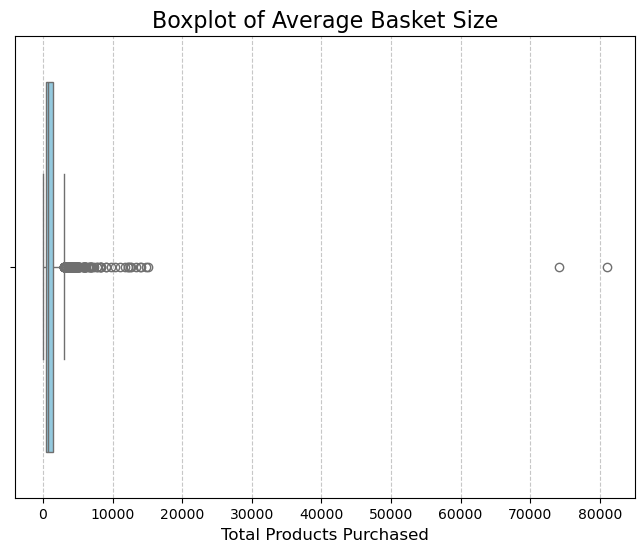

In [97]:
# PBoxplot untuk memvisualisasikan penyebaran dari average basket size
plt.figure(figsize=(8, 6))
sns.boxplot(x=df_transaction_summary['Quantity'], color='skyblue')
plt.title('Boxplot of Average Basket Size', fontsize=16)
plt.xlabel('Total Products Purchased', fontsize=12)
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.show()

# Hasilnya bisa terlihat 50% penyebaran data ABS terkonsentrasi di sekitar 71-298 pcs per transaksi.

### (Crucial Question) Pertanyaan 4: What are the most profitable segment customers?
Untuk menjawab pertanyaan ini saya akan menggunakan segmentasi RFM Analysis. RFM Analysis akan mengkategorikan customer yang paling profitable (waktu transaksi dekat, paling sering bertransaksi & value transaksi tinggi) sebagai Top Customer. Jadi jawaban profitable segment cutomer bisa dilihat dari kategori Top Customer, hasil dari RFM Analysis.

# RFM Analysis

## Recency Calculation

Mencari tau terakhir kali customer bertransaksi/berbelanja di toko kita

In [101]:
# Recency
latest_date = df_sales['Date'].max() # Mencari kapan terakhir customer berbelanja (seperti di atas)
latest_trx_per_customer = df_sales.sort_values('Date').groupby('CustomerNo').tail(1) # Mencari kapan terakhir customer berbelanja

latest_trx_per_customer['days_to_today'] = latest_date - latest_trx_per_customer['Date'] # Ini untuk ngurangin hasil 2 script di atas
latest_trx_per_customer['days_to_today'] # Meng call back hasil hitungan script di atas

534517   373 days
533622   373 days
533932   373 days
534015   373 days
533767   373 days
           ...   
908        0 days
1023       0 days
808        0 days
1074       0 days
0          0 days
Name: days_to_today, Length: 4718, dtype: timedelta64[ns]

In [102]:
latest_trx_per_customer.head()

TransactionNo       Date ProductNo                   ProductName  \
534517        536534 2018-12-01     22834   Hand Warmer Babushka Design   
533622        536403 2018-12-01     22867       Hand Warmer Bird Design   
533932        536420 2018-12-01     22969  Homemade Jam Scented Candles   
534015        536464 2018-12-01    90200D      Pink Sweetheart Bracelet   
533767        536409 2018-12-01     20717        Strawberry Shopper Bag   

        Price  Quantity  CustomerNo         Country  total_revenue  \
534517  12.40        12     15350.0  United Kingdom         148.80   
533622  12.15        96     12791.0     Netherlands        1166.40   
533932  11.74        12     16583.0  United Kingdom         140.88   
534015  14.61         3     17968.0  United Kingdom          43.83   
533767  11.53         1     17908.0  United Kingdom          11.53   

       order_month   cohort  DayOfWeek   DayName month_year days_to_today  
534517     2018-12  2018-12          5  Saturday    2018-12      373 days  
533622     2018-12  2018-12          5  Saturday    2018-12      373 days  
533932     2018-12  2018-12          5  Saturday    2018-12      373 days  
534015     2018-12  2018-12          5  Saturday    2018-12      373 days  
533767     2018-12  2018-12          5  Saturday    2018-12      373 days

In [103]:
# Mengubah dtype: timedelta64 menjadi integer
latest_trx_per_customer['days_to_today'] = latest_trx_per_customer['days_to_today'].dt.days

<Axes: ylabel='Frequency'>

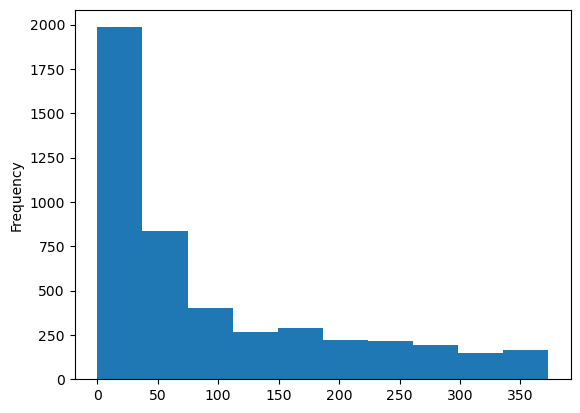

In [104]:
# Membuat plot untuk melihat jumlah frekuensi per CustomerNo berbelanja / terakhir kali seorang customer berbelanja 
df_recency = latest_trx_per_customer[['CustomerNo','days_to_today']]
df_recency['days_to_today'].plot(kind='hist')

In [105]:
# Menentukan customer yang transaksi baru-baru ini, sudah cukup lama, atau sudah lama sekali tidak bertransaksi
# Menentukannya dengan qcut
df_recency['R_score'] = pd.qcut(df_recency['days_to_today'],3,labels=['Recent','Normal','Long'])

# qcut = Quartal Cut = membagi data kita menjadi beberapa Quartile(in this case dibagi 3)
df_recency

C:\Users\benny\AppData\Local\Temp\ipykernel_17412\151408114.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_recency['R_score'] = pd.qcut(df_recency['days_to_today'],3,labels=['Recent','Normal','Long'])


CustomerNo  days_to_today R_score
534517     15350.0            373    Long
533622     12791.0            373    Long
533932     16583.0            373    Long
534015     17968.0            373    Long
533767     17908.0            373    Long
...            ...            ...     ...
908        12423.0              0  Recent
1023       17497.0              0  Recent
808        15492.0              0  Recent
1074       14498.0              0  Recent
0          17490.0              0  Recent

[4718 rows x 3 columns]

In [106]:
# Melihat data hasil Qcut secara statistik
df_recency.groupby('R_score').agg({'days_to_today':['min','max','mean','median','count']})

C:\Users\benny\AppData\Local\Temp\ipykernel_17412\2637699410.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_recency.groupby('R_score').agg({'days_to_today':['min','max','mean','median','count']})


days_to_today                              
                  min  max        mean median count
R_score                                            
Recent              0   26   11.697891   10.0  1612
Normal             28  100   56.235486   54.0  1533
Long              101  373  221.123967  212.0  1573

## Volume Calculation

Menghitung ABS setiap customer atau budget spent by each customers

<Axes: ylabel='Frequency'>

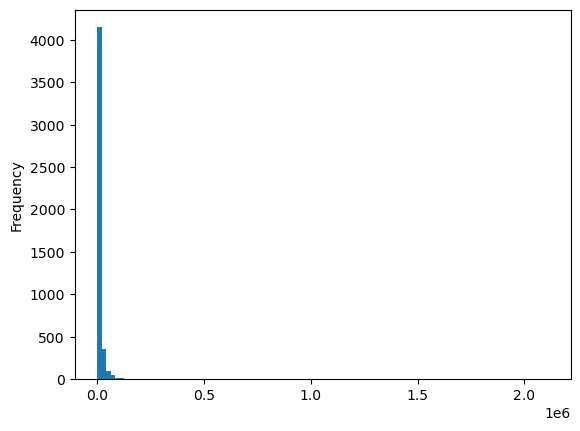

In [108]:
df_volume = df_sales.groupby('CustomerNo').agg({'total_revenue':'sum'}) # Menghitung volume transaksi per CustomerID
df_volume['total_revenue'].plot(kind='hist',bins=100) # Memvisualisasi penghitungan volume transaksi per CustomerID dalam bentuk histplot

In [109]:
# Sama seperti langkah df_frequency sebelumnya, untuk df_volume membagi customer dalam 3 quartile / 3 kategori dengan labet Low, Medium dan High 
# Metodenya juga sama menggunakan Qcut
df_volume['V_score'] = pd.qcut(df_volume['total_revenue'],3,labels=['Low','Medium','High'])
df_volume

total_revenue V_score
CustomerNo                       
12004.0           1509.60     Low
12006.0             24.76     Low
12008.0           5689.57  Medium
12013.0             69.96     Low
12024.0            149.52     Low
...                   ...     ...
18280.0            623.26     Low
18281.0            576.58     Low
18282.0           1044.86     Low
18283.0          12114.61    High
18287.0          18139.56    High

[4718 rows x 2 columns]

In [110]:
# Melihat data hasil Qcut secara statistik
df_volume.groupby('V_score').agg({'total_revenue':['min','max','mean','median','count']})

C:\Users\benny\AppData\Local\Temp\ipykernel_17412\3570404771.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_volume.groupby('V_score').agg({'total_revenue':['min','max','mean','median','count']})


total_revenue                                          
                  min         max          mean    median count
V_score                                                        
Low              5.97     2584.17   1263.549008   1253.17  1573
Medium        2584.78     8681.02   5078.419472   4828.47  1572
High          8685.27  2112282.03  33690.435054  16972.33  1573

# Frequency Calculation 
Melihat seberapa sering customer melakukan transaksi

In [112]:
df_sales.head()

TransactionNo       Date ProductNo                          ProductName  \
0        581482 2019-12-09     22485        Set Of 2 Wooden Market Crates   
1        581475 2019-12-09     22596  Christmas Star Wish List Chalkboard   
2        581475 2019-12-09     23235             Storage Tin Vintage Leaf   
3        581475 2019-12-09     23272    Tree T-Light Holder Willie Winkie   
4        581475 2019-12-09     23239    Set Of 4 Knick Knack Tins Poppies   

   Price  Quantity  CustomerNo         Country  total_revenue order_month  \
0  21.47        12     17490.0  United Kingdom         257.64     2019-12   
1  10.65        36     13069.0  United Kingdom         383.40     2019-12   
2  11.53        12     13069.0  United Kingdom         138.36     2019-12   
3  10.65        12     13069.0  United Kingdom         127.80     2019-12   
4  11.94         6     13069.0  United Kingdom          71.64     2019-12   

    cohort  DayOfWeek DayName month_year  
0  2019-06          0  Monday    2019-12  
1  2018-12          0  Monday    2019-12  
2  2018-12          0  Monday    2019-12  
3  2018-12          0  Monday    2019-12  
4  2018-12          0  Monday    2019-12

<Axes: ylabel='Frequency'>

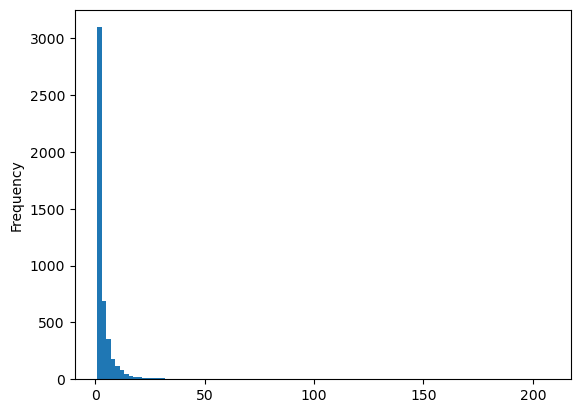

In [113]:
df_frequency = df_sales.groupby('CustomerNo').agg({'TransactionNo':'nunique'}) # nomor Invoicenya harus unique per CustomerID
# Tujuannya nunique karena kita mau bedain customer yang belanja 1x tapi ABSnya langsung gede dan customer yg belanja berkali2 tapi ABSnya kecil

df_frequency['TransactionNo'].plot(kind='hist',bins=100)

Untuk kalkulasi F_score menggunakan pd.qcut menimbulkan error __ValueError: Bin edges must be unique: Index([1.0, 1.0, 4.0, 207.0], dtype='float64', name='TransactionNo').
You can drop duplicate edges by setting the 'duplicates' kwarg__  

Penggunaan pd.qcut untuk membagi data TransactionNo ke dalam 3 kategori kuantil (Low, Medium, High) menghasilkan ValueError karena kebanyakan transaksi memiliki nilai TransactionNo = 1, mengakibatkan pd.qcut tidak dapat membuat bin edges yang unik.


Maka untuk mengatasi ValueError tersebut saya akan menggunakan pd.cut untuk melabeli F_score secara manual

In [115]:
df_frequency['F_score'] = pd.cut(df_frequency['TransactionNo'],bins=[0,5,25,np.Inf],labels=['Low','Medium','High'],right=True)

In [116]:
df_frequency['F_score'].value_counts()

F_score
Low       3783
Medium     868
High        67
Name: count, dtype: int64

In [117]:
df_frequency.groupby('F_score').agg({'TransactionNo':['min','max','mean','median','count']})

C:\Users\benny\AppData\Local\Temp\ipykernel_17412\874623131.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_frequency.groupby('F_score').agg({'TransactionNo':['min','max','mean','median','count']})


TransactionNo                             
                  min  max       mean median count
F_score                                           
Low                 1    5   2.165741    2.0  3783
Medium              6   25   9.816820    8.0   868
High               26  207  45.895522   34.0    67

# K-means untuk menentukan jumlah cluster customer segmentation

In [119]:
recency_rfm = df_recency.set_index('CustomerNo')['days_to_today'] # karena data df_recency ada indexnya, maka di script ini di set indexnya pake CustomerID
volume_rfm = df_volume['total_revenue']
frequency_rfm = df_frequency['TransactionNo']

In [120]:
rfm = pd.concat([recency_rfm,frequency_rfm,volume_rfm],axis=1)

rfm.columns = ["Recency", "Frequency", "Monetary"]

rfm

Recency  Frequency  Monetary
CustomerNo                              
15350.0         373          1    641.16
12791.0         373          1   1166.40
16583.0         373          1   1376.86
17968.0         373          1   1899.72
17908.0         373          1   1998.18
...             ...        ...       ...
12423.0           0          9  14766.41
17497.0           0          2  16972.33
15492.0           0          3  18230.28
14498.0           0          6  17455.59
17490.0           0          7  13538.07

[4718 rows x 3 columns]

In [121]:
rfm.isna().sum()

Recency      0
Frequency    0
Monetary     0
dtype: int64

In [122]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler() 
scaled = scaler.fit_transform(rfm)

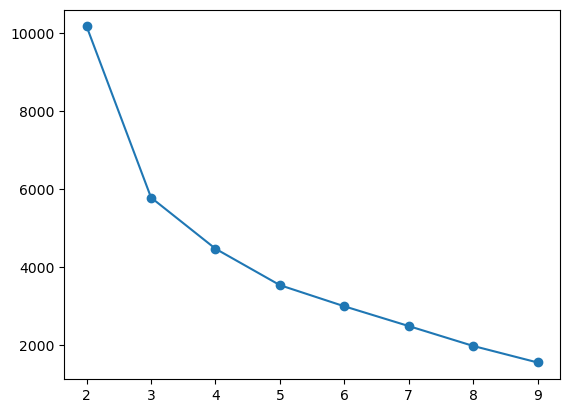

In [123]:
# elbow method untuk menentukan banyaknya cluster
from sklearn.cluster import KMeans

# inertia = []
# for i in np.arange(1,11):
#     kmeans=KMeans(n_clusters=i)
#     kmeans.fit(scaled)
#     inertia.append(kmeans.inertia_)

# plt.plot(range(2,10),inertia)

list_sum_distance = []
for k in range(2,10):
    model = KMeans(n_clusters = k, n_init='auto')
    model.fit(scaled)
    inertia = model.inertia_
    list_sum_distance.append(inertia)

plt.plot(range(2,10),list_sum_distance, marker='o')

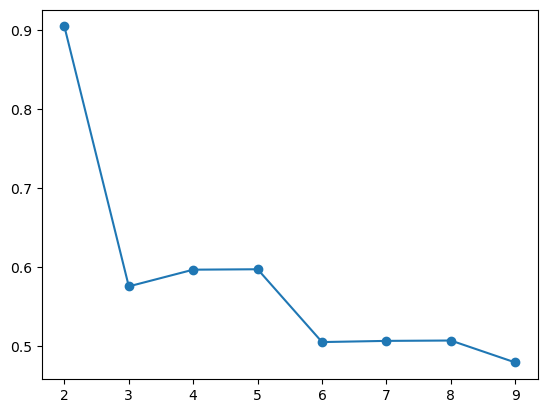

In [124]:
# Silhoutte Score untuk menentukan jumlah cluster
from sklearn.metrics import silhouette_score
list_silhouette = []
for k in range(2,10):
    model = KMeans(n_clusters = k, n_init='auto')
    model.fit(scaled)
    cluster = model.labels_
    score = silhouette_score(scaled,cluster)
    list_silhouette.append(score)


# plt.plot(list_silhouette="o")
plt.plot(range(2,10),list_silhouette, marker="o")

Dari hasil Elbow Method dan Silhoutte Method, maka diambil jumlah kluster sebanyak 4 

In [126]:
kmeans=KMeans(n_clusters=4, n_init='auto')
kmeans.fit(scaled)
rfm['Clusters']=(kmeans.labels_ +1)

rfm

Recency  Frequency  Monetary  Clusters
CustomerNo                                        
15350.0         373          1    641.16         3
12791.0         373          1   1166.40         3
16583.0         373          1   1376.86         3
17968.0         373          1   1899.72         3
17908.0         373          1   1998.18         3
...             ...        ...       ...       ...
12423.0           0          9  14766.41         1
17497.0           0          2  16972.33         1
15492.0           0          3  18230.28         1
14498.0           0          6  17455.59         1
17490.0           0          7  13538.07         1

[4718 rows x 4 columns]

In [127]:
# Memperbaiki cara memilih kolom dengan list, bukan tuple
group_cluster = rfm.groupby(['Clusters'])[['Recency', 'Frequency', 'Monetary']].mean()
group_cluster

Recency  Frequency       Monetary
Clusters                                      
1          44.136307   3.585427    9253.467013
2          24.611111  69.000000  710774.533333
3         245.792197   1.553344    3836.263121
4          12.330769  19.923077   61117.558808

## Kesimpulan clusters
- Cluster 1 = Recencynya terbaik, Frequency kedua terbaik dan Monetary kedua terbaik juga. Maka dimasukkan ke kategori Potential Top Customers  
- Cluster 2 = RFM scorenya paling rendah, kemungkinan masuk ke kategori Lost Customers   
- Cluster 2 = Recencynya kedua terbaik, Frequency terbaik dan Monetary terbaik juga. Maka dimasukkan ke kategori Top Customers  
- Cluster 4 = RFM scorenya kedua terburuk, maka masuk ke Normal Customers  

### Menurut saya clusternya terlalu sedikit sedikit untuk customer segmentation, makanya menggunakan 7 customer segmentation dinilai dari label RFM score (Low, Medium, High) 

# Penggabungan Ketiga Komponen RFM Analysis

In [131]:
df_recency.head(2)

CustomerNo  days_to_today R_score
534517     15350.0            373    Long
533622     12791.0            373    Long

In [132]:
df_volume.head(2)

total_revenue V_score
CustomerNo                       
12004.0           1509.60     Low
12006.0             24.76     Low

In [133]:
df_frequency.head(2)

TransactionNo F_score
CustomerNo                       
12004.0                 1     Low
12006.0                 1     Low

In [134]:
recency = df_recency.set_index('CustomerNo')['R_score'] # karena data df_recency ada indexnya, maka di script ini di set indexnya pake CustomerID
volume = df_volume['V_score']
frequency = df_frequency['F_score']

In [135]:
# Hasil R,V,F score di atas maka di Concat/digabungkan 
df_rfm = pd.concat([recency,frequency,volume],axis=1)
# axis=1 artinya hasil data gabungannya akan digabung menyamping, dengan CustomerID sebagai acuan indexnya.abs

df_rfm
# Hasilnya akan menunjukkan setiap CustomerID akan dikategorikan di kategori mana berdasarkan R_score, F_score dan V_score

R_score F_score V_score
CustomerNo                        
15350.0       Long     Low     Low
12791.0       Long     Low     Low
16583.0       Long     Low     Low
17968.0       Long     Low     Low
17908.0       Long     Low     Low
...            ...     ...     ...
12423.0     Recent  Medium    High
17497.0     Recent     Low    High
15492.0     Recent     Low    High
14498.0     Recent  Medium    High
17490.0     Recent  Medium    High

[4718 rows x 3 columns]

In [136]:
def categorize_customer(row):
    R = row['R_score']
    F = row['F_score']
    V = row['V_score']

    if R == 'Recent' and F == 'High' and V == 'High':
        return 'Top Customer'
    elif (R == 'Normal' or R == 'Recent') and F == 'High' and (V == 'Medium' or V == 'High'):
        return 'Loyal Customers'
    elif (R == 'Normal' or R == 'Recent') and F == 'Medium' and (V == 'Medium' or V == 'High'):
        return 'Potential Loyalist'
    elif (R == 'Normal' or R == 'Recent') and F == 'Low' and (V == 'Medium' or V == 'Low'):
        return 'New Customers'
    elif (R == 'Normal' or R == 'Recent') and F == 'Low' and (V == 'Medium' or V == 'High'):
        return 'Promising'
    elif R == 'Long' and (F == 'Medium' or F == 'High') and (V == 'Medium' or V == 'High'):
        return 'At-Risk-Customers'
    elif R == 'Long' and (F == 'Medium' or F == 'High') and V == 'High':
        return "Can't Lose Them"
    elif R == 'Long' and F == 'Low' and (V == 'Medium' or V == 'Low'):
        return 'Lost Customers'
    else:
        return 'Promising'


# Apply final categorization untuk customer ke df_rfm 
df_rfm['Final_Customer_Category'] = df_rfm.apply(categorize_customer, axis=1)

In [137]:
df_rfm['Final_Customer_Category'].value_counts()

Final_Customer_Category
New Customers         1677
Lost Customers        1358
Potential Loyalist     828
Promising              755
Top Customer            64
At-Risk-Customers       34
Loyal Customers          2
Name: count, dtype: int64

### Jawaban Crucial Question nomor 4 bisa dijawab dengan list top customer di bawah ini:

In [139]:
top_customers = df_rfm[df_rfm['Final_Customer_Category'] == 'Top Customer']
top_customers.head()

R_score F_score V_score Final_Customer_Category
CustomerNo                                                
14849.0     Recent    High    High            Top Customer
16422.0     Recent    High    High            Top Customer
13018.0     Recent    High    High            Top Customer
15005.0     Recent    High    High            Top Customer
16168.0     Recent    High    High            Top Customer

In [140]:
loyal_customers = df_rfm[df_rfm['Final_Customer_Category'] == 'Loyal Customers']
loyal_customers.head()

R_score F_score V_score Final_Customer_Category
CustomerNo                                                
16029.0     Normal    High    High         Loyal Customers
17961.0     Recent    High  Medium         Loyal Customers

C:\Users\benny\AppData\Local\Temp\ipykernel_17412\2408339404.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df_rfm, x='Final_Customer_Category', palette="viridis")


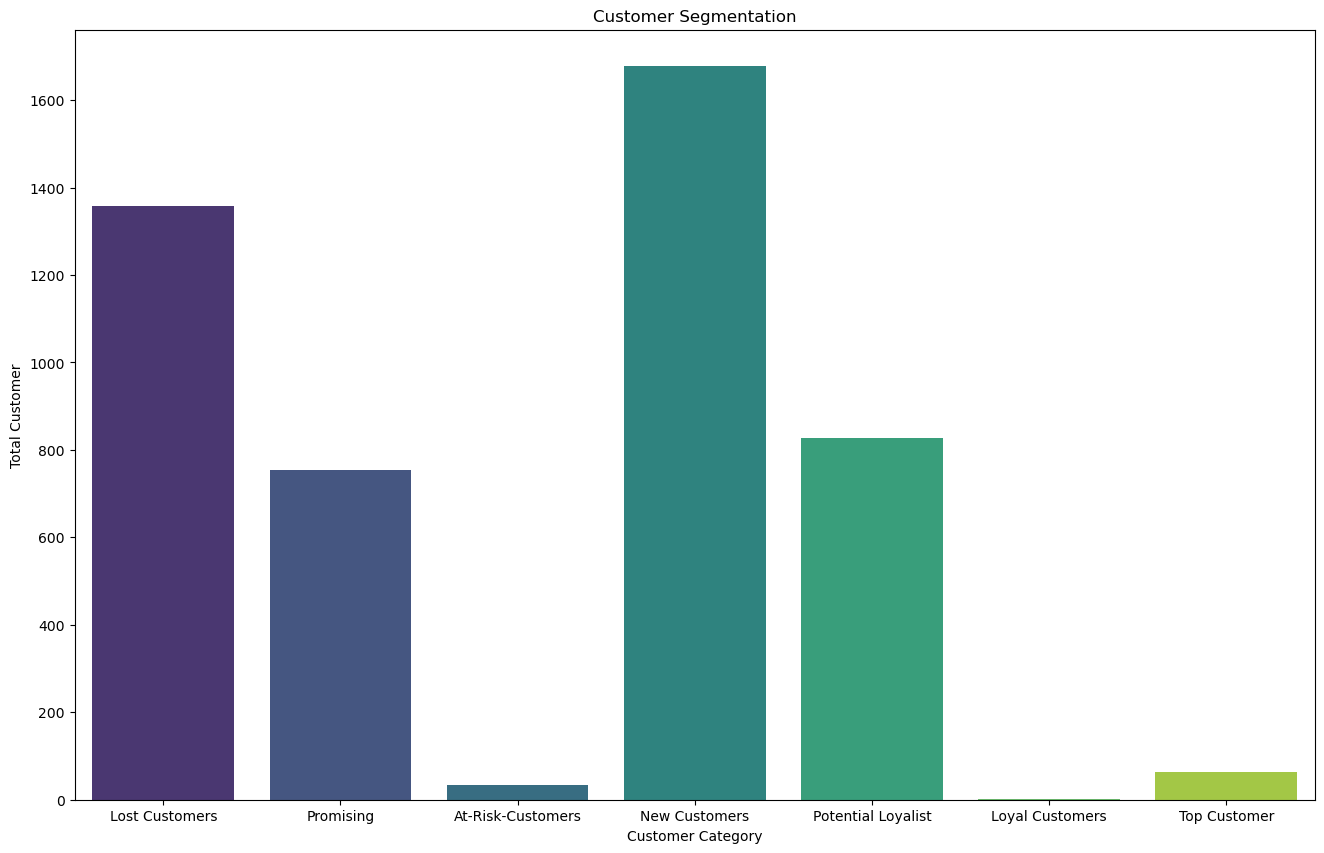

In [141]:
# Visualization
plt.figure(figsize=(16, 10))
sns.countplot(data=df_rfm, x='Final_Customer_Category', palette="viridis")
plt.title("Customer Segmentation")
plt.xlabel("Customer Category")
plt.ylabel("Total Customer")
plt.xticks(rotation=0)
# plt.savefig('Customer Segmentation.png')
plt.show()

Top Customer: These are your best customers who are highly engaged and spend the most.  
- R_score = Recent
- F_score = High
- V_score = High  


Loyal Customers: Customers who regularly purchase from you and contribute significantly to revenue.  
- R_score = Normal or Recent
- F_score = High
- V_score = Medium or High  


Potential Loyalist: Customers who show potential to become loyal with the right engagement strategies.  
- R_score = Normal or Recent
- F_score = Medium
- V_score = Medium or High  


New Customers: Recently acquired customers who need nurturing to become repeat buyers.  
- R_score = Normal or Recent
- F_score = Low
- V_score = Low or Medium  


Promising: Customers with potential to engage further and increase purchases.  
- R_score = Normal or Recent
- F_score = Low
- V_score = Medium or High  


At-Risk-Customers: Previously engaged customers who may be losing interest.  
- R_score = Long
- F_score = Medium or High
- V_score = Medium or High  

Lost Customers: Customers who are unlikely to return unless targeted with special offers.  
- R_score = Long
- F_score = Low
- V_score = Medium or Low  

# (Crucial Question) Pertanyaan 5: Based on your findings, what strategy could you recommend to the business to gain more profit?
Untuk pertanyaan krusial ini diperlukan analisis lebih dalam. Maka di bawah ini adalah analisis tambahan untuk menjawab strategi apa yang perlu dilakukan untuk mendapatkan profit lebih besar.

## Further analysis ideas: 
- Menggabungkan df_rfm dengan df_sales agar hasil RFM analysis bisa digabungkan dengan hasil product segementation dan hasil analisis price vs quantity correlation
- Setelah di merge, analisis selanjutnya bisa melihat pergerakan customer category hasil RFM Analysis dari sisi revenue, ABS, jumlah kuantitas penjualan, jumlah transaksi dan jumlah customer per category
- Dari hasil analisis performance tiap customer category, kita bisa fokus ke beberapa customer category sebagai acuan kita menjalankan promo-promo atau menjalankan strategi campaign
- Menganalisis jumlah transaksi per product category di tiap customer category untuk menentukan kategori produk apa yang paling cocok untuk digunakan pada saat melakukan promosi  
- Mencari tahu customer per category paling banyak berasal dari mana untuk menentukan strategi marketing untuk tiap negara 
- Price Elasticity atau nilai korelasi Price vs Quantity per negara, untuk melihat negara mana yang paling sensitif terhadap kenaikan harga
- Price Elasticity juga bisa diagregasi per musimnya
- Seasonality analysis bisa ditambahin lebih jauh dengan memberikan label season untuk tiap tanggal transaksi
- Memanfaatkan Prophet model untuk memprediksi trend revenue di 2020

### Menggabungkan df_sales dan df_rfm

In [146]:
# Pilih hanya kolom yang diperlukan dari df_rfm
df_rfm_subset = df_rfm[['Final_Customer_Category']].reset_index()

# Lakukan merge antara df_merge dan df_rfm_subset berdasarkan CustomerNo
df_merge = pd.merge(df_sales, df_rfm_subset, on='CustomerNo', how='left')

### Merge data df_merge dan merged_segmentation yang berisi final_product_category

In [148]:
# Pilih hanya kolom yang diperlukan dari merged_segmentation (ProductName dan final_segmentation)
merged_segmentation_subset = merged_segmentation[['ProductName', 'final_product_segmentation']]

# Lakukan merge antara df_merge dan merged_segmentation_subset berdasarkan ProductName
df_merge = pd.merge(df_merge, merged_segmentation_subset, on='ProductName', how='left')

In [149]:
# Setelah df_sales, df_rfm dan merged_segmentation dimerge, Saya mau lihat berapa banyak customer per final kategori dan per negara
country_segmentation = df_merge.groupby(['Country', 'Final_Customer_Category']).agg(category_counts=('Final_Customer_Category', 'count')).reset_index(drop=False)
country_segmentation

Country Final_Customer_Category  category_counts
0         Australia          Lost Customers               10
1         Australia           New Customers               62
2         Australia      Potential Loyalist             1114
3         Australia               Promising              445
4           Austria          Lost Customers               43
..              ...                     ...              ...
102  United Kingdom      Potential Loyalist           184238
103  United Kingdom               Promising           115024
104  United Kingdom            Top Customer            46648
105     Unspecified          Lost Customers              328
106     Unspecified           New Customers              119

[107 rows x 3 columns]

In [150]:
# Filter hanya untuk kategori "Promising" dan "Potential Loyalist"
promising_potential_customer = country_segmentation[country_segmentation['Final_Customer_Category'].isin(['Promising', 'Potential Loyalist'])]

# Melihat describe data customer kategori Potential Loyalist dan Promising
promising_potential_customer.groupby('Final_Customer_Category').agg({'category_counts':['min','max','mean','median','count','sum']})

category_counts                                     \
                                    min     max          mean median count   
Final_Customer_Category                                                      
Potential Loyalist                   44  184238  12600.375000  671.5    16   
Promising                            75  115024   5389.833333  299.0    24   

                                 
                            sum  
Final_Customer_Category          
Potential Loyalist       201606  
Promising                129356

### Untuk melengkapi data df_merge yang sebelumya sudah di merge dengan final segmentation untuk produk dan customer, maka ditambahkan lagi kalkulasi nilai koefisien korelasi untuk melihat nilai korelasi price vs quantity setiap produk 

In [152]:
# Filter data untuk mendapatkan kolom yang dibutuhkan saja
df_merge_filtered = df_merge[['ProductName', 'Price', 'Quantity']]
df_merge_filtered

ProductName  Price  Quantity
0             Set Of 2 Wooden Market Crates  21.47        12
1       Christmas Star Wish List Chalkboard  10.65        36
2                  Storage Tin Vintage Leaf  11.53        12
3         Tree T-Light Holder Willie Winkie  10.65        12
4         Set Of 4 Knick Knack Tins Poppies  11.94         6
...                                     ...    ...       ...
527760   Ceramic Cake Stand + Hanging Cakes  20.45         2
527761         Sweetheart 3 Tier Cake Stand  20.45         1
527762       Box Of Vintage Alphabet Blocks  20.45         2
527763   Ceramic Cake Stand + Hanging Cakes  20.45         1
527764     Cake Stand Lovebird 2 Tier White  20.45         1

[527765 rows x 3 columns]

In [153]:
# Selanjutnya menghitung coefficient correlations 

# buat dictionary untuk hasil kalkulasi correlations
df_merge_correlations = {}

for product, group in df_merge_filtered.groupby('ProductName'): # looping untuk tiap produk dan groupnya (price & quantity) 
    if group.shape[0] > 1:  # Memastikan setiap product memiliki lebih dari 1 price dan quantity untuk dikalkulasi koefisien korelasinya. Kalau cuman punya 1 price dan quantity artinya gak ada perubahan harga jadi gak bisa dikalkulasi korelasi perubahan price terhadap quantity 
        merge_corr = group['Price'].corr(group['Quantity']) # Menghitung koefisien korelasi antara Price dan Quantity untuk setiap product di df_merge_filtered
        df_merge_correlations[product] = merge_corr # Menyimpan hasil kalkulasi koefisien korelasi ke dalam dictionary df_merge_correlations

# Mengkonversi hasil kalkulasi koefisien korelasi yang berbentuk series menjadi dataframe
correlation_df = pd.DataFrame(list(correlations.items()), columns=['ProductName', 'price_quantity_correlation'])
correlation_df

C:\Users\benny\anaconda3\Lib\site-packages\numpy\lib\function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\benny\anaconda3\Lib\site-packages\numpy\lib\function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


ProductName  price_quantity_correlation
0        12 Message Cards With Envelopes                   -0.080832
1          12 Pencil Small Tube Woodland                   -0.040362
2    12 Pencils Small Tube Red Retrospot                    0.008916
3    15cm Christmas Glass Ball 20 Lights                   -0.191617
4                20 Dolly Pegs Retrospot                   -0.015136
..                                   ...                         ...
695    World War 2 Gliders Asstd Designs                    0.023541
696            Zinc Folkart Sleigh Bells                   -0.123422
697    Zinc Heart Lattice T-Light Holder                   -0.132540
698          Zinc Metal Heart Decoration                    0.038028
699      Zinc Willie Winkie Candle Stick                   -0.043880

[700 rows x 2 columns]

In [154]:
# Pilih hanya kolom yang diperlukan dari merged_segmentation (ProductName dan final_segmentation)
correlation_df_subset = correlation_df[['ProductName', 'price_quantity_correlation']]

# Lakukan merge antara df_merge dan mcorrelation_df berdasarkan ProductName
df_merge = pd.merge(df_merge, correlation_df, on='ProductName', how='left')
df_merge.head()

TransactionNo       Date ProductNo                          ProductName  \
0        581482 2019-12-09     22485        Set Of 2 Wooden Market Crates   
1        581475 2019-12-09     22596  Christmas Star Wish List Chalkboard   
2        581475 2019-12-09     23235             Storage Tin Vintage Leaf   
3        581475 2019-12-09     23272    Tree T-Light Holder Willie Winkie   
4        581475 2019-12-09     23239    Set Of 4 Knick Knack Tins Poppies   

   Price  Quantity  CustomerNo         Country  total_revenue order_month  \
0  21.47        12     17490.0  United Kingdom         257.64     2019-12   
1  10.65        36     13069.0  United Kingdom         383.40     2019-12   
2  11.53        12     13069.0  United Kingdom         138.36     2019-12   
3  10.65        12     13069.0  United Kingdom         127.80     2019-12   
4  11.94         6     13069.0  United Kingdom          71.64     2019-12   

    cohort  DayOfWeek DayName month_year Final_Customer_Category  \
0  2019-06          0  Monday    2019-12      Potential Loyalist   
1  2018-12          0  Monday    2019-12      Potential Loyalist   
2  2018-12          0  Monday    2019-12      Potential Loyalist   
3  2018-12          0  Monday    2019-12      Potential Loyalist   
4  2018-12          0  Monday    2019-12      Potential Loyalist   

  final_product_segmentation  price_quantity_correlation  
0                     Normal                         NaN  
1              Super Popular                   -0.040087  
2                     Normal                         NaN  
3                     Normal                         NaN  
4                     Normal                   -0.068136

In [155]:
# Filter untuk mencari 10 produk yang berkategori Super Popular dengan total revenue tertinggi
filtered_df = df_merge[df_merge['final_product_segmentation'] == 'Super Popular']  # Replace with actual column name if needed
top_10_super_popular_product = filtered_df.nlargest(10, 'total_revenue')  # Ensure 'total_revenue' column exists

super_popular_subset = top_10_super_popular_product[['ProductName', 'final_product_segmentation', 'total_revenue', 'price_quantity_correlation']]
super_popular_subset

ProductName final_product_segmentation  \
142              Paper Craft Little Birdie              Super Popular   
466383      Medium Ceramic Top Storage Jar              Super Popular   
40898       Asstd Design 3d Paper Stickers              Super Popular   
116393   World War 2 Gliders Asstd Designs              Super Popular   
326707                      Popcorn Holder              Super Popular   
431638               Empire Design Rosette              Super Popular   
370564  Fairy Cake Flannel Assorted Colour              Super Popular   
476132  Fairy Cake Flannel Assorted Colour              Super Popular   
246237       Assorted Colour Bird Ornament              Super Popular   
265953  Essential Balm 35g Tin In Envelope              Super Popular   

        total_revenue  price_quantity_correlation  
142        1002718.10                         NaN  
466383      840113.80                    0.007288  
40898        77622.60                         NaN  
116393       50256.00                    0.023541  
326707       47257.00                   -0.070824  
431638       43317.54                         NaN  
370564       38613.60                   -0.002835  
476132       38613.60                   -0.002835  
246237       33811.20                   -0.018100  
265953       32847.66                         NaN

# Analisis Lanjutan

# Top 10 Highest Revenue Countries

In [158]:
retail_countries_purchase = df_merge.groupby(['Country'], as_index=False)['total_revenue'].agg('sum')
retail_countries_purchase_asc = retail_countries_purchase.sort_values('total_revenue').head(10)
retail_countries_purchase_desc = retail_countries_purchase.sort_values('total_revenue', ascending=False).head(10)

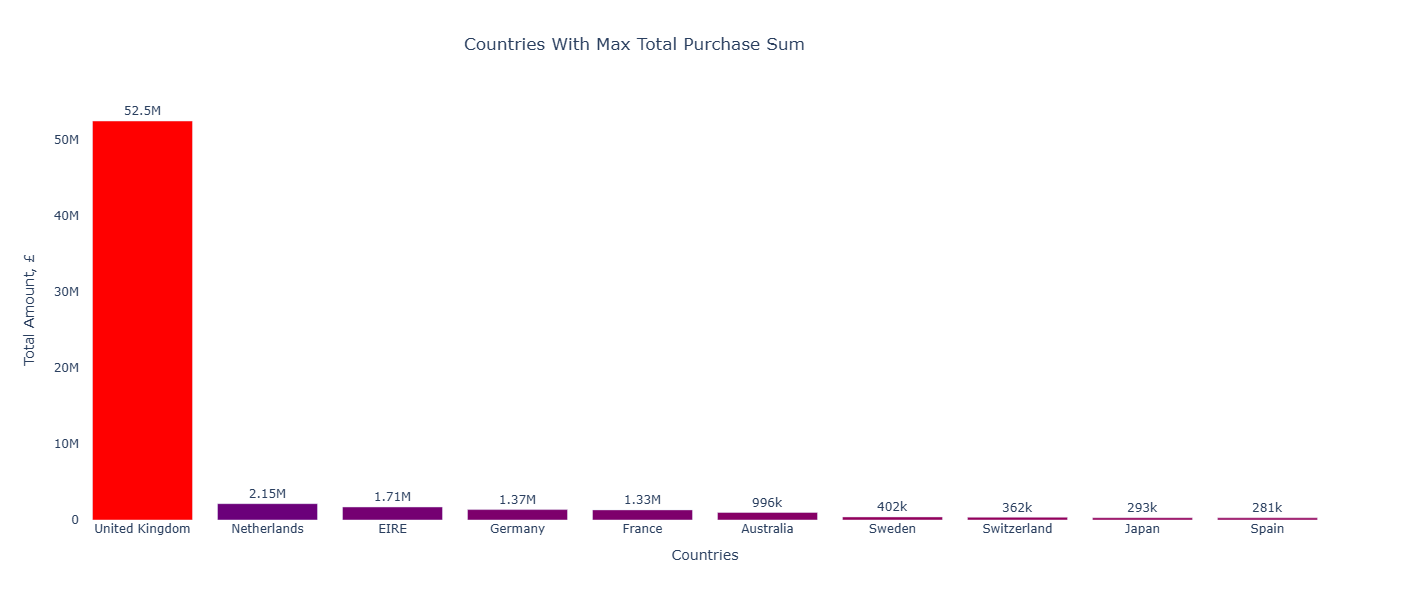

In [159]:
fig = go.Figure(data=[
    go.Bar(name='Countries With Max Total Purchase Amount', 
           x=retail_countries_purchase_desc['Country'].astype(str), 
           y=retail_countries_purchase_desc['total_revenue'],
           marker_opacity=1,
           marker={'color': retail_countries_purchase_desc['total_revenue'],
                   'colorscale': 'Rainbow'})
    ])

fig.update_traces(texttemplate='%{y:.3s}', textposition='outside')

fig.update_layout(title='Countries With Max Total Purchase Sum',
                  title_x=0.45,
                  xaxis_title="Countries",
                  yaxis_title="Total Amount, £",
                  plot_bgcolor='white',
                  width=1000,
                  height=600)
fig.show()

# Countries with Lowest Transaction Value

In [161]:
fig = go.Figure(data=[
    go.Bar(name='Countries With Min Total Purchase Amount', 
           x=retail_countries_purchase_asc['Country'].astype(str), 
           y=retail_countries_purchase_asc['total_revenue'],
           marker_opacity=1,
           marker={'color': retail_countries_purchase_desc['total_revenue'],
                   'colorscale': 'Rainbow'}
          )
    ])

fig.update_traces(texttemplate='%{y:.3s}', textposition='inside')

fig.update_layout(title='Countries With Min Total Purchase Amount',
                  title_x=0.45,
                  title_y=0.97,
                  xaxis_title="Countries",
                  yaxis_title="Total Amount, £",
                  plot_bgcolor='white',
                  width=1000,  # Menentukan lebar visualisasi dalam piksel
                  height=600   # Menentukan tinggi visualisasi (opsional)
                 )

fig.show()

# Monthly Revenue per Customer Category

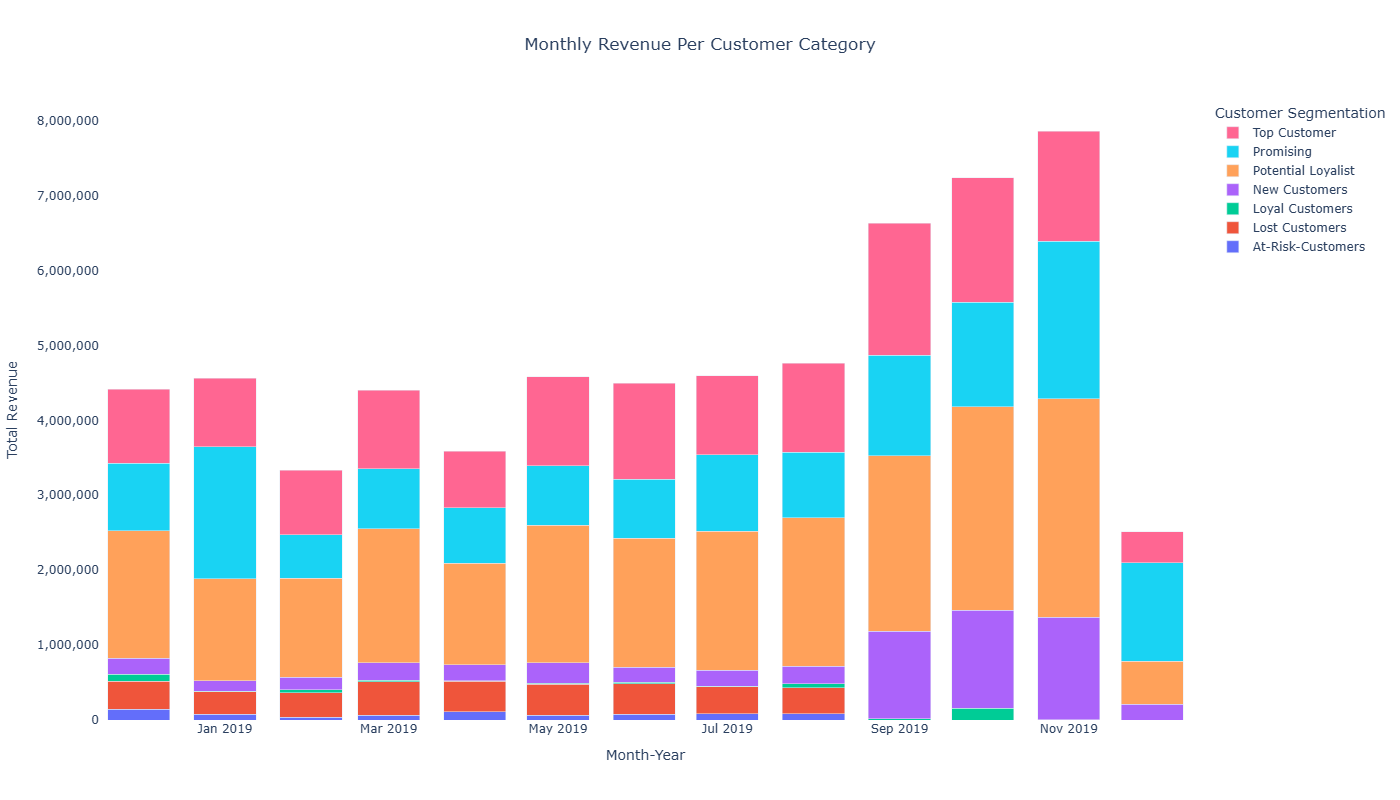

In [163]:
# Revenue harian berdasarkan kategori customer
monthly_revenue_category = df_merge.groupby(['month_year', 'Final_Customer_Category'])['total_revenue'].sum().unstack()

# Membuat figure
fig = go.Figure()

# Menambahkan trace untuk setiap kategori pelanggan
for category in monthly_revenue_category.columns:
    fig.add_trace(go.Bar(
        name=category,
        x=monthly_revenue_category.index.astype(str),
        y=monthly_revenue_category[category],
    ))

# Menyesuaikan tata letak
fig.update_layout(
    title='Monthly Revenue Per Customer Category',
    title_x=0.5,  # Posisi tengah
    xaxis=dict(title='Month-Year', tickmode='array', tickangle=0),
    yaxis=dict(title='Total Revenue', tickformat=","),
    barmode='stack',  # Menjadikan chart sebagai stacked bar
    plot_bgcolor='white',
    width=1200,  # Menentukan lebar visualisasi
    height=800,
    legend_title='Customer Segmentation'
)

# Menampilkan grafik
fig.show()

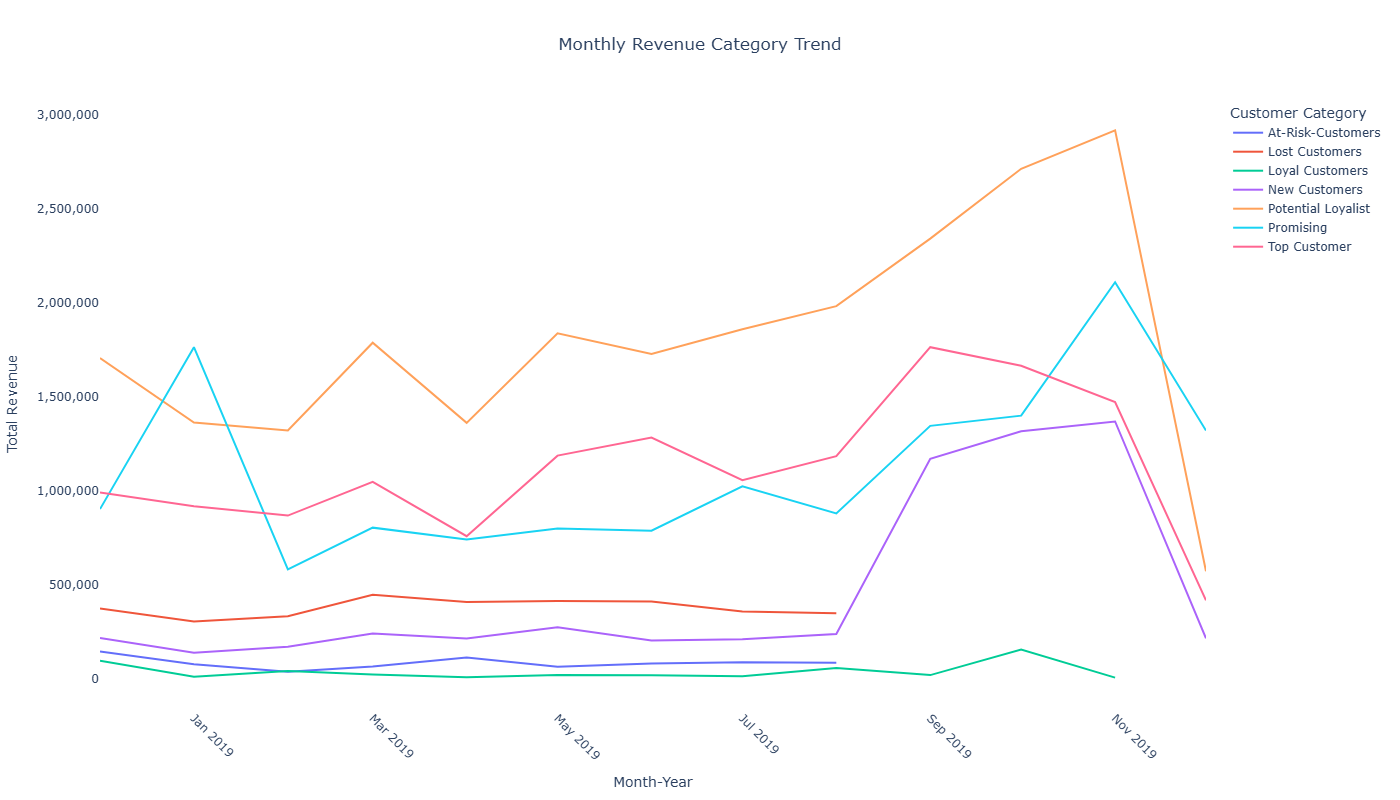

In [164]:
# Trend Revenue bulanan berdasarkan kategori pelanggan
monthly_revenue_category = df_merge.groupby(['month_year', 'Final_Customer_Category'])['total_revenue'].sum().unstack()

# Membuat figure
fig = go.Figure()

# Menambahkan trace untuk setiap kategori pelanggan
temp_index = monthly_revenue_category.index.astype(str)
for category in monthly_revenue_category.columns:
    fig.add_trace(go.Scatter(
        name=category,
        x=temp_index,
        y=monthly_revenue_category[category],
        mode='lines',  # Menggunakan line chart
    ))

# Menyesuaikan tata letak
fig.update_layout(
    title='Monthly Revenue Category Trend',
    title_x=0.5,  # Posisi tengah
    xaxis=dict(title='Month-Year', tickmode='array', tickangle=45),
    yaxis=dict(title='Total Revenue', tickformat=","),
    plot_bgcolor='white',
    width=1200,  # Menentukan lebar visualisasi
    height=800,
    legend_title='Customer Category'
)

# Menampilkan grafik
fig.show()


# Monthly Revenue per Product Category

In [166]:
# Revenue harian berdasarkan kategori pelanggan
monthly_revenue_product_category = df_merge.groupby(['month_year', 'final_product_segmentation'])['total_revenue'].sum().unstack()

# Membuat figure
fig = go.Figure()

# Menambahkan trace untuk setiap kategori pelanggan
for category in monthly_revenue_product_category.columns:
    fig.add_trace(go.Bar(
        name=category,
        x=monthly_revenue_product_category.index.astype(str),
        y=monthly_revenue_product_category[category],
    ))

# Menyesuaikan tata letak
fig.update_layout(
    title='Monthly Revenue Per Product Category',
    title_x=0.5,  # Posisi tengah
    xaxis=dict(title='Month-Year', tickmode='array', tickangle=0),
    yaxis=dict(title='Total Revenue', tickformat=","),
    barmode='stack',  # Menjadikan chart sebagai stacked bar
    plot_bgcolor='white',
    width=1200,  # Menentukan lebar visualisasi
    height=800,
    legend_title='Product Category'
)

# Menampilkan grafik
fig.show()

# Monthly Average Basket Size per Product Category

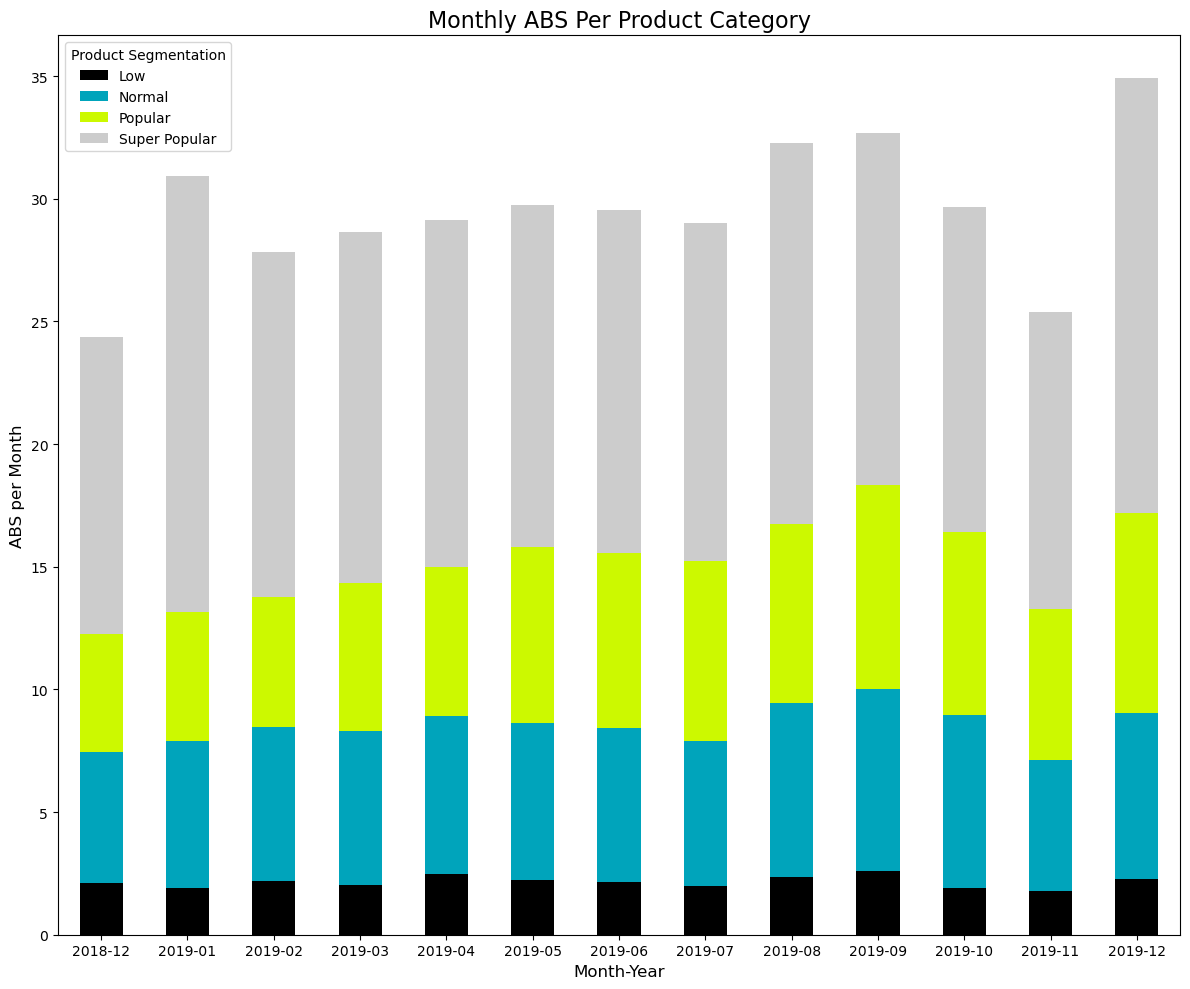

In [168]:
# Average Basket Size per kategori produk
basket_size_product_category = df_merge.groupby(['month_year','final_product_segmentation'])['Quantity'].mean().unstack()

# Visualisasi
# Plot stacked bar chart
basket_size_product_category.plot(kind='bar', stacked=True, figsize=(12, 10), colormap='nipy_spectral')
plt.title('Monthly ABS Per Product Category', fontsize=16)
plt.xlabel('Month-Year', fontsize=12)
plt.ylabel('ABS per Month', fontsize=12)
plt.legend(title='Product Segmentation')
plt.xticks(rotation=0)
plt.gca().yaxis.set_major_formatter(mticker.FuncFormatter(lambda x, _: f'{int(x):,}'))
plt.tight_layout()
plt.show()

# Monthly Average Basket Size per Customer Category

In [170]:
# Average Basket Size per kategori customer
basket_size_customer_category = df_merge.groupby(['month_year','Final_Customer_Category'])['Quantity'].mean().unstack()

# Membuat figure
fig = go.Figure()

# Menambahkan trace untuk setiap kategori pelanggan
for category in basket_size_customer_category.columns:
    fig.add_trace(go.Bar(
        name=category,
        x=basket_size_customer_category.index.astype(str),
        y=basket_size_customer_category[category],
    ))

# Menyesuaikan tata letak
fig.update_layout(
    title='Monthly ABS Per Customer Category',
    title_x=0.5,  # Posisi tengah
    xaxis=dict(title='Month-Year', tickmode='array', tickangle=0),
    yaxis=dict(title='ABS per Month', tickformat=".2f"),
    barmode='stack',  # Menjadikan chart sebagai stacked bar
    plot_bgcolor='white',
    width=1200,  # Menentukan lebar visualisasi
    height=800,
    legend_title='Customer Category'
)

# Menampilkan grafik
fig.show()

# Price Elasticity by Country

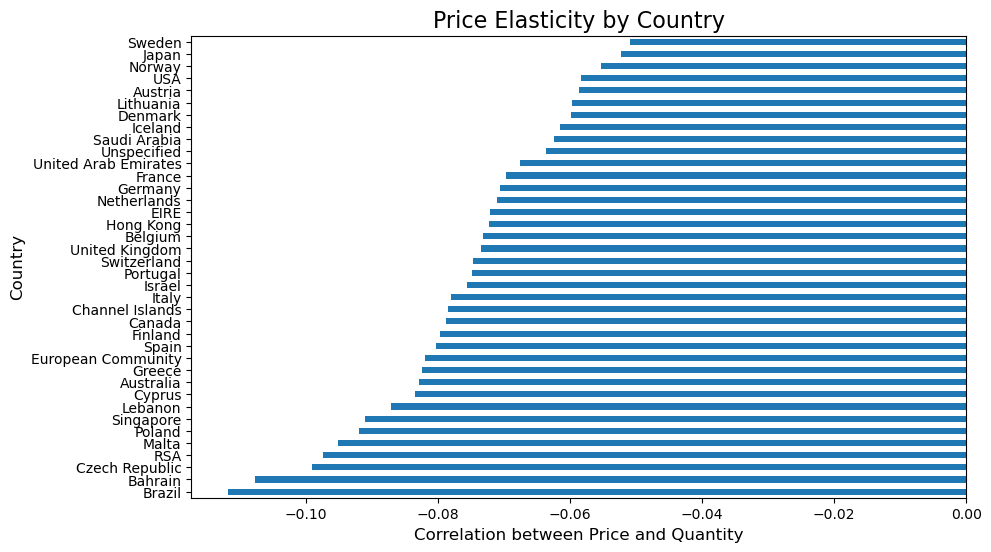

In [172]:
# Korelasi harga dan kuantitas berdasarkan negara
price_quantity_correlation = df_merge.groupby('Country')['price_quantity_correlation'].mean()

# Visualisasi
price_quantity_correlation.sort_values().plot(kind='barh', figsize=(10, 6))
plt.title('Price Elasticity by Country', fontsize=16)
plt.xlabel('Correlation between Price and Quantity', fontsize=12)
plt.ylabel('Country', fontsize=12)
plt.show()

## Monthly Customer Transactions

In [174]:
# Perubahan jumlah customer per kategori dari waktu ke waktu
monthly_customer_transaction = df_merge.groupby(['month_year', 'Final_Customer_Category']).size().unstack()

# Membuat figure
fig = go.Figure()

# Menambahkan trace untuk setiap kategori pelanggan
for category in monthly_customer_transaction.columns:
    fig.add_trace(go.Bar(
        name=category,
        x=monthly_customer_transaction.index.astype(str),
        y=monthly_customer_transaction[category],
    ))

# Menyesuaikan tata letak
fig.update_layout(
    title='Monthly Customer Transactions',
    title_x=0.5,  # Posisi tengah
    xaxis=dict(title='Month-Year', tickmode='array', tickangle=0),
    yaxis=dict(title='Total Transactions', tickformat=","),
    barmode='stack',  # Menjadikan chart sebagai stacked bar
    plot_bgcolor='white',
    width=1200,  # Menentukan lebar visualisasi
    height=800,
    legend_title='Customer Category'
)

# Menampilkan grafik
fig.show()

# Number of Customers per Month

In [176]:
# Menghitung jumlah kategori customer per bulan dengan CustomerNo nunique
monthly_unique_customer_category = df_merge.groupby(['month_year', 'Final_Customer_Category'])['CustomerNo'].nunique().reset_index()

# Konversi kolom 'month_year' dari Period ke string
monthly_unique_customer_category['month_year'] = monthly_unique_customer_category['month_year'].astype(str)

# Membuat figure
fig = go.Figure()

# Menambahkan trace untuk setiap kategori pelanggan
for category in monthly_unique_customer_category['Final_Customer_Category'].unique():
    subset = monthly_unique_customer_category[monthly_unique_customer_category['Final_Customer_Category'] == category]
    fig.add_trace(go.Bar(
        name=category,
        x=subset['month_year'],  # Sudah dikonversi menjadi string
        y=subset['CustomerNo'],
    ))

# Menyesuaikan tata letak
fig.update_layout(
    title='Number of Customers per Month',
    title_x=0.5,  # Posisi tengah
    xaxis=dict(title='Month-Year', tickmode='array', tickangle=0),
    yaxis=dict(title='Number of Customers', tickformat=","),
    barmode='stack',  # Menjadikan chart sebagai stacked bar
    plot_bgcolor='white',
    width=1200,  # Menentukan lebar visualisasi
    height=800,
    legend_title='Customer Category'
)

# Menampilkan grafik
fig.show()

# Quantity Sold per Month

In [178]:
# Menghitung jumlah kategori customer per bulan dengan CustomerNo nunique
monthly_transaction_quantity = df_merge.groupby(['month_year', 'Final_Customer_Category'])['Quantity'].sum().unstack()

# Membuat figure
fig = go.Figure()

# Menambahkan trace untuk setiap kategori pelanggan
for category in monthly_transaction_quantity.columns:
    fig.add_trace(go.Bar(
        name=category,
        x=monthly_transaction_quantity.index.astype(str),
        y=monthly_transaction_quantity[category],
    ))

# Menyesuaikan tata letak
fig.update_layout(
    title='Quantity Sold per Month',
    title_x=0.5,  # Posisi tengah
    xaxis=dict(title='Month-Year', tickmode='array', tickangle=0),
    yaxis=dict(title='Total Quantity', tickformat=","),
    barmode='stack',  # Menjadikan chart sebagai stacked bar
    plot_bgcolor='white',
    width=1200,  # Menentukan lebar visualisasi
    height=800,
    legend_title='Customer Category'
)

# Menampilkan grafik
fig.show()

# (Crucial Question) Pertanyaan 5: Based on your findings, what strategy could you recommend to the business to gain more profit?
### Dari analisis performa customer category, maka bisa diperoleh jawaban:

## Conclusion using SWOT Analysis
Strenght:  
1. Kontribusi customer Potential Loyalist paling besar
2. Loyal Customers memiliki ABS terbesar
3. Peningkatan New Customers mulai September 2019
4. Overall performance meningkat mendekati akhir tahun

Weaknesess:
1. Jumlah Lost Customers konsisten di Q1-Q3
2. Jumlah Loyal Customers sedikit, biarpun memiliki ABS tertinggi dibanding Customer Category yang lain
3. Buruknya retention rates di tahun 2019

Opportunities: 
1. Meningkatkan loyalitas customer Potential Loyalist
2. Mengaktifkan kembali Lost Customers
3. Memaksimalkan holiday season 
4. Menjaga momentum peningkatan new customers di akhir tahun

Threats: 
1. Persaingan dari kompetitor
2. Churn rate di Desember 2018 – Agustus 2019
3. Fluktuasi performance sepanjang tahun
4. Indikasi ketergantungan pada seasonalitas revenue

## Recommendation dibagi menjadi 3 bagian berdasarkan periode, yaitu rekomendasi In General (bisa dijalankan di Q1 sampai Q4), rekomendasi untuk Periode Q1-Q3 dan rekomendasi untuk Periode Q4:

In General: 
1. Memfokuskan strategi marketing untuk customer Potential Loyalist dan Promising karena kontribusi penjualan cukup besar dari kategori tersebut. Strategi awalnya bisa berfokus untuk meningkatkan frekuensi berbelanja dan ABS agar total revenue bisa meningkat lebih tinggi lagi. Frekuensi dan ABS bisa ditingkatkan lewat promo bundling dan loyalty program. Kalau frekuensi dan ABS Potential Loyalist dan Promising meningkat, maka diharapkan bisa naik kelas jadi Loyal Customers. 
2. Untuk Loyal Customers yang sudah ada sekarang, kita bisa berfokus untuk meningkatkan intensitas berbelanja Loyal Customers agar lebih sering berbelanja dengan menawarkan promo-promo diskon dan promonya juga bisa dikombinasikan dengan produk Super Popular di tiap musimnya agar lebih menarik keinginan untuk berbelanja. Dengan strategi yang telah disebutkan, maka diharapkan Loyal Customers naik kelas menjadi Top Customers.

Periode Q1-Q3: 
1. Mempersiapkan strategi untuk menghadapi Lost Customers dan customer retention yang rendah selama Q1 sampai Q3. Strateginya bisa dengan promo-promo insentif ditujukan untuk Lost Customers yang bisa juga disertai ajakan untuk mengisi jawaban atas pertanyaan kenapa mereka tidak berbelanja lagi dalam waktu lama, agar kita bisa mendapat 2 hasil yaitu reaktivasi Lost Customers dan feedback dari pertanyaan yang bisa dijadikan pelajaran untuk memperbaiki layanan kedepannya supaya tidak ada lagi atau setidaknya mengurangi jumlah Lost Customers di Q1 – Q3.
2. Diversifikasi dan improvement strategi penjualan di Q1-Q3 agar revenue meningkat bukan cuman di akhir tahun, namun di 3 kuarter pertama juga meningkat melebihi tahun sebelumnya.

Periode Q4: 
1. Overall performance di Q4 tahun 2019 memang sudah baik dilihat dari peningkatan di semua aspek yang cukup signifikan jumlahnya, maka yang perlu dilakukan adalah mempersiapkan strategi marketing yang lebih matang lagi dari tahun 2019 untuk memaksimalkan perolehan revenue di Q4 tahun 2020. Fokus awalnya bisa mereplikasi strategi di Q4 yang berhasil meningkatkan New Customers dan menurunkan Lost Customers. Dari situ tim marketing dan sales bisa mengembangkan strateginya dengan ide-ide tambahan.
2. Selain strategi marketing untuk memaksimalkan revenue di Q4, perlu dipersiapkan juga strategi untuk menghadapi kompetitor baik di dalam maupun luar negeri. Selain strategi promo harga produk, bisa juga menggunakan promo harga ongkos kirim untuk menjaga dan meningkatkan penjualan internasional.

## Untuk menyusun strategi yang berfokus ke customer category Potential Loyalist, Promising customers, Loyal Customers dan Lost Customers, maka beberapa informasi yang akan dibahas di slide selanjutnya bisa dijadikan guidelines dalam penyusunan strategi. 
Guidelinesnya sbb:  
1. Informasi produk kategori unggulan dan top 5 produk per season.
2. Seasonality analysis
3. Negara asal dimana 4 customer category yang mau difokuskan berada 
4. Forecasting untuk menjadi target perusahaan di tahun 2020

## Maka analisis di bawah ini adalah analisis pelengkap yang bisa dijadikan guidelines untuk menjalankan strategi hasil analisis SWOT Analysis: 

## Highest Revenue per Product Category on each Customer Category 

In [185]:
# Menghitung jumlah kategori produk per kategori customer
product_category_revenue_per_customer = df_merge.groupby(['Final_Customer_Category', 'final_product_segmentation'])['total_revenue'].sum().unstack()

# Membuat figure
fig = go.Figure()

# Menambahkan trace untuk setiap kategori pelanggan
for category in product_category_revenue_per_customer.columns:
    fig.add_trace(go.Bar(
        name=category,
        x=product_category_revenue_per_customer.index.astype(str),
        y=product_category_revenue_per_customer[category],
    ))

# Menyesuaikan tata letak
fig.update_layout(
    title='Revenue of Product Categories per Customer Category',
    title_x=0.5,  # Posisi tengah
    xaxis=dict(title='Customer Category', tickmode='array', tickangle=0),
    yaxis=dict(title='Total Revenue', tickformat=","),
    barmode='stack',  # Menjadikan chart sebagai stacked bar
    plot_bgcolor='white',
    width=1200,  # Menentukan lebar visualisasi
    height=800,
    legend_title='Product Category'
)

# Menampilkan grafik
fig.show()

### Insight dari jumlah produk per kategori di setiap customer category: 
1. Karena kita mau berfokus pada customer category yaitu Potential Loyalist, Promising Customers, Loyal Customers dan Lost Customers, maka untuk mendukung strategi marketing dan sales yang akan kita jalankan, kita bisa mencari tahu produk kategori apa yang cocok untuk digunakan di promo campaign yang mentargetkan 4 customer category yang menjadi focus kita.
2. Dari hasil analisis di atas, bisa dipastikan produk kategori Super Popular yang paling cocok karena paling banyak mengenerate revenue bagi customer category yang menjadi focus kita.

## Top 5 Country with Highest Number of Focused Customer Category (Potential Loyalist, Promising Customers, Loyal Customers & Lost Customers)

In [188]:
# Menghitung jumlah kategori produk berdasarkan negara
customer_categories_per_country_stacked = df_merge.groupby(['Country', 'Final_Customer_Category']).size().unstack(fill_value=0)

# Mengurutkan berdasarkan total jumlah kategori produk di tiap negara
customer_categories_per_country_stacked['Total'] = customer_categories_per_country_stacked.sum(axis=1)
customer_categories_per_country_stacked = customer_categories_per_country_stacked.sort_values(by='Total', ascending=False)
customer_categories_per_country_stacked = customer_categories_per_country_stacked.drop(columns=['Total']).head()

# Membuat figure
fig = go.Figure()

# Menambahkan trace untuk setiap kategori pelanggan
for category in customer_categories_per_country_stacked.columns:
    fig.add_trace(go.Bar(
        name=category,
        x=customer_categories_per_country_stacked.index.astype(str),
        y=customer_categories_per_country_stacked[category],
    ))

# Menyesuaikan tata letak
fig.update_layout(
    title='Number of Customer Categories by Country',
    title_x=0.5,  # Posisi tengah
    xaxis=dict(title='Country', tickmode='array', tickangle=0),
    yaxis=dict(title='Number of Customers', tickformat=","),
    barmode='stack',  # Menjadikan chart sebagai stacked bar
    plot_bgcolor='white',
    width=1200,  # Menentukan lebar visualisasi
    height=800,
    legend_title='Customer Category'
)

# Menampilkan grafik
fig.show()

### Insight dari analisis Top 5 country dengan jumlah transaksi terbanyak berdasarkan customer category dan product category 
1. Product category dan keempat customer category yang mau difokuskan paling banyak berasal dari United Kingdom
2. Bisa disimpulkan kalau United Kingdom adalah negara domestic atau negara asal retail store

# Adding Seasons Label

In [191]:
# Function to categorize seasons
def get_season(month):
    if month in [12, 1, 2]:
        return "Winter"
    elif month in [3, 4, 5]:
        return "Spring"
    elif month in [6, 7, 8]:
        return "Summer"
    else:
        return "Autumn"

# Add season column
df_merge['Season'] = df_merge['Date'].dt.month.map(get_season)
df_merge

TransactionNo       Date ProductNo  \
0             581482 2019-12-09     22485   
1             581475 2019-12-09     22596   
2             581475 2019-12-09     23235   
3             581475 2019-12-09     23272   
4             581475 2019-12-09     23239   
...              ...        ...       ...   
527760        536585 2018-12-01     37449   
527761        536590 2018-12-01     22776   
527762        536590 2018-12-01     22622   
527763        536591 2018-12-01     37449   
527764        536597 2018-12-01     22220   

                                ProductName  Price  Quantity  CustomerNo  \
0             Set Of 2 Wooden Market Crates  21.47        12     17490.0   
1       Christmas Star Wish List Chalkboard  10.65        36     13069.0   
2                  Storage Tin Vintage Leaf  11.53        12     13069.0   
3         Tree T-Light Holder Willie Winkie  10.65        12     13069.0   
4         Set Of 4 Knick Knack Tins Poppies  11.94         6     13069.0   
...                                     ...    ...       ...         ...   
527760   Ceramic Cake Stand + Hanging Cakes  20.45         2     17460.0   
527761         Sweetheart 3 Tier Cake Stand  20.45         1     13065.0   
527762       Box Of Vintage Alphabet Blocks  20.45         2     13065.0   
527763   Ceramic Cake Stand + Hanging Cakes  20.45         1     14606.0   
527764     Cake Stand Lovebird 2 Tier White  20.45         1     18011.0   

               Country  total_revenue order_month   cohort  DayOfWeek  \
0       United Kingdom         257.64     2019-12  2019-06          0   
1       United Kingdom         383.40     2019-12  2018-12          0   
2       United Kingdom         138.36     2019-12  2018-12          0   
3       United Kingdom         127.80     2019-12  2018-12          0   
4       United Kingdom          71.64     2019-12  2018-12          0   
...                ...            ...         ...      ...        ...   
527760  United Kingdom          40.90     2018-12  2018-12          5   
527761  United Kingdom          20.45     2018-12  2018-12          5   
527762  United Kingdom          40.90     2018-12  2018-12          5   
527763  United Kingdom          20.45     2018-12  2018-12          5   
527764  United Kingdom          20.45     2018-12  2018-12          5   

         DayName month_year Final_Customer_Category  \
0         Monday    2019-12      Potential Loyalist   
1         Monday    2019-12      Potential Loyalist   
2         Monday    2019-12      Potential Loyalist   
3         Monday    2019-12      Potential Loyalist   
4         Monday    2019-12      Potential Loyalist   
...          ...        ...                     ...   
527760  Saturday    2018-12      Potential Loyalist   
527761  Saturday    2018-12          Lost Customers   
527762  Saturday    2018-12          Lost Customers   
527763  Saturday    2018-12            Top Customer   
527764  Saturday    2018-12          Lost Customers   

       final_product_segmentation  price_quantity_correlation  Season  
0                          Normal                         NaN  Winter  
1                   Super Popular                   -0.040087  Winter  
2                          Normal                         NaN  Winter  
3                          Normal                         NaN  Winter  
4                          Normal                   -0.068136  Winter  
...                           ...                         ...     ...  
527760                     Normal                         NaN  Winter  
527761                    Popular                   -0.076276  Winter  
527762                    Popular                   -0.133043  Winter  
527763                     Normal                         NaN  Winter  
527764                     Normal                         NaN  Winter  

[527765 rows x 18 columns]

# Seasonality Analysis

## Total Revenue per Season

C:\Users\benny\AppData\Local\Temp\ipykernel_17412\924335589.py:9: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




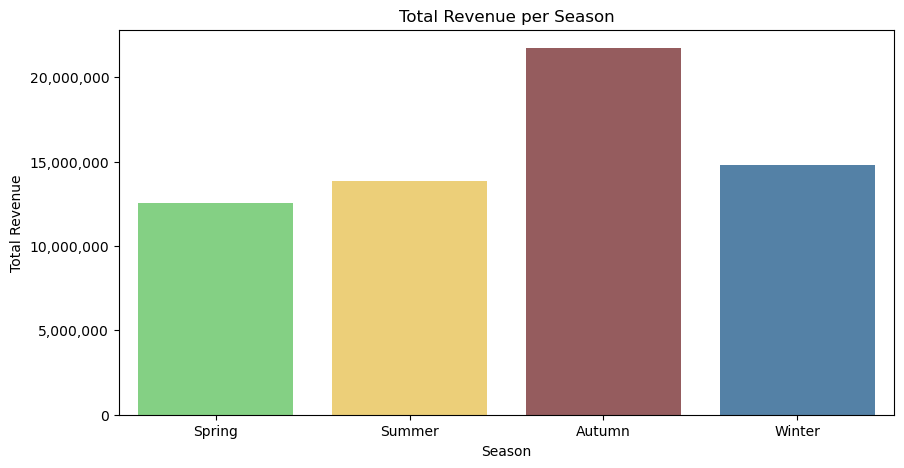

In [194]:
# Total revenue per season
revenue_per_season = df_merge.groupby('Season')['total_revenue'].sum()
season_order = ['Spring', 'Summer', 'Autumn', 'Winter']
season_colors = ["#77DD77", "#FFD966", "#9F5255", "#4682B4"] 
revenue_per_season = revenue_per_season.reindex(season_order)

# Visualisasi Total revenue per season
plt.figure(figsize=(10, 5))
sns.barplot(x=revenue_per_season.index, y=revenue_per_season.values, palette=season_colors)
plt.title('Total Revenue per Season')
plt.xlabel('Season')
plt.ylabel('Total Revenue')
plt.xticks(rotation=0)
plt.gca().yaxis.set_major_formatter(mticker.FuncFormatter(lambda x, _: f'{int(x):,}'))
plt.show()

## Analisis total kuantitas transaksi per Season

C:\Users\benny\AppData\Local\Temp\ipykernel_17412\1715637468.py:9: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




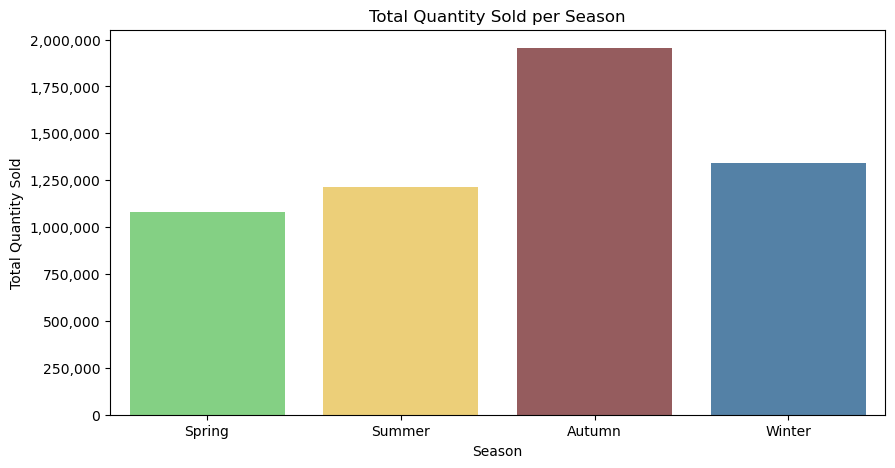

In [196]:
# Jumlah produk terjual per Season
quantity_per_season = df_merge.groupby('Season')['Quantity'].sum()
season_order = ['Spring', 'Summer', 'Autumn', 'Winter']
season_colors = ["#77DD77", "#FFD966", "#9F5255", "#4682B4"] 
quantity_per_season = quantity_per_season.reindex(season_order)

# Visualisasi jumlah produk Terjual per Season
plt.figure(figsize=(10, 5))
sns.barplot(x=quantity_per_season.index, y=quantity_per_season.values, palette=season_colors)
plt.title('Total Quantity Sold per Season')
plt.xlabel('Season')
plt.ylabel('Total Quantity Sold')
plt.xticks(rotation=0)
plt.gca().yaxis.set_major_formatter(mticker.FuncFormatter(lambda x, _: f'{int(x):,}'))
plt.show()

## Kesimpulan: 
Musim Autumn (September, October, November) adalah musim yang paling profitable 

## Top 5 Product per Season

C:\Users\benny\AppData\Local\Temp\ipykernel_17412\3166218876.py:12: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



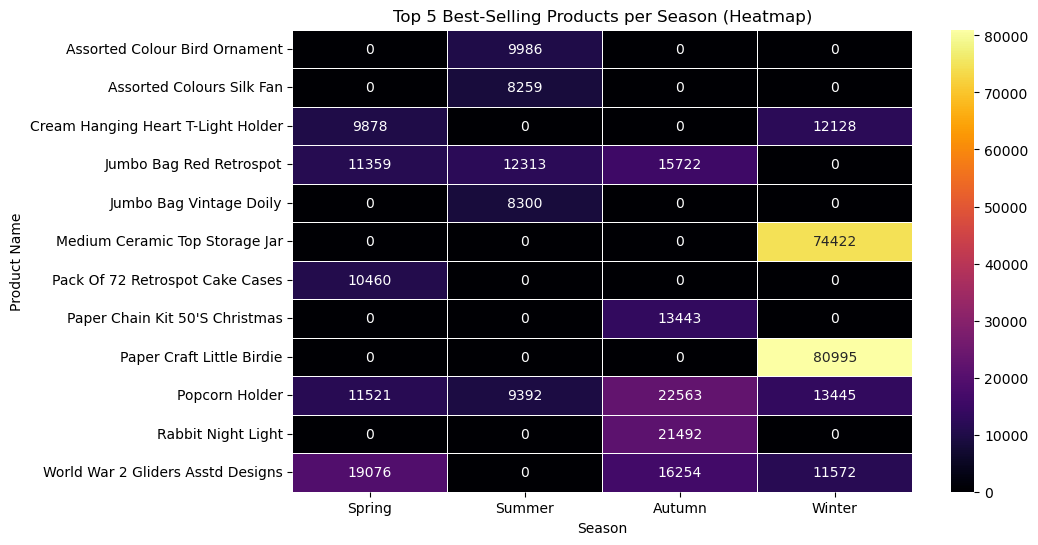

In [199]:
# Top 5 Produk Terlaris di setiap Season
top_products_per_season = df_merge.groupby(['Season', 'ProductName'])['Quantity'].sum().reset_index()

# Mengurutkan Season di visualisasi
season_order = ['Spring', 'Summer', 'Autumn', 'Winter']
top_products_per_season['Season'] = pd.Categorical(top_products_per_season['Season'], categories=season_order, ordered=True)

# Mengrutkan berdasarkan Season dan Quantity
top_products_per_season = top_products_per_season.sort_values(['Season', 'Quantity'], ascending=[True, False])

# Ambil top 5 produk tiap musim
top_5_products = top_products_per_season.groupby('Season').head(5)

# Visualisasi produk terlaris di setiap season
heatmap_data = top_5_products.pivot(index='ProductName', columns='Season', values='Quantity').fillna(0)

plt.figure(figsize=(10, 6))
sns.heatmap(heatmap_data, annot=True, cmap='inferno', fmt='.0f', linewidths=0.5)
plt.title('Top 5 Best-Selling Products per Season (Heatmap)')
plt.xlabel('Season')
plt.ylabel('Product Name')
# plt.savefig('Top 5 Best-Selling Products per Season.png')
plt.show()

### Background data: 
Untuk  menggunakan produk Super Popular di strategi marketing, maka bisa menggunakan Top 5 Best Selling Product per Season   

### Insight: 
1. Strategi marketing campaign bisa menggunakan Top 5 Product dari tiap season yang ada di chart untuk meningkatkan tingkat keberhasilan campaign yang akan dijalankan.  
   
2. Contoh strategi: 
    - Assorted Colour Bird Ornament, Assorted Colours Silk Fan dan Jumbo Bag Vintage Dolly menjadi Top 5 produk di season Summer saja. Maka bisa dipastikan penjualan ketiga produk ini sangat bergantung pada seasonalitas. Jadi gunakan ke 3 produk ini di Summer saja untuk memastikan campaign di season lain berjalan maksimal. 
    - Popcorn Holder cocok digunakan di semua season, maka pastikan stocknya aman tersedia sepanjang tahun.
    - Medium Ceramic Top Storage Jar dan Paper Craft Little Birdie yang sangat laku di Winter bisa menjadi perhatian karena stock yang dibutuhkan cukup banyak untuk memenuhi penjualan selama Winter season

## Seasonality Analysis: Combining seasonality analysis per season, per month dan per day

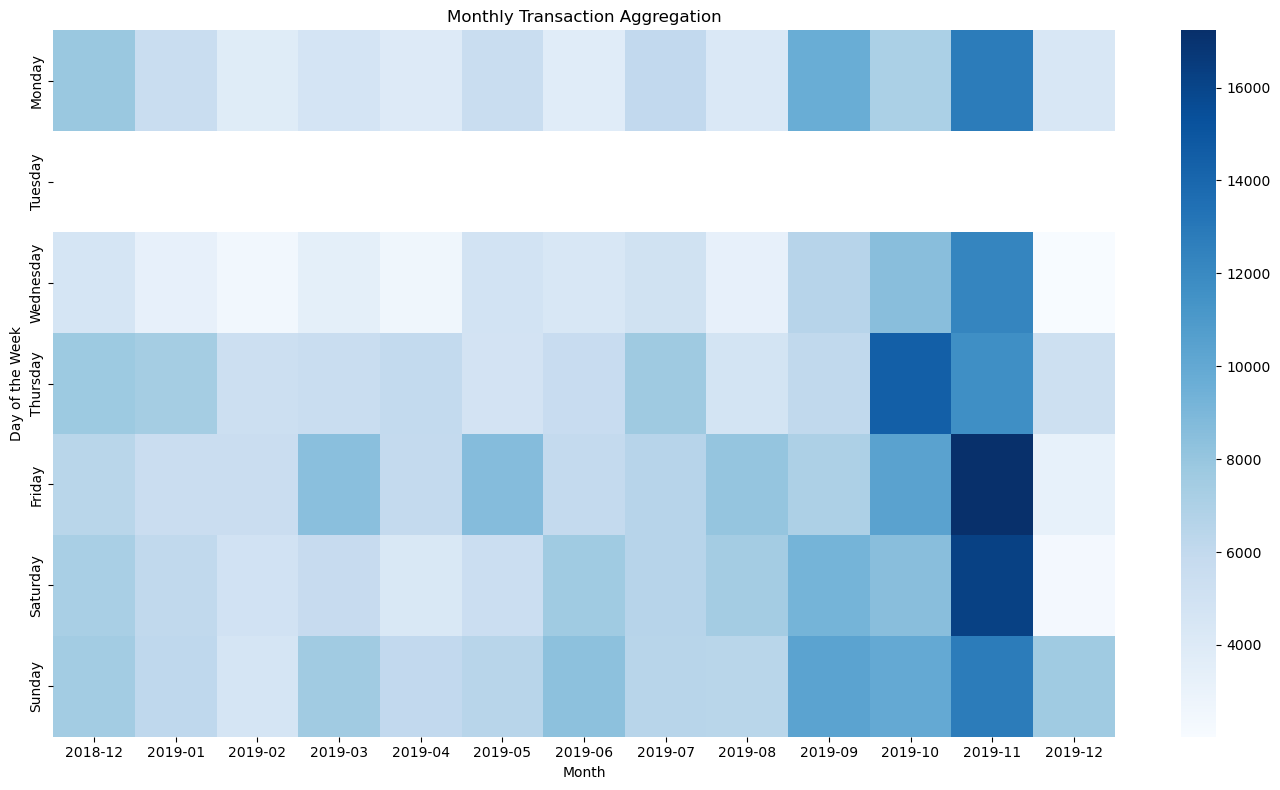

In [202]:
# Analisis total transaksi per bulan dan per hari
heatmap_data = df_merge.groupby(['DayName', 'order_month']).size().unstack(fill_value=0)

# Mengurutkan hari berdasarkan urutan yang benar
day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
heatmap_data = heatmap_data.reindex(day_order)

# Plotting the heatmap
plt.figure(figsize=(14, 8))
sns.heatmap(heatmap_data, cmap='Blues', annot=False, cbar=True)
plt.title('Monthly Transaction Aggregation')
plt.xlabel('Month')
plt.ylabel('Day of the Week')
plt.tight_layout()
plt.savefig('Heatmap Transaction per Month and per Day.png')
plt.show()

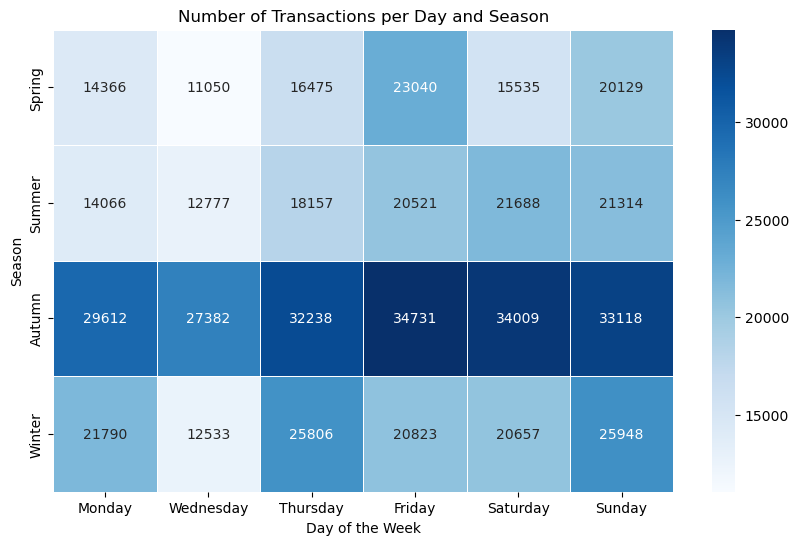

In [203]:
### Analsis jumlah transaksi per hari di setiap musim ###

# Menentukan urutan musim dan hari dalam seminggu yang diinginkan
season_order = ['Spring', 'Summer', 'Autumn', 'Winter']
day_order = ['Monday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

# Rata-rata transaksi berdasarkan hari dalam seminggu di setiap musim
transactions_per_day_season = df_merge.groupby(['Season', 'DayName']).size().unstack()

# Mengurutkan musim sesuai urutan yang diinginkan
transactions_per_day_season = transactions_per_day_season.reindex(season_order)

# Mengurutkan hari dalam seminggu sesuai urutan yang diinginkan
transactions_per_day_season = transactions_per_day_season[day_order]

# Visualisasi: Heatmap untuk melihat hubungan hari dan musim dengan jumlah transaksi
plt.figure(figsize=(10, 6))
sns.heatmap(transactions_per_day_season, annot=True, cmap='Blues', fmt='d', linewidths=0.5)
plt.title('Number of Transactions per Day and Season')
plt.xlabel('Day of the Week')
plt.ylabel('Season')
plt.savefig('Number of Transactions per Day and Season.png')
plt.show()

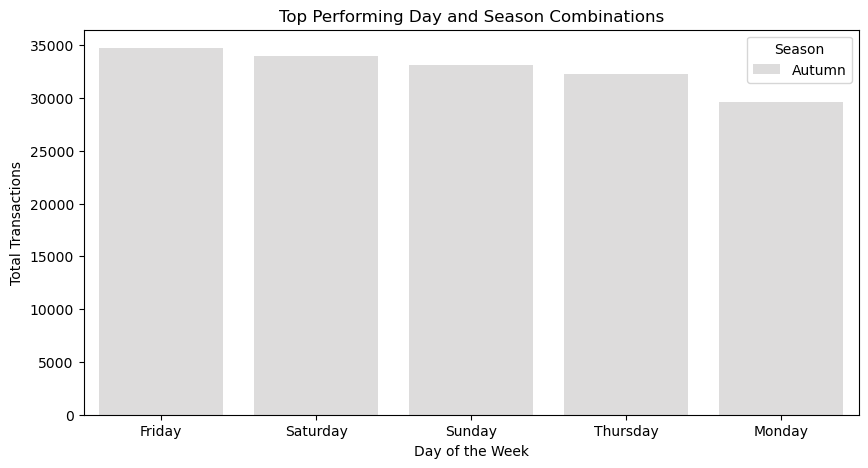

In [204]:
# Identifikasi kombinasi hari dan season dengan performa transaksi tertinggi
top_day_season = transactions_per_day_season.stack().reset_index()
top_day_season.columns = ['Season', 'DayName', 'Transactions']
top_day_season = top_day_season.sort_values(by='Transactions', ascending=False).head(5)

# Visualisasi: Bar Chart untuk hari dengan transaksi tertinggi per musim
plt.figure(figsize=(10, 5))
sns.barplot(data=top_day_season, x='DayName', y='Transactions', hue='Season', palette='coolwarm')
plt.title('Top Performing Day and Season Combinations')
plt.xlabel('Day of the Week')
plt.ylabel('Total Transactions')
plt.legend(title='Season')
plt.xticks(rotation=0)
plt.show()

### Background data: 
Heatmap untuk menunjukkan behaviour belanja customers selama 1 tahun. 

### Insight: 
1. Data ini bisa dijadikan acuan waktu yang tepat untuk menjalankan strategi marketing campaign tiap bulannya.
2. Contohnya yang paling menonjol di bulan November hari Jumat jumlah transaksinya selama sebulan itu mencapai 16.000, artinya per minggu bisa terjadi 4.000 transaksi di setiap hari Jumat. Maka hari Jumat di November tahun 2020 bisa menjadi waktu yang paling tepat untuk menjalankan semua jenis promosi untuk mengenerate transaksi paling tinggi.

## Price Sensitivity per Season

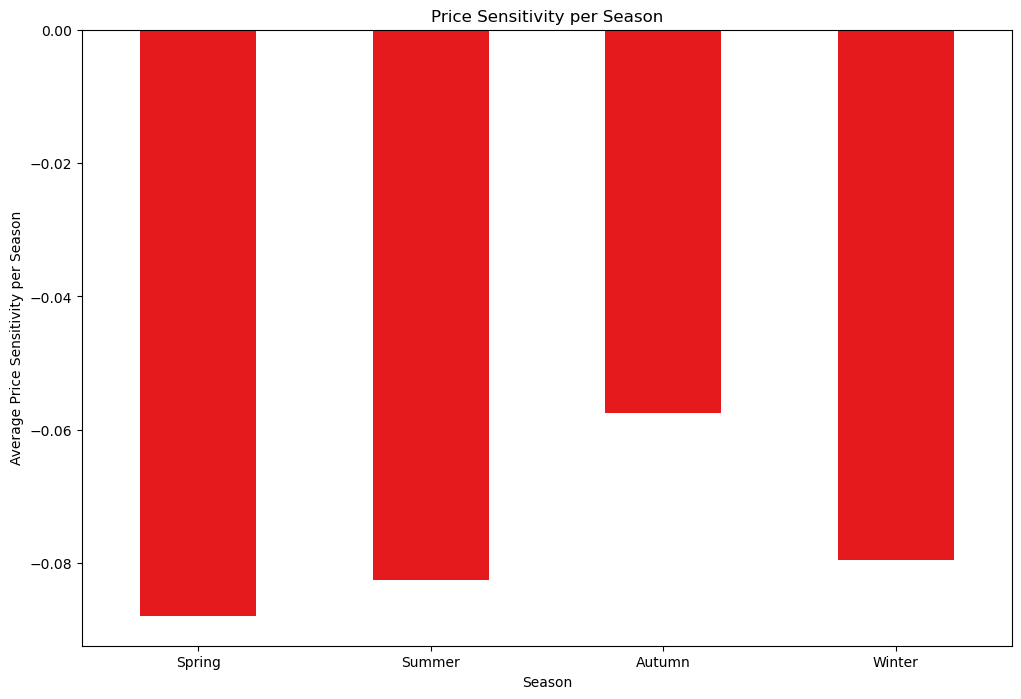

In [207]:
# Jumlah transaksi di tiap kategori produk transaksi per season
price_sensitivity_per_season = df_merge.groupby('Season')['price_quantity_correlation'].mean()
season_order = ['Spring', 'Summer', 'Autumn', 'Winter']
price_sensitivity_per_season = price_sensitivity_per_season.reindex(season_order)

# Plot 4: Kategori Pelanggan dengan Transaksi Terbanyak per Musim
price_sensitivity_per_season.plot(kind='bar', stacked=True, figsize=(12, 8), colormap='Set1')
plt.title('Price Sensitivity per Season')
plt.xlabel('Season')
plt.ylabel('Average Price Sensitivity per Season')
plt.xticks(rotation=0)
plt.savefig('Price Sensitivity per Season.png')
plt.show()

## Analysis: Price Sensitivity Data Distribution
Dari hasil pengecekan bisa disimpulkan bahwa penyebaran nilai koefisien korelasi antara Price dan Quantity banyak di sekitar -0.1 sampai 0, artinya banyak produk yang bila harganya meningkat maka akan terjadi penurunan kuantitas penjualan, biarpun efek penurunannya tidak terlalu besar karena nilai minus korelasinya hanya sekitar -0.1 sampai -0.45.

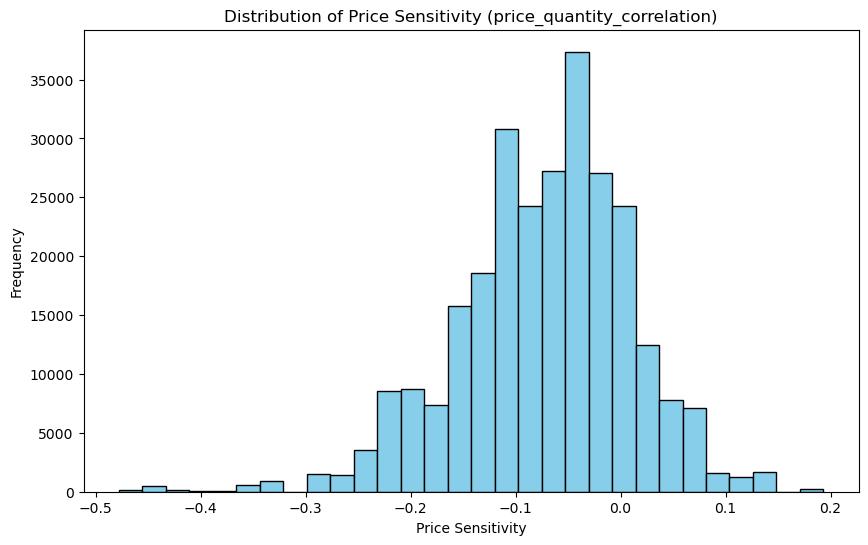

In [209]:
# Visualisasi: Histogram untuk melihat distribusi 'price_quantity_correlation'
plt.figure(figsize=(10, 6))
plt.hist(df_merge['price_quantity_correlation'].dropna(), bins=30, color='skyblue', edgecolor='black')
plt.title('Distribution of Price Sensitivity (price_quantity_correlation)')
plt.xlabel('Price Sensitivity')
plt.ylabel('Frequency')
plt.show()

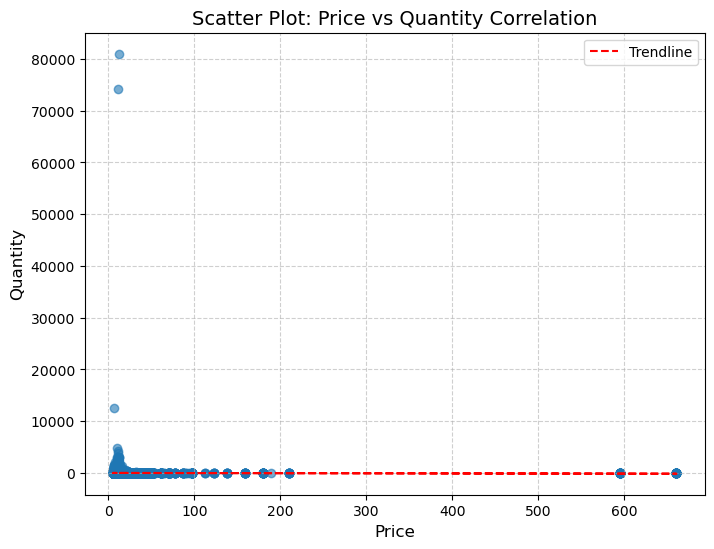

In [210]:
# Melihat korelasi Price vs Qty untuk semua produk
all_product_data = df_merge[['ProductName', 'Price', 'Quantity']]

# Scatter plot untuk koreplasi price vs qty 
plt.figure(figsize=(8, 6))
plt.scatter(all_product_data['Price'], all_product_data['Quantity'], alpha=0.6)

# Menambahkan trendline
z = np.polyfit(all_product_data['Price'], all_product_data['Quantity'], 1)
p = np.poly1d(z)
plt.plot(all_product_data['Price'], p(all_product_data['Price']), "r--", label="Trendline")
plt.legend()

plt.title(f'Scatter Plot: Price vs Quantity Correlation', fontsize=14)
plt.xlabel('Price', fontsize=12)
plt.ylabel('Quantity', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

### Karena customer paling banyak berada di United Kingdom dan dari data Top 5 Countries kita tidak bisa melihat porsi customer category yang menjadi fokus kita di negara lain, maka analisis di bawah ini ditujukan untuk melihat seberapa banyak customer category yang menjadi fokus kita di tiap negara (Potential Loyalist, Promising Customers, Loyal Customers dan Lost Customers)

In [212]:
# Menyaring data berdasarkan negara dan Final_Customer_Category
df_customer_focus = df_merge[(df_merge['Country'] != 'United Kingdom') & 
                 (df_merge['Final_Customer_Category'].isin(['Potential Loyalist', 'Promising', 'Loyal Customers', 'Lost Customers']))]

# Menghitung jumlah customer berdasarkan negara dan kategori customer
customer_counts = df_customer_focus.groupby(['Country', 'Final_Customer_Category']).size().reset_index(name='Customer Count')
customer_counts

Country Final_Customer_Category  Customer Count
0              Australia          Lost Customers              10
1              Australia      Potential Loyalist            1114
2              Australia               Promising             445
3                Austria          Lost Customers              43
4                Austria               Promising             809
..                   ...                     ...             ...
62           Switzerland               Promising            1401
63                   USA          Lost Customers              35
64                   USA               Promising             221
65  United Arab Emirates          Lost Customers              30
66           Unspecified          Lost Customers             328

[67 rows x 3 columns]

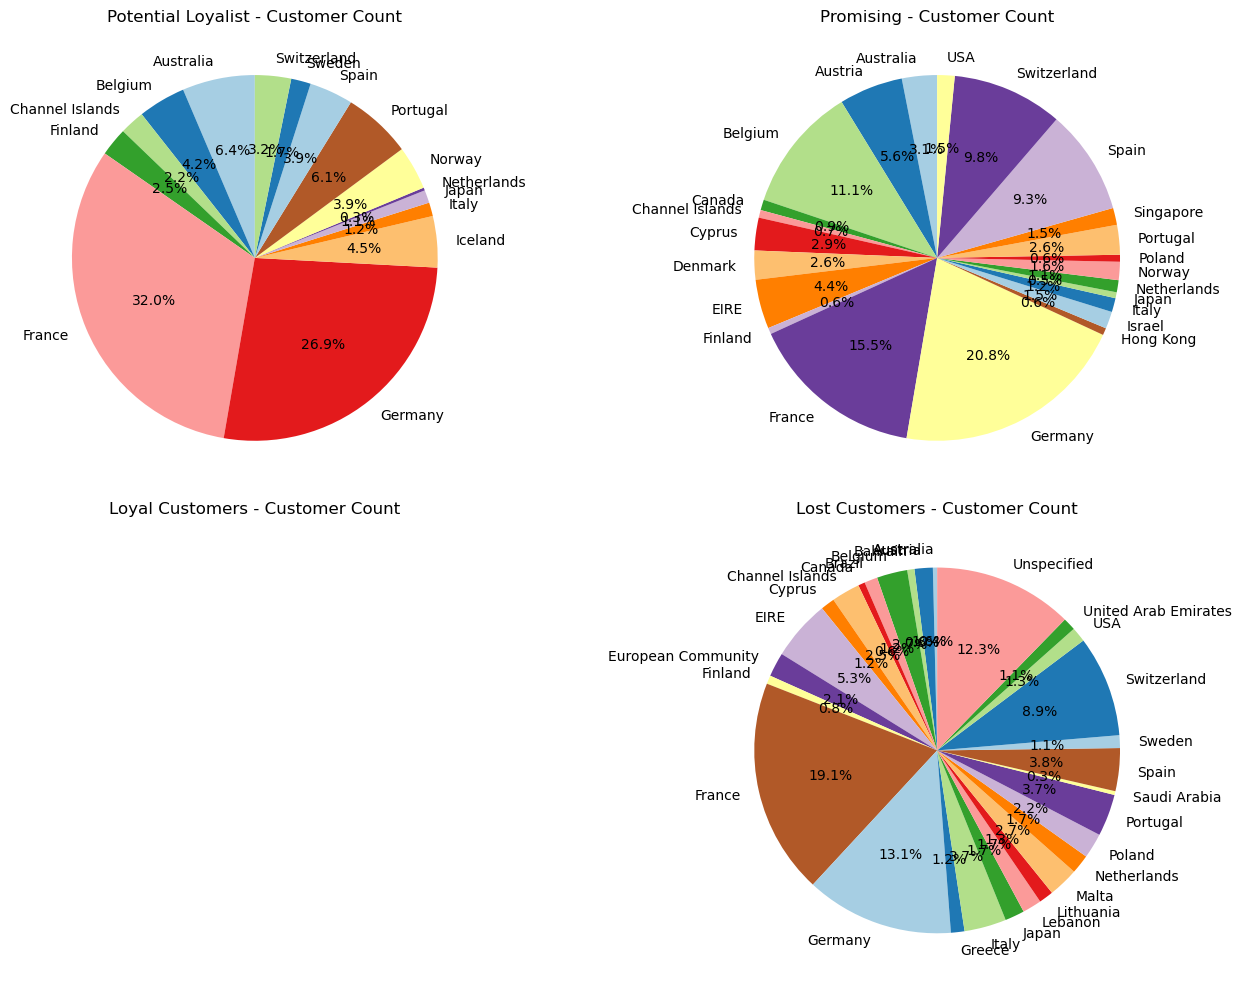

In [213]:
# Menyaring data berdasarkan negara dan Final_Customer_Category
df_customer_focus = df_merge[(df_merge['Country'] != 'United Kingdom') & 
                 (df_merge['Final_Customer_Category'].isin(['Potential Loyalist', 'Promising', 'Loyal Customers', 'Lost Customers']))]

# Menghitung jumlah customer berdasarkan negara dan kategori customer
customer_counts = df_customer_focus.groupby(['Country', 'Final_Customer_Category']).size().reset_index(name='Customer Count')

# Kategori customer
categories = ['Potential Loyalist', 'Promising', 'Loyal Customers', 'Lost Customers']

# Setup subplots untuk 4 pie chart
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.flatten()

for i, category in enumerate(categories):
    # Menyaring data untuk kategori customer tertentu
    category_data = customer_counts[customer_counts['Final_Customer_Category'] == category]
    
    # Membuat pie chart
    axes[i].pie(category_data['Customer Count'], 
                labels=category_data['Country'], 
                autopct='%1.1f%%', 
                startangle=90, 
                colors=plt.cm.Paired.colors[:len(category_data)])
    axes[i].set_title(f'{category} - Customer Count')

# Menampilkan visualisasi
plt.tight_layout()
plt.savefig('Customer Count per Country.png')
plt.show()

## Agar pie chart tidak overplotting, maka diambil Top 5 Country (except UK) saja untuk dimasukkan ke pie chart

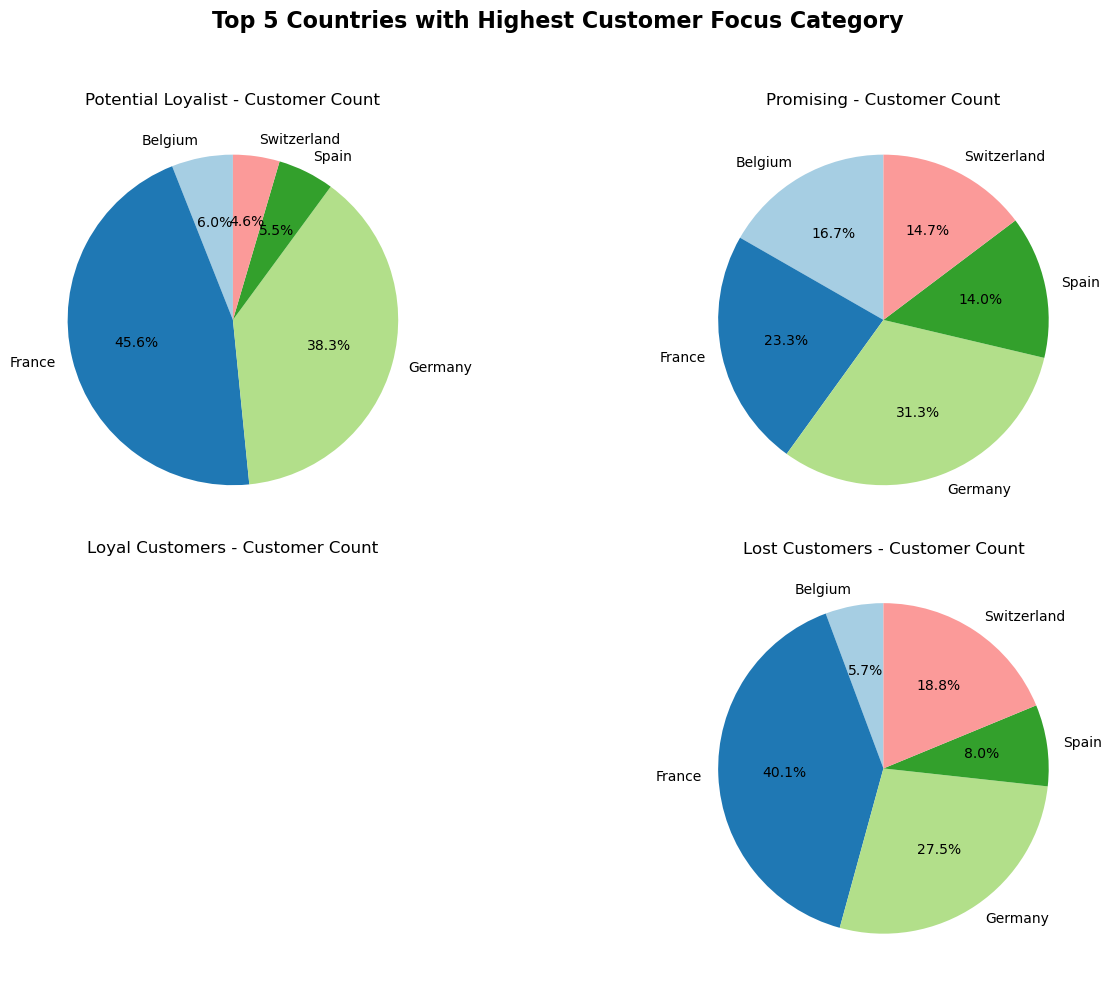

In [215]:
# Menyaring data berdasarkan negara dan Final_Customer_Category
df_customer_focus = df_merge[(df_merge['Country'] != 'United Kingdom') & 
                 (df_merge['Final_Customer_Category'].isin(['Potential Loyalist', 'Promising', 'Loyal Customers', 'Lost Customers']))]

# Menghitung jumlah customer berdasarkan negara dan kategori customer
customer_counts = df_customer_focus.groupby(['Country', 'Final_Customer_Category']).size().reset_index(name='Customer Count')

# Mengambil 5 negara dengan jumlah customer tertinggi secara keseluruhan
top_countries = customer_counts.groupby('Country')['Customer Count'].sum().nlargest(5).index

# Menyaring data hanya untuk top 5 negara
customer_counts = customer_counts[customer_counts['Country'].isin(top_countries)]

# Kategori customer
categories = ['Potential Loyalist', 'Promising', 'Loyal Customers', 'Lost Customers']

# Setup subplots untuk 4 pie chart
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
fig.suptitle('Top 5 Countries with Highest Customer Focus Category', fontsize=16, fontweight='bold')
axes = axes.flatten()

for i, category in enumerate(categories):
    # Menyaring data untuk kategori customer tertentu
    category_data = customer_counts[customer_counts['Final_Customer_Category'] == category]
    
    # Membuat pie chart
    axes[i].pie(category_data['Customer Count'], 
                labels=category_data['Country'], 
                autopct='%1.1f%%', 
                startangle=90, 
                colors=plt.cm.Paired.colors[:len(category_data)])
    axes[i].set_title(f'{category} - Customer Count')

# Menampilkan visualisasi
plt.tight_layout(rect=[0, 0, 1, 0.95])  # Menyesuaikan tata letak agar title tidak tertutup
plt.show()

# Forecasting 2020 dengan Prophet model dan Controlled Forecasting (menambahkan 10% dari total revenue per bulan di tahun 2019)

C:\Users\benny\AppData\Local\Temp\ipykernel_17412\1566823214.py:7: FutureWarning:

'M' is deprecated and will be removed in a future version, please use 'ME' instead.

C:\Users\benny\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning:

Too few observations to estimate starting parameters for ARMA and trend. All parameters except for variances will be set to zeros.

C:\Users\benny\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning:

Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.

C:\Users\benny\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\mlemodel.py:1233: RuntimeWarning:

invalid value encountered in divide

17:51:05 - cmdstanpy - INFO - Chain [1] start processing
17:51:05 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\benny\anaconda3\Lib\site-packages\prophet\forecaster.py:1854: FutureWarning:

'M' is deprecated and will 

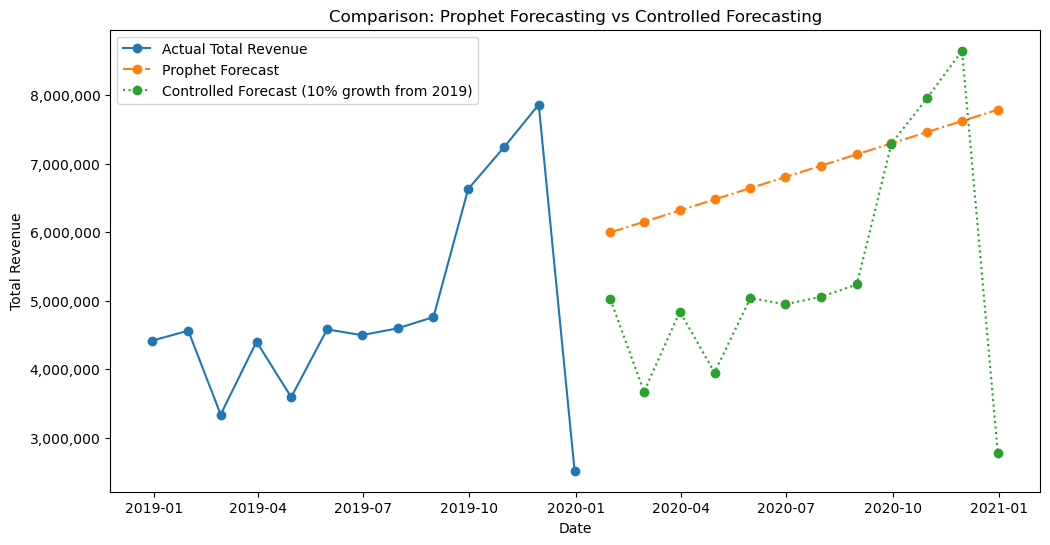

In [217]:
# Pastikan kolom tanggal diubah menjadi datetime dan diatur sebagai indeks
df_merge_forecasting = df_merge.copy() # karena kolom Date mau dipakai sebagai indeks, maka saya copy dataframenya agar df aslinya tidak berubah dan masih bisa digunakan di analisa selanjutnya 
df_merge_forecasting['Date'] = pd.to_datetime(df_merge_forecasting['Date'])
df_merge_forecasting.set_index('Date', inplace=True)

# Mengagregasi total revenue per bulan
monthly_data = df_merge_forecasting['total_revenue'].resample('M').sum()

# Mempersiapkan SARIMAX model untuk digunakan di Controlled Forecast
sarimax_model = SARIMAX(monthly_data, order=(1, 1, 1), seasonal_order=(1, 1, 1, 12))
sarimax_model_fit = sarimax_model.fit()

# Mempersiapkan data untuk Prophet
prophet_data = monthly_data.reset_index()
prophet_data.columns = ['ds', 'y']

# Mempersiapkan Prophet model
prophet_model = Prophet()
prophet_model.fit(prophet_data)

# Forecast untuk 12 bulan di 2020 (Prophet)
future_dates = prophet_model.make_future_dataframe(periods=12, freq='M')
prophet_forecast = prophet_model.predict(future_dates)
prophet_forecast_2020 = prophet_forecast[prophet_forecast['ds'].dt.year == 2020]
prophet_forecast_series = pd.Series(prophet_forecast_2020['yhat'].values, index=prophet_forecast_2020['ds'])

# Forecast untuk 12 bulan di 2020 (SARIMAX)
sarimax_forecast_index = pd.date_range(start=monthly_data.index[-1], periods=13, freq='M')[1:]
sarimax_forecast_series = pd.Series(sarimax_model_fit.forecast(steps=12), index=sarimax_forecast_index)

# Controlled Forecast untuk 12 bulan di 2020 dengan ekspektasi peningkatan 10% dari total revenue di tahun 2019 
average_2019_revenue = monthly_data['2019'].mean()
controlled_forecast = [monthly_data['2019'].iloc[i % 12] * 1.1 for i in range(12)]
controlled_forecast_series = pd.Series(controlled_forecast, index=sarimax_forecast_index)

# Visualization
plt.figure(figsize=(12, 6))
plt.plot(monthly_data.index, monthly_data, marker='o', label="Actual Total Revenue")
plt.plot(prophet_forecast_series, marker='o', linestyle='dashdot', label="Prophet Forecast")
plt.plot(controlled_forecast_series, marker='o', linestyle='dotted', label="Controlled Forecast (10% growth from 2019)")
plt.legend()
plt.title("Comparison: Prophet Forecasting vs Controlled Forecasting")
plt.xlabel("Date")
plt.ylabel("Total Revenue")
plt.gca().yaxis.set_major_formatter(mticker.FuncFormatter(lambda x, _: f'{int(x):,}'))
plt.savefig('Prophet Forecasting vs Controlled Forecasting.png')
plt.show()